# Detection of Vote Fraud

In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import chi2, norm
import scipy.stats as stats
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
import numpy as np

## Theoretical Benford's law

Benford's law states that in many naturally occurring collections of numbers, the leading digit is likely to be small. In sets that obey Benford's law, in the first position, the number 1 appears as the leading significant digit about 30% of the time, while larger digits occur in that position less frequently: 9 as the first digit less than 5% of the time. Here, a function that compute the theoretical Benford's law is implemented. This function can be used for alle digits (0-9) but for the first position the digit 0 is not allowed.

### Functions

In [210]:
def benford_nth_digit_probabilities(n):
    """
    Calculate the probabilities for all digits (0-9) appearing at the n-th position.
    For the first position, this is not applicable to digit 0.
    """
    probabilities = {}
    if n == 1:
        probabilities[0] = 0
        for d in range(1, 10):
            probabilities[d] = math.log10(1 + 1 / d)
    else:
        for d in range(10):
            total_sum = 0
            for k in range(10**(n-2), 10**(n-1)):
                total_sum += math.log10(1 + 1 / (10 * k + d))
            probabilities[d] = total_sum
    return probabilities


Now the function is generalized for other bases of numbers.

In [211]:
def benford_nth_digit_probabilities_gen(base=10, n=1):
    """
    Calculate the probabilities for all digits (0 to base-1) appearing at the n-th position
    in a numeric system of the specified base.
    For the first position, this is not applicable to digit 0.
    """
    probabilities = {}
    
    if n == 1:
        # For the first digit, digit 0 is not allowed.
        probabilities[0] = 0
        for d in range(1, base):
            # Use logarithm in the specified base for the calculation
            probabilities[d] = math.log(1 + 1 / d, base)
    else:
        # For subsequent digits, all digits (0 to base-1) are considered
        for d in range(base):
            total_sum = 0
            # Sum over possible positions for digits
            for k in range(base**(n-2), base**(n-1)):
                total_sum += math.log(1 + 1 / (base * k + d), base)
            probabilities[d] = total_sum
    
    return probabilities



In [212]:
Benford_theory = pd.DataFrame([benford_nth_digit_probabilities(1), benford_nth_digit_probabilities(2), benford_nth_digit_probabilities(3), benford_nth_digit_probabilities(4)])
Benford_theory = Benford_theory.T
Benford_theory.columns = ['First position', 'Second position', 'Third position', 'Fourth position']

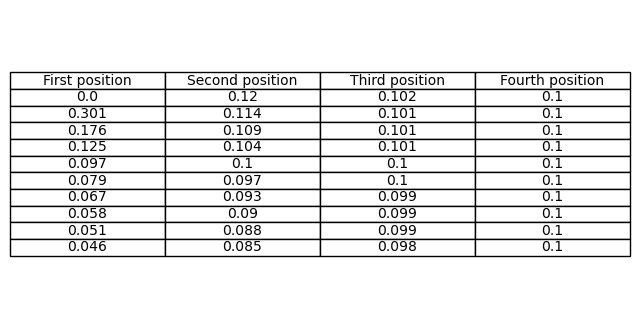

C:\Users\franc\AppData\Local\Temp\ipykernel_5012\1241451128.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  Benford_theory.to_latex('table_with_sum_probabilities.tex', float_format="%.3f")


<Figure size 640x480 with 0 Axes>

In [213]:
#only 3 decimal places
Benford_theory = Benford_theory.round(3)

# table to represent the probabilities
fig, ax = plt.subplots(figsize=(8, 4))  
ax.axis('tight')
ax.axis('off')
ax.table(cellText=Benford_theory.values, colLabels=Benford_theory.columns, cellLoc='center', loc='center')

plt.show()
plt.savefig('table_with_sum_probabilities.png', dpi=300, bbox_inches='tight')
#write all the data in a type that can be used in a LaTeX table
Benford_theory.to_latex('table_with_sum_probabilities.tex', float_format="%.3f")


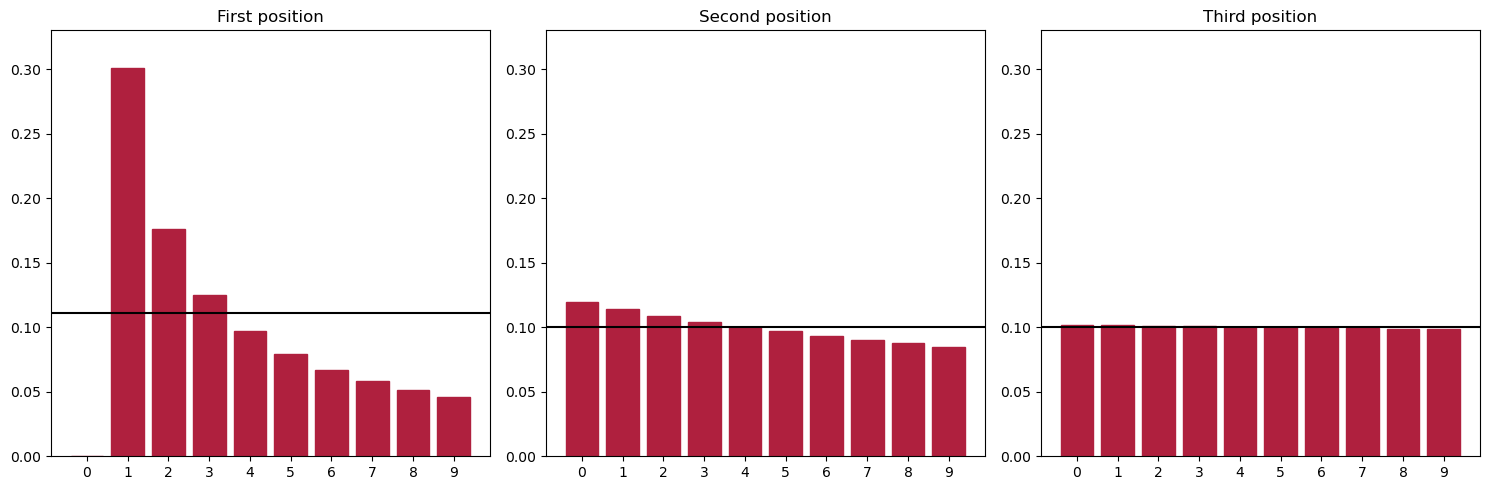

In [214]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax in axs:
    ax.set_ylim(0, 0.33)

for ax in axs:
    ax.set_xticks(range(10))

axs[0].bar(benford_nth_digit_probabilities(1).keys(), benford_nth_digit_probabilities(1).values())
axs[0].set_title('First position')
axs[1].bar(benford_nth_digit_probabilities(2).keys(), benford_nth_digit_probabilities(2).values())
axs[1].set_title('Second position')
axs[2].bar(benford_nth_digit_probabilities(3).keys(), benford_nth_digit_probabilities(3).values())
axs[2].set_title('Third position')

#use the color #af203e in HEX for the bars
for ax in axs:
    for bar in ax.patches:
        bar.set_color('#af203e')

for ax in axs:
    if ax.get_title() == 'First position':
        ax.axhline(y=1/9, color='black')
    else:
        ax.axhline(y=1/10, color='black')

plt.tight_layout()
plt.show()

In [215]:
def Benford_theory_firsttwo_digits():
    """
    Calculate the probabilities for the first two digits (10-99) with Benford's law that is 1/log(1+1/d) where d is the digit.
    """
    probabilities = {}
    for d in range(10, 100):
        probabilities[d] = math.log10(1 + 1 / d)
    return probabilities


Text(0.5, 1.0, 'First two digits')

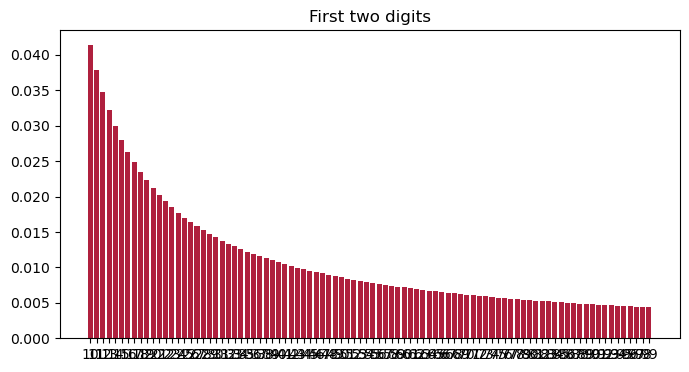

In [216]:
#plot Benford_theory_firsttwo_digits
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xticks(range(10, 100))
ax.bar(Benford_theory_firsttwo_digits().keys(), Benford_theory_firsttwo_digits().values(), color='#af203e')
ax.set_title('First two digits')


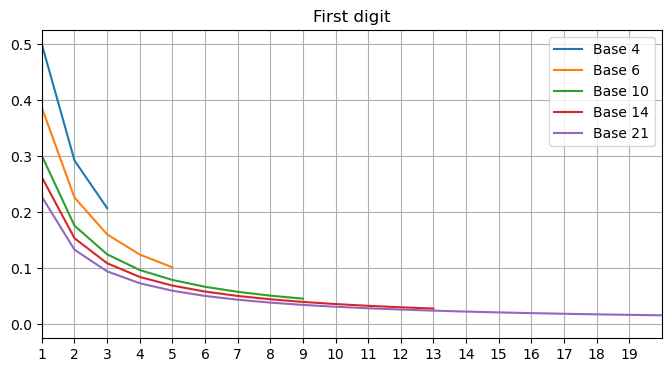

In [217]:


#create a plot with on the y-axis the probabilities and on the x-axis the first digit
#I want that you compute the Benford probabilities for the first digit for base 4, 6, 10 and 14 and plot them in the same plot as a 4 lines with a point for each digit, with a grid and a xlim from 1 to 13
#plot the lines in a scale of reds


fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xticks(range(1, 20))
ax.set_xlim(1, 20)
ax.grid(True)
for base in [4, 6, 10, 14, 21]:
    probabilities = benford_nth_digit_probabilities_gen(base, 1)
    ax.plot(probabilities.keys(), probabilities.values(), label=f'Base {base}')
ax.legend()
ax.set_title('First digit')
plt.show()


#### Application of the Benford's law to the data

In this notebook, a function that computes the probability of the different digits is implemented. The function also take as input the position that the user want to compute the probability. Take care that for the numbers with decimal values, the point is removed. The results are also calcolate for the digits from 0 to 9 but the digit 0 is not allowed in the first position so is 0 everytimes.

In [218]:
def data_digit_probabilities(data, position):
    """
    Calculate the probabilities for the digit (0-9) at a given position according to Benford's Law for a list of numbers.
    Returns a dictionary with digits as keys and their probabilities as values.
    
    Parameters:
        data (list): A list of numerical data (int or float).
        position (int): The position of the digit to analyze (1 for the first digit, 2 for the second, etc.).
    
    Returns:
        probabilities (dict): A dictionary with digit keys (0-9) and their probabilities as values.
    """
    probabilities = {}
    for n in range(0, 10):
        probabilities[n] = 0
    total_count = 0
    
    for number in data:
        str_number = str(abs(number)).replace('.', '')

        if len(str_number) >= position:
            digit = int(str_number[position - 1])
            probabilities[digit] += 1
            total_count += 1
    
    # Compute the probabilities instead of counts
    if total_count > 0:
        for n in range(0, 10):
            probabilities[n] /= total_count
    
    return probabilities


In [219]:
def data_digit_probabilities_gen(data, base=10, position=1):
    """
    Calculate the probabilities for the digit (0 to base-1) at a given position according to Benford's Law for a list of numbers.
    Returns a dictionary with digits as keys and their probabilities as values.
    
    Parameters:
        data (list): A list of numerical data (int or float).
        base (int): The base of the numeric system (e.g., 10 for decimal, 16 for hexadecimal).
        position (int): The position of the digit to analyze (1 for the first digit, 2 for the second, etc.).
    
    Returns:
        probabilities (dict): A dictionary with digit keys (0 to base-1) and their probabilities as values.
    """
    probabilities = {n: 0 for n in range(0, base)}
    total_count = 0

    for number in data:
        str_number = str(abs(number)).replace('.', '')

        if len(str_number) >= position:
            digit = int(str_number[position - 1], base=10)  # Assumes input data is in base 10
            if digit < base:
                probabilities[digit] += 1
                total_count += 1
    
    # Compute the probabilities instead of counts
    if total_count > 0:
        for n in range(0, base):
            probabilities[n] /= total_count
    
    return probabilities


In [220]:
def data_digit_probabilities_firsttwo(data):
    """
    Calculate the probabilities for the first two digits (10-99) according to Benford's Law for a list of numbers.
    Returns a dictionary with two-digit numbers as keys and their probabilities as values.

    Parameters:
        data (list): A list of numerical data (int or float).

    Returns:
        probabilities (dict): A dictionary with two-digit number keys (10-99) and their probabilities as values.
    """

    probabilities = {}
    for n in range(10, 100):
        probabilities[n] = 0
    total_count = 0

    for number in data:
        str_number = str(abs(number)).replace('.', '')

        if len(str_number) >= 2:
            two_digits = int(str_number[:2])
            if two_digits >= 10:
                probabilities[two_digits] += 1
                total_count += 1

    # Compute the probabilities instead of counts
    if total_count > 0:
        for n in range(10, 100):
            probabilities[n] /= total_count

    return probabilities
    

In [221]:
#use the function above and test it with numbers from 1 to 1000
numbers = list(range(1, 1001))
first_digit_probabilities_for_numbers = data_digit_probabilities(numbers, 2)
first_digit_probabilities_for_numbers


{0: 0.10090817356205853,
 1: 0.09989909182643794,
 2: 0.09989909182643794,
 3: 0.09989909182643794,
 4: 0.09989909182643794,
 5: 0.09989909182643794,
 6: 0.09989909182643794,
 7: 0.09989909182643794,
 8: 0.09989909182643794,
 9: 0.09989909182643794}

#### Some statistical tests

A simple function to calculate deviations from Benford's law is here implemented. The deviation is calculated as the difference between the observed frequency and the formula of Benford's law. Delta that results is simply the maximum difference, in percent, between the probbilities of the first significant digit of the given distribution and the Benford's law. Thus, for example, delta=0 means that the distribution is perfectly following Benford's law, delta equal to 15.09 indicates that the probability of some digit d {1,2,3,4,5,6,7,8,9} differs from log10(1+1/d) by 15.09%.

In [222]:
def benford_deviation(observed_probabilities):
    """
    Calculates the deviation from Benford's Law.

    Args:
        observed_probabilities: Dictionary with keys 0 to 9 representing the observed probabilities for each first digit.

    Returns:
        The maximum deviation from Benford's Law, ignoring the key 0 as it does not apply to Benford's Law.
    """
    deviations = []
    for d in range(1, 10):  # Benford's Law applies to digits 1 through 9
        theoretical_probability = math.log10(1 + 1 / d)
        deviation = abs(observed_probabilities[d] - theoretical_probability) * 100
        deviations.append(deviation)

    return max(deviations)


##### Z-statistic

We use a Z-statistic woith two-tailed test. This because deviations cam occur in both directions. One tailed-test is used for specific deviations in one direction

In [223]:
def calculate_z_statistic(DP, BP, N, alpha_values=[0.001, 0.01, 0.05], alpha_corrected_values=None):
    z_values = {}
    p_values = {}

    print(f"N: {N}")
    print("Z-Statistics and Hypothesis Tests\n")

    for idx, (dp, bp) in enumerate(zip(DP, BP), start=1):
        absolute_difference = abs(dp - bp)
        continuity_correction = 1 / (2 * N)
        numerator = absolute_difference - continuity_correction if continuity_correction < absolute_difference else absolute_difference
        denominator = math.sqrt(bp * (1 - bp) / N)

        Z = numerator / denominator
        p_value = 2 * (1 - stats.norm.cdf(abs(Z)))

        print(f"Digit {idx}:")
        print(f"  Actual proportion (DP): {dp:.4f}")
        print(f"  Expected proportion (BP): {bp:.4f}")
        print(f"  Z-statistic: {Z:.4f}")
        print(f"  p-value: {p_value:.6f}")

        for alpha in alpha_values:
            critical_z = stats.norm.ppf(1 - alpha / 2)
            print(f"  Critical value at alpha={alpha*100:.5f}%: {critical_z:.4f}")
            if abs(Z) > critical_z:
                print(f"  Reject null hypothesis at alpha={alpha*100:.5f}%")
            else:
                print(f"  Fail to reject null hypothesis at alpha={alpha*100:.5f}%")

        if alpha_corrected_values:
            for alpha_corr in alpha_corrected_values:
                critical_z_corr = stats.norm.ppf(1 - alpha_corr / 2)
                print(f"  Corrected critical value at alpha={alpha_corr*100:.5f}%: {critical_z_corr:.4f}")
                if abs(Z) > critical_z_corr:
                    print(f"  Reject null hypothesis at corrected alpha={alpha_corr*100:.5f}%")
                else:
                    print(f"  Fail to reject null hypothesis at corrected alpha={alpha_corr*100:.5f}%")

        print("=" * 60)

        z_values[f"Digit_{idx}"] = Z
        p_values[f"Digit_{idx}"] = p_value

    return z_values, p_values


##### Chi-squared test

In [224]:
def calculate_chi_square(DP, BP, N, alpha_levels=[0.001, 0.01, 0.05]):
    DP_frequencies = [dp * N for dp in DP]
    BP_frequencies = [bp * N for bp in BP]
    
    chi_square = sum((df - bf)**2 / bf for df, bf in zip(DP_frequencies, BP_frequencies))
    df = len(DP) - 1
    p_value = 1 - chi2.cdf(chi_square, df)
    
    print(f"N: {N}")
    print(f"Chi-Square statistic: {chi_square:.4f}")
    print(f"p-value: {p_value:.6f}")
    
    results = {}
    for alpha in alpha_levels:
        if p_value < alpha:
            decision = "Reject the null hypothesis"
        else:
            decision = "Fail to reject the null hypothesis"
        
        results[alpha] = {
            "chi_square": chi_square,
            "p_value": f"{p_value:.6f}",
            "decision": decision,
            "degrees of freedom": df
        }
        print(f"At alpha={alpha:.6f}: {decision}")
    
    return results, chi_square, p_value

##### Kolmogorov-Smirnov test
Kolmogorov-Smirnov test is a non-parametric test that compares the cumulative distribution of the data with the cumulative distribution of the theoretical distribution. The test statistic is the maximum absolute difference between the two cumulative distributions. The null hypothesis is that the two distributions are the same. The test is applied to the significant digits of the data.

The largest difference of the absolute values of these digits is also called supremum distance.

In [225]:
# Function to compute KS statistic manually
def calculate_ks_manually(benford_cumulative, observed_cumulative):
    """
    Calculate the KS statistic (supremum) manually.
    """
    differences = [abs(b - o) for b, o in zip(benford_cumulative, observed_cumulative)]
    supremum = max(differences)
    supremum_index = differences.index(supremum)
    return supremum, supremum_index



# Function to compute the theoretical p-value manually
def manual_ks_p_value(ks_statistic, n):
    """
    Computes the p-value for the KS statistic using the theoretical formula.
    """
    if ks_statistic <= 0:
        return 1.0  # If KS statistic is zero, the p-value is maximal (no difference)

    # Summation for the theoretical p-value formula
    j = np.arange(1, 100)  # Summation from 1 to 100 for approximation
    terms = (-1) ** (j - 1) * np.exp(-2 * (j ** 2) * (ks_statistic ** 2) * n)
    p_value = 2 * np.sum(terms)
    
    # Ensure the p-value is within the valid range [0, 1]
    return max(0.0, min(p_value, 1.0))

##### Saville regression test

In [226]:
def saville_regression(BP, dp, alpha_levels=[0.001, 0.01, 0.05]):
    """
    Perform the Saville Regression with a joint Z-test for H0: (b0 = 0, b1 = 1).

    Parameters:
        BP (list or array): Theoretical Benford proportions (independent variable).
        dp (list or array): Observed dataset proportions (dependent variable).
        alpha_levels (list): Significance levels to compare the p-values.

    Returns:
        dict: A dictionary with regression parameters, z-scores, p-values, and hypothesis test results.
    """

    # Convert inputs to numpy arrays and reshape for sklearn
    BP = np.array(BP).reshape(-1, 1)
    dp = np.array(dp)
    
    # Perform linear regression
    model = LinearRegression()
    model.fit(BP, dp)
    
    slope = model.coef_[0]  # b1
    intercept = model.intercept_  # b0
    
    # Predictions and residuals
    y_pred = model.predict(BP)
    residuals = dp - y_pred
    n = len(dp)  # Number of data points

    # Variance of residuals
    residual_variance = np.sum(residuals**2) / (n - 2)  # Estimate variance

    # Standard errors
    X_mean = np.mean(BP)
    slope_se = np.sqrt(residual_variance / np.sum((BP - X_mean)**2))
    intercept_se = np.sqrt(residual_variance * (1/n + X_mean**2 / np.sum((BP - X_mean)**2)))

    # Z-statistics
    z_slope = (slope - 1) / slope_se  # Test for H0: b1 = 1
    z_intercept = (intercept - 0) / intercept_se  # Test for H0: b0 = 0

    # Joint Z-score (assuming independence)
    joint_z = np.sqrt(z_slope**2 + z_intercept**2)

    # P-values (two-tailed test)
    p_slope = 2 * (1 - norm.cdf(abs(z_slope)))
    p_intercept = 2 * (1 - norm.cdf(abs(z_intercept)))
    p_joint = 2 * (1 - norm.cdf(abs(joint_z)))  # Joint test for b0=0 and b1=1

    # Check hypothesis rejection at different alpha levels
    results = {
        "slope": slope,
        "intercept": intercept,
        "z_slope": z_slope,
        "z_intercept": z_intercept,
        "joint_z": joint_z,
        "p_slope": p_slope,
        "p_intercept": p_intercept,
        "p_joint": p_joint,
        "hypothesis_results": {alpha: p_joint < alpha for alpha in alpha_levels}
    }

    # Plot the data and regression line
    plt.figure(figsize=(8, 6))
    plt.scatter(BP, dp, color='black', label='Observed Data')
    plt.plot(BP, y_pred, color='#af203e', label=f'Regression Line (slope={slope:.2f})')
    plt.plot(BP, BP, color='black', linestyle='--', label='Ideal Benford Line (45°)')
    plt.xlabel('Theoretical Benford (BP)')
    plt.ylabel('Observed Dataset (dp)')
    plt.title('Saville Regression Measure')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print hypothesis test results
    print(f"Slope (b1): {slope:.4f}, Z-score: {z_slope:.4f}, p-value: {p_slope:.4f}")
    print(f"Intercept (b0): {intercept:.4f}, Z-score: {z_intercept:.4f}, p-value: {p_intercept:.4f}")
    print(f"Joint Test (b0=0 and b1=1), Z-score: {joint_z:.4f}, p-value: {p_joint:.4f}")

    for alpha in alpha_levels:
        print(f"Reject H0 at α={alpha}: {results['hypothesis_results'][alpha]}")

    return results


##### Bonferroni Correction

Bonferroni correction is a method used to fix the problem of multiple null hypothesis testing on the same data. The correction is applied to the p-values of the tests. The corrected p-value is calculated as the original p-value divided by the number of tests. The corrected p-value is then compared to the significance level.

In [227]:
def apply_bonferroni_correction(alpha_levels=(0.001, 0.01, 0.05), num_tests=1):
    """
    Apply Bonferroni correction to a list of alpha levels.
    
    Parameters:
    - alpha_levels: tuple, list, or set of significance levels (default: (0.001, 0.01, 0.05)).
    - num_tests: int, the number of tests being performed (default: 1).
    
    Returns:
    - List of corrected alpha levels.
    """
    return [alpha / num_tests for alpha in alpha_levels]


#### Metrics

##### Mean Absolute Deviation

In [228]:
def calculate_mad(DP, BP, K):
    """
    Calculates the Mean Absolute Deviation (MAD) from Benford's Law.

    Parameters:
    - DP: List of actual proportions
    - BP: List of expected proportions
    - K: Number of digits

    Returns:
    - The Mean Absolute Deviation (MAD) from Benford's Law.
    """
    print("Number of digits (K):", K)
    mad = sum(abs(dp - bp) for dp, bp in zip(DP, BP)) / K
    return mad

##### Mean of the significant digits


In [229]:
def calculate_fsd_mean(probabilities, start_digit=1, num_digits=9):
    """
    Calculate the mean of the first significant digit (FSD) for a dataset.

    Parameters:
    - probabilities (list): A list of probabilities (p_j) for each digit d_j (from `start_digit` to `start_digit + num_digits - 1`).
    - start_digit (int): The starting digit (default is 1).
    - num_digits (int): The total number of digits (default is 9).

    Returns:
    - float: The mean FSD value.
    """
    if len(probabilities) != num_digits:
        raise ValueError(f"The input probabilities list must contain {num_digits} values corresponding to digits from {start_digit} to {start_digit + num_digits - 1}.")

    # Compute the weighted mean of the first significant digit
    mean_fsd = sum(d * p for d, p in zip(range(start_digit, start_digit + num_digits), probabilities))
    return mean_fsd


##### Squares Deviations

In [230]:
def sum_squares_deviation(BP, DP):
    """
    Calculate the sum of squared deviations from Benford's Law.

    Args:
        BP: List of Benford's Law proportions.
        DP: List of actual proportions.

    Returns:
        The sum of squared deviations from Benford's Law.
    """
    return sum((dp * 100 - bp * 100) ** 2 for dp, bp in zip(DP, BP))

## Application of the function

### Uniform distribution


In [231]:
uniform_first_digit = [0.1111111111111111] * 9
uniform_other_digits = [0.1] * 10
def uniform_10_99():
    probability = 1 / 90 
    return [probability] * 90
uniform_10_99 = uniform_10_99()


#### Statistical tests

##### Z-statistic

In [232]:
N = 10000
z_values_first_digit = calculate_z_statistic(uniform_first_digit, list(benford_nth_digit_probabilities(1).values())[1:], N)
z_values_first_digit

N: 10000
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.1111
  Expected proportion (BP): 0.3010
  Z-statistic: 41.3923
  p-value: 0.000000
  Critical value at alpha=0.10000%: 3.2905
  Reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Reject null hypothesis at alpha=5.00000%
Digit 2:
  Actual proportion (DP): 0.1111
  Expected proportion (BP): 0.1761
  Z-statistic: 17.0466
  p-value: 0.000000
  Critical value at alpha=0.10000%: 3.2905
  Reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Reject null hypothesis at alpha=5.00000%
Digit 3:
  Actual proportion (DP): 0.1111
  Expected proportion (BP): 0.1249
  Z-statistic: 4.1668
  p-value: 0.000031
  Critical value at alpha=0.10000%: 3.2905
  Reject null hypothesis at alpha=0.10

({'Digit_1': 41.39230804378853,
  'Digit_2': 17.046606570103624,
  'Digit_3': 4.166837758983824,
  'Digit_4': 4.783439685174695,
  'Digit_5': 11.806420054416073,
  'Digit_6': 17.65068320052293,
  'Digit_7': 22.705501294327778,
  'Digit_8': 27.193014704026766,
  'Digit_9': 31.25192553623569},
 {'Digit_1': 0.0,
  'Digit_2': 0.0,
  'Digit_3': 3.088541456697236e-05,
  'Digit_4': 1.7232061559901979e-06,
  'Digit_5': 0.0,
  'Digit_6': 0.0,
  'Digit_7': 0.0,
  'Digit_8': 0.0,
  'Digit_9': 0.0})

In [233]:
z_values_other_digits = calculate_z_statistic(uniform_other_digits, list(benford_nth_digit_probabilities(2).values()), N)
z_values_other_digits


N: 10000
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.1000
  Expected proportion (BP): 0.1197
  Z-statistic: 6.0475
  p-value: 0.000000
  Critical value at alpha=0.10000%: 3.2905
  Reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Reject null hypothesis at alpha=5.00000%
Digit 2:
  Actual proportion (DP): 0.1000
  Expected proportion (BP): 0.1139
  Z-statistic: 4.3566
  p-value: 0.000013
  Critical value at alpha=0.10000%: 3.2905
  Reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Reject null hypothesis at alpha=5.00000%
Digit 3:
  Actual proportion (DP): 0.1000
  Expected proportion (BP): 0.1088
  Z-statistic: 2.8167
  p-value: 0.004853
  Critical value at alpha=0.10000%: 3.2905
  Fail to reject null hypothesis at alph

({'Digit_1': 6.04747650487451,
  'Digit_2': 4.356648760164937,
  'Digit_3': 2.8166579875666855,
  'Digit_4': 1.3999783967360093,
  'Digit_5': 0.08594981533254545,
  'Digit_6': 1.1074678460475245,
  'Digit_7': 2.259875987225724,
  'Digit_8': 3.3479247245826698,
  'Digit_9': 4.379668019843617,
  'Digit_10': 5.361721283749183},
 {'Digit_1': 1.4713210649830444e-09,
  'Digit_2': 1.3206894443174022e-05,
  'Digit_3': 0.004852616988689773,
  'Digit_4': 0.1615197877693053,
  'Digit_5': 0.9315063110844122,
  'Digit_6': 0.26809170666424365,
  'Digit_7': 0.02382894862775986,
  'Digit_8': 0.0008141912306662835,
  'Digit_9': 1.1886024634977232e-05,
  'Digit_10': 8.243266114149606e-08})

In [234]:
z_values_10_99 = calculate_z_statistic(uniform_10_99, list(Benford_theory_firsttwo_digits().values()), N)
z_values_10_99
len(z_values_10_99)

N: 10000
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.0111
  Expected proportion (BP): 0.0414
  Z-statistic: 15.1767
  p-value: 0.000000
  Critical value at alpha=0.10000%: 3.2905
  Reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Reject null hypothesis at alpha=5.00000%
Digit 2:
  Actual proportion (DP): 0.0111
  Expected proportion (BP): 0.0378
  Z-statistic: 13.9641
  p-value: 0.000000
  Critical value at alpha=0.10000%: 3.2905
  Reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Reject null hypothesis at alpha=5.00000%
Digit 3:
  Actual proportion (DP): 0.0111
  Expected proportion (BP): 0.0348
  Z-statistic: 12.8843
  p-value: 0.000000
  Critical value at alpha=0.10000%: 3.2905
  Reject null hypothesis at alpha=0.1

2

##### Chi-squared test

In [235]:
n=10000
calculate_chi_square(uniform_first_digit, list(benford_nth_digit_probabilities(1).values())[1:], n)

N: 10000
Chi-Square statistic: 4016.9829
p-value: 0.000000
At alpha=0.001000: Reject the null hypothesis
At alpha=0.010000: Reject the null hypothesis
At alpha=0.050000: Reject the null hypothesis


({0.001: {'chi_square': 4016.982929121802,
   'p_value': '0.000000',
   'decision': 'Reject the null hypothesis',
   'degrees of freedom': 8},
  0.01: {'chi_square': 4016.982929121802,
   'p_value': '0.000000',
   'decision': 'Reject the null hypothesis',
   'degrees of freedom': 8},
  0.05: {'chi_square': 4016.982929121802,
   'p_value': '0.000000',
   'decision': 'Reject the null hypothesis',
   'degrees of freedom': 8}},
 4016.982929121802,
 0.0)

In [236]:
calculate_chi_square(uniform_other_digits, list(benford_nth_digit_probabilities(2).values()),n)

N: 10000
Chi-Square statistic: 118.5264
p-value: 0.000000
At alpha=0.001000: Reject the null hypothesis
At alpha=0.010000: Reject the null hypothesis
At alpha=0.050000: Reject the null hypothesis


({0.001: {'chi_square': 118.52643482822137,
   'p_value': '0.000000',
   'decision': 'Reject the null hypothesis',
   'degrees of freedom': 9},
  0.01: {'chi_square': 118.52643482822137,
   'p_value': '0.000000',
   'decision': 'Reject the null hypothesis',
   'degrees of freedom': 9},
  0.05: {'chi_square': 118.52643482822137,
   'p_value': '0.000000',
   'decision': 'Reject the null hypothesis',
   'degrees of freedom': 9}},
 118.52643482822137,
 0.0)

In [237]:
calculate_chi_square(uniform_10_99, list(Benford_theory_firsttwo_digits().values()),n)

N: 10000
Chi-Square statistic: 4070.8079
p-value: 0.000000
At alpha=0.001000: Reject the null hypothesis
At alpha=0.010000: Reject the null hypothesis
At alpha=0.050000: Reject the null hypothesis


({0.001: {'chi_square': 4070.8079028228112,
   'p_value': '0.000000',
   'decision': 'Reject the null hypothesis',
   'degrees of freedom': 89},
  0.01: {'chi_square': 4070.8079028228112,
   'p_value': '0.000000',
   'decision': 'Reject the null hypothesis',
   'degrees of freedom': 89},
  0.05: {'chi_square': 4070.8079028228112,
   'p_value': '0.000000',
   'decision': 'Reject the null hypothesis',
   'degrees of freedom': 89}},
 4070.8079028228112,
 0.0)

##### Kolmogorov-Smirnov test

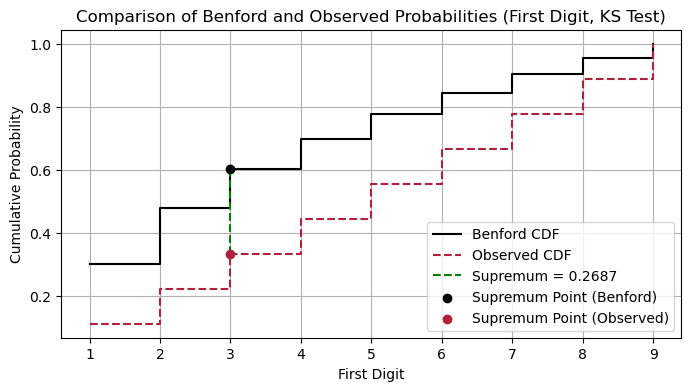

Supremum: 0.2687
First Digits of Supremum: 3
P-value (manual calculation): 0.0000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=1:
Alpha level: 0.001000
Alpha level: 0.010000
Alpha level: 0.050000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=3:
Alpha level: 0.000333
Alpha level: 0.003333
Alpha level: 0.016667

Total observations (n): 10000


In [238]:
# Compute Bonferroni-adjusted alpha levels for different num_tests
alpha_levels_results = {}
for num_tests in [1, 3]:
    alpha_levels_results[num_tests] = apply_bonferroni_correction(num_tests=num_tests)

# Compute cumulative proportions for Benford's law and observed data
benford_digits = list(benford_nth_digit_probabilities(1).keys())[1:]
benford_probs = list(benford_nth_digit_probabilities(1).values())[1:]
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_probs = uniform_first_digit
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the KS statistic manually
supremum, supremum_index = calculate_ks_manually(benford_cumulative, election_cumulative)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Calculate the theoretical p-value manually
n = 10000  # Total observations
p_value_manual = manual_ks_p_value(supremum, n)

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
plt.step(range(1, 10), benford_cumulative, where="post", label="Benford CDF", color="black")
plt.step(range(1, 10), election_cumulative, where="post", label="Observed CDF", color="#af203e", linestyle="--")

# Highlight the supremum
plt.plot(
    [supremum_x, supremum_x],
    [supremum_y_benford, supremum_y_el],
    color="green",
    linestyle="--",
    label=f"Supremum = {supremum:.4f}"
)

# Add points for the supremum
plt.scatter([supremum_x], [supremum_y_benford], color="black", zorder=5, label="Supremum Point (Benford)")
plt.scatter([supremum_x], [supremum_y_el], color="#af203e", zorder=5, label="Supremum Point (Observed)")

# Customize the plot
plt.xlabel("First Digit")
plt.ylabel("Cumulative Probability")
plt.title("Comparison of Benford and Observed Probabilities (First Digit, KS Test)")
plt.legend()
plt.grid(True)
plt.show()

# Print results
print(f"Supremum: {supremum:.4f}")
print(f"First Digits of Supremum: {supremum_x}")
print(f"P-value (manual calculation): {p_value_manual:.4f}\n")

for num_tests, adjusted_alpha_levels in alpha_levels_results.items():
    print(f"Adjusted Alpha Levels (Bonferroni Correction) for num_tests={num_tests}:")
    for alpha in adjusted_alpha_levels:
        print(f"Alpha level: {alpha:.6f}")
    print()

print(f"Total observations (n): {n}")

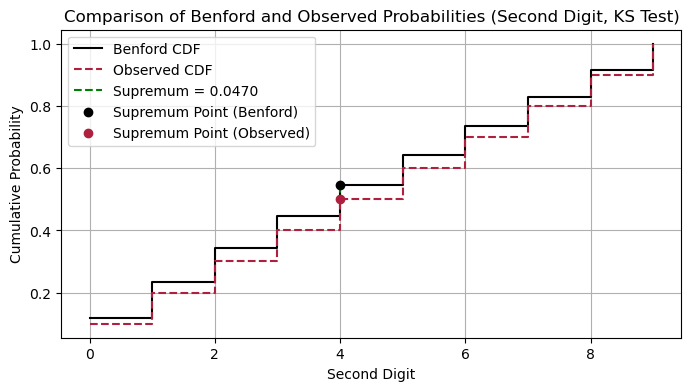

Supremum: 0.0470
First Digits of Supremum: 4
P-value (manual calculation): 0.0000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=1:
Alpha level: 0.001000
Alpha level: 0.010000
Alpha level: 0.050000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=3:
Alpha level: 0.000333
Alpha level: 0.003333
Alpha level: 0.016667

Total observations (n): 10000


In [239]:
# Compute cumulative proportions for Benford's law and observed data
benford_digits = list(benford_nth_digit_probabilities(2).keys())
benford_probs = list(benford_nth_digit_probabilities(2).values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_probs = uniform_other_digits
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the KS statistic manually
supremum, supremum_index = calculate_ks_manually(benford_cumulative, election_cumulative)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Calculate the theoretical p-value manually
n = 10000  # Total observations
p_value_manual = manual_ks_p_value(supremum, n)

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
plt.step(range(0, 10), benford_cumulative, where="post", label="Benford CDF", color="black")
plt.step(range(0, 10), election_cumulative, where="post", label="Observed CDF", color="#af203e", linestyle="--")

# Highlight the supremum
plt.plot(
    [supremum_x, supremum_x],
    [supremum_y_benford, supremum_y_el],
    color="green",
    linestyle="--",
    label=f"Supremum = {supremum:.4f}"
)

# Add points for the supremum
plt.scatter([supremum_x], [supremum_y_benford], color="black", zorder=5, label="Supremum Point (Benford)")
plt.scatter([supremum_x], [supremum_y_el], color="#af203e", zorder=5, label="Supremum Point (Observed)")

# Customize the plot
plt.xlabel("Second Digit")
plt.ylabel("Cumulative Probability")
plt.title("Comparison of Benford and Observed Probabilities (Second Digit, KS Test)")
plt.legend()
plt.grid(True)
plt.show()

# Print results
print(f"Supremum: {supremum:.4f}")
print(f"First Digits of Supremum: {supremum_x}")
print(f"P-value (manual calculation): {p_value_manual:.4f}\n")

for num_tests, adjusted_alpha_levels in alpha_levels_results.items():
    print(f"Adjusted Alpha Levels (Bonferroni Correction) for num_tests={num_tests}:")
    for alpha in adjusted_alpha_levels:
        print(f"Alpha level: {alpha:.6f}")
    print()

print(f"Total observations (n): {n}")

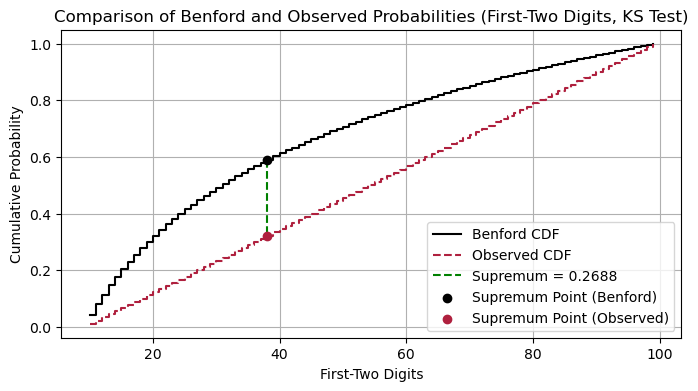

Supremum: 0.2688
First Digits of Supremum: 38
P-value (manual calculation): 0.0000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=1:
Alpha level: 0.001000
Alpha level: 0.010000
Alpha level: 0.050000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=3:
Alpha level: 0.000333
Alpha level: 0.003333
Alpha level: 0.016667

Total observations (n): 10000


In [240]:
# Compute cumulative proportions for Benford's law and observed data
benford_digits = list(Benford_theory_firsttwo_digits().keys())
benford_probs = list(Benford_theory_firsttwo_digits().values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_probs = uniform_10_99
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the KS statistic manually
supremum, supremum_index = calculate_ks_manually(benford_cumulative, election_cumulative)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Calculate the theoretical p-value manually
n = 10000  # Total observations
p_value_manual = manual_ks_p_value(supremum, n)

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
plt.step(range(10, 100), benford_cumulative, where="post", label="Benford CDF", color="black")
plt.step(range(10, 100), election_cumulative, where="post", label="Observed CDF", color="#af203e", linestyle="--")

# Highlight the supremum
plt.plot(
    [supremum_x, supremum_x],
    [supremum_y_benford, supremum_y_el],
    color="green",
    linestyle="--",
    label=f"Supremum = {supremum:.4f}"
)

# Add points for the supremum
plt.scatter([supremum_x], [supremum_y_benford], color="black", zorder=5, label="Supremum Point (Benford)")
plt.scatter([supremum_x], [supremum_y_el], color="#af203e", zorder=5, label="Supremum Point (Observed)")

# Customize the plot
plt.xlabel("First-Two Digits")
plt.ylabel("Cumulative Probability")
plt.title("Comparison of Benford and Observed Probabilities (First-Two Digits, KS Test)")
plt.legend()
plt.grid(True)
plt.show()

# Print results
print(f"Supremum: {supremum:.4f}")
print(f"First Digits of Supremum: {supremum_x}")
print(f"P-value (manual calculation): {p_value_manual:.4f}\n")

for num_tests, adjusted_alpha_levels in alpha_levels_results.items():
    print(f"Adjusted Alpha Levels (Bonferroni Correction) for num_tests={num_tests}:")
    for alpha in adjusted_alpha_levels:
        print(f"Alpha level: {alpha:.6f}")
    print()

print(f"Total observations (n): {n}")

##### Saville's regression

C:\Users\franc\AppData\Local\Temp\ipykernel_5012\4190997934.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  z_slope = (slope - 1) / slope_se  # Test for H0: b1 = 1
C:\Users\franc\AppData\Local\Temp\ipykernel_5012\4190997934.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  z_intercept = (intercept - 0) / intercept_se  # Test for H0: b0 = 0


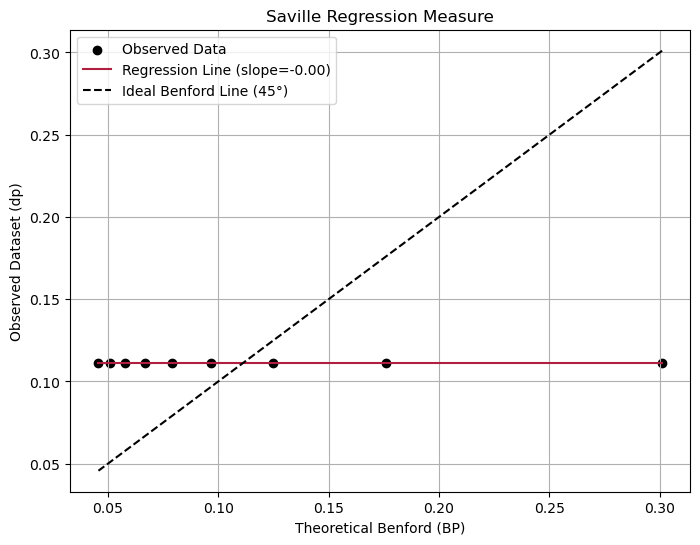

Slope (b1): -0.0000, Z-score: -inf, p-value: 0.0000
Intercept (b0): 0.1111, Z-score: inf, p-value: 0.0000
Joint Test (b0=0 and b1=1), Z-score: inf, p-value: 0.0000
Reject H0 at α=0.001: True
Reject H0 at α=0.01: True
Reject H0 at α=0.05: True


{'slope': -0.0,
 'intercept': 0.1111111111111111,
 'z_slope': -inf,
 'z_intercept': inf,
 'joint_z': inf,
 'p_slope': 0.0,
 'p_intercept': 0.0,
 'p_joint': 0.0,
 'hypothesis_results': {0.001: True, 0.01: True, 0.05: True}}

In [241]:
results = saville_regression(list(benford_nth_digit_probabilities(1).values())[1:], uniform_first_digit)
results

C:\Users\franc\AppData\Local\Temp\ipykernel_5012\4190997934.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  z_slope = (slope - 1) / slope_se  # Test for H0: b1 = 1
C:\Users\franc\AppData\Local\Temp\ipykernel_5012\4190997934.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  z_intercept = (intercept - 0) / intercept_se  # Test for H0: b0 = 0


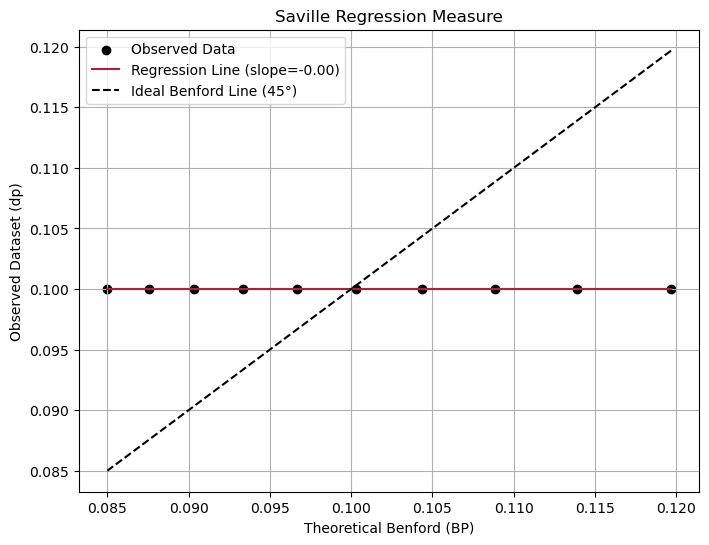

Slope (b1): -0.0000, Z-score: -inf, p-value: 0.0000
Intercept (b0): 0.1000, Z-score: inf, p-value: 0.0000
Joint Test (b0=0 and b1=1), Z-score: inf, p-value: 0.0000
Reject H0 at α=0.001: True
Reject H0 at α=0.01: True
Reject H0 at α=0.05: True


{'slope': -0.0,
 'intercept': 0.1,
 'z_slope': -inf,
 'z_intercept': inf,
 'joint_z': inf,
 'p_slope': 0.0,
 'p_intercept': 0.0,
 'p_joint': 0.0,
 'hypothesis_results': {0.001: True, 0.01: True, 0.05: True}}

In [242]:
results = saville_regression(list(benford_nth_digit_probabilities(2).values()), uniform_other_digits)
results

C:\Users\franc\AppData\Local\Temp\ipykernel_5012\4190997934.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  z_slope = (slope - 1) / slope_se  # Test for H0: b1 = 1
C:\Users\franc\AppData\Local\Temp\ipykernel_5012\4190997934.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  z_intercept = (intercept - 0) / intercept_se  # Test for H0: b0 = 0


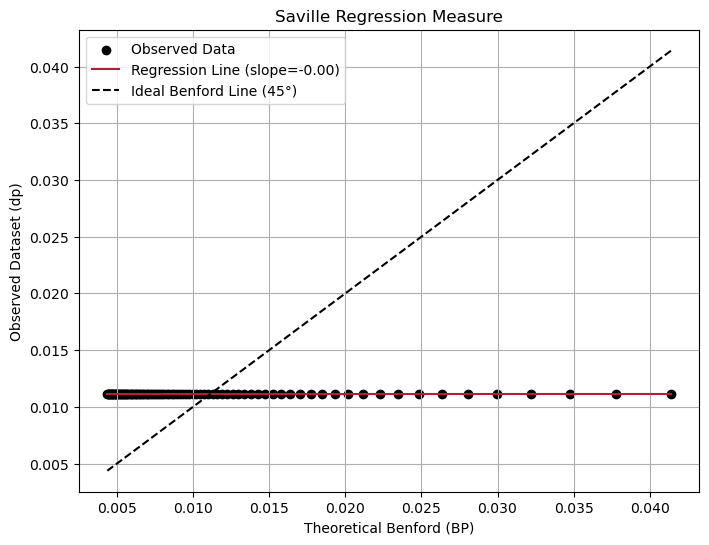

Slope (b1): -0.0000, Z-score: -inf, p-value: 0.0000
Intercept (b0): 0.0111, Z-score: inf, p-value: 0.0000
Joint Test (b0=0 and b1=1), Z-score: inf, p-value: 0.0000
Reject H0 at α=0.001: True
Reject H0 at α=0.01: True
Reject H0 at α=0.05: True


{'slope': -0.0,
 'intercept': 0.011111111111111112,
 'z_slope': -inf,
 'z_intercept': inf,
 'joint_z': inf,
 'p_slope': 0.0,
 'p_intercept': 0.0,
 'p_joint': 0.0,
 'hypothesis_results': {0.001: True, 0.01: True, 0.05: True}}

In [243]:

results = saville_regression(list(Benford_theory_firsttwo_digits().values()), uniform_10_99)
results

#### Metrics

##### MAD

Comparison between uniform first significant digit and Benford's law first significant digit

In [244]:
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(uniform_first_digit)
K=len(BP)
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")

Number of digits (K): 9
Mean Absolute Deviation (MAD) from Benford's Law: 0.05971703510991756


Comparison between uniform second significant digit and Benford's law second significant digit

In [245]:
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(uniform_other_digits)
K=len(BP)
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")

Number of digits (K): 10
Mean Absolute Deviation (MAD) from Benford's Law: 0.009405726701696863


Comparison between uniform first two significant digits and Benford's law first two significant digits

In [246]:
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(uniform_10_99)
K=len(BP)
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")

Number of digits (K): 90
Mean Absolute Deviation (MAD) from Benford's Law: 0.005974275217872824


##### FSD mean

Benford reference mean

In [247]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(benford_nth_digit_probabilities(1).values())[1:], start_digit=1, num_digits=9), " | Uniform FSD Mean:", calculate_fsd_mean(uniform_first_digit, start_digit=1, num_digits=9))

Benford's Law FSD Mean: 3.440236967123206  | Uniform FSD Mean: 5.0


In [248]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(benford_nth_digit_probabilities(2).values()), start_digit=0, num_digits=10), " | Uniform FSD Mean:", calculate_fsd_mean(uniform_other_digits, start_digit=0, num_digits=10))

Benford's Law FSD Mean: 4.1873897069289425  | Uniform FSD Mean: 4.500000000000001


In [249]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(Benford_theory_firsttwo_digits().values()), start_digit=10, num_digits=90), " | Uniform FSD Mean:", calculate_fsd_mean(uniform_10_99, start_digit=10, num_digits=90))

Benford's Law FSD Mean: 38.589759378161006  | Uniform FSD Mean: 54.5


##### Squares differences

In [250]:
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=uniform_first_digit
sum_squares_deviation(BP, AP)

543.4225399756332

In [251]:
BP=list(benford_nth_digit_probabilities(2).values())
AP=uniform_other_digits
sum_squares_deviation(BP, AP)

12.044695225412228

In [252]:
BP=list(Benford_theory_firsttwo_digits().values())
AP=uniform_10_99
sum_squares_deviation(BP, AP)

58.5872220691258

### Fibonacci sequence

In [253]:
def fibonacci(n):
    a, b = 1, 1
    for _ in range(n):
        yield a
        a, b = b, a + b


In [254]:
fib = list(fibonacci(10000))
fcount=data_digit_probabilities(fib, 1)

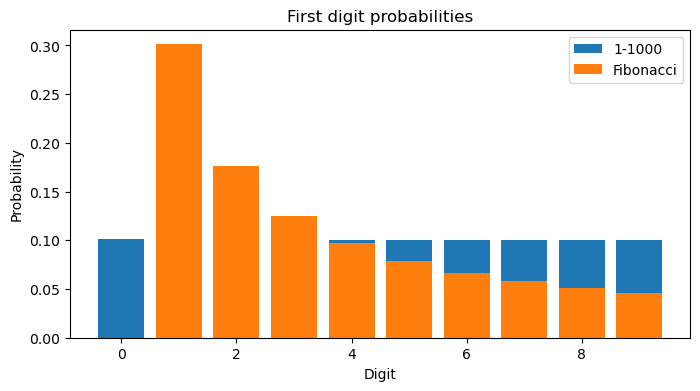

In [255]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(first_digit_probabilities_for_numbers.keys(), first_digit_probabilities_for_numbers.values(), label='1-1000')
ax.bar(fcount.keys(), fcount.values(), label='Fibonacci')
ax.set_title('First digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()

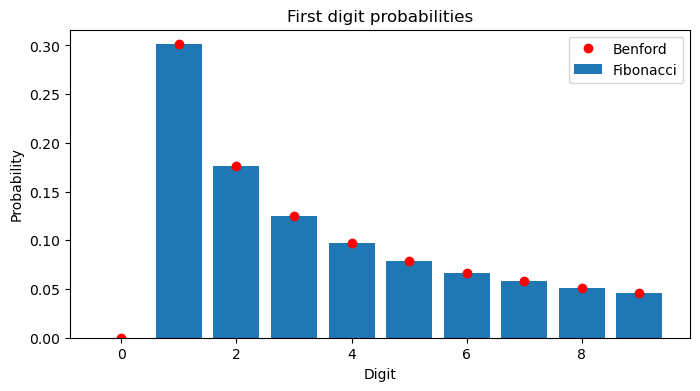

In [256]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(1).keys()), list(benford_nth_digit_probabilities(1).values()), 'ro', label='Benford')
ax.bar(fcount.keys(), fcount.values(), label='Fibonacci')
ax.set_title('First digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


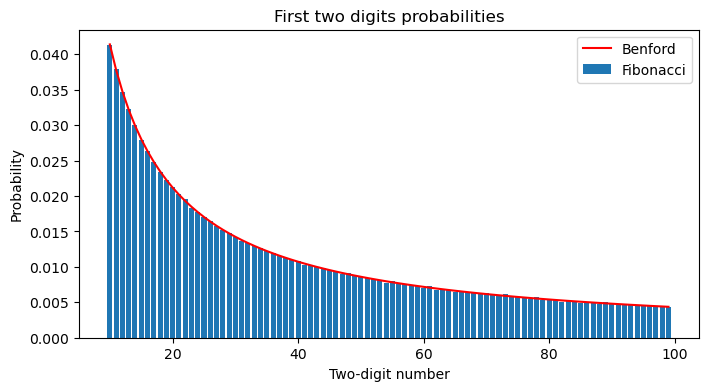

In [257]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(Benford_theory_firsttwo_digits().keys()), list(Benford_theory_firsttwo_digits().values()), 'r', label='Benford')
ax.bar(data_digit_probabilities_firsttwo(fib).keys(), data_digit_probabilities_firsttwo(fib).values(), label='Fibonacci')
ax.set_title('First two digits probabilities')
ax.set_xlabel('Two-digit number')
ax.set_ylabel('Probability')
ax.legend()
plt.show()



In [258]:
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(1).items(), columns=['First digit', 'Benford probabilities'])
Benford_theory['Fibonacci\'s sequence probabilities'] = data_digit_probabilities(fib, 1).values()
Benford_theory['Difference'] = Benford_theory['Fibonacci\'s sequence probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory

,First digit,Benford probabilities,Fibonacci's sequence probabilities,Difference
0,0,0.000000,0.0000,0.000000
1,1,0.301030,0.3011,0.000070
2,2,0.176091,0.1762,0.000109
3,3,0.124939,0.1250,0.000061
4,4,0.096910,0.0968,-0.000110
5,5,0.079181,0.0792,0.000019
6,6,0.066947,0.0668,-0.000147
7,7,0.057992,0.0580,0.000008
8,8,0.051153,0.0513,0.000147
9,9,0.045757,0.0456,-0.000157


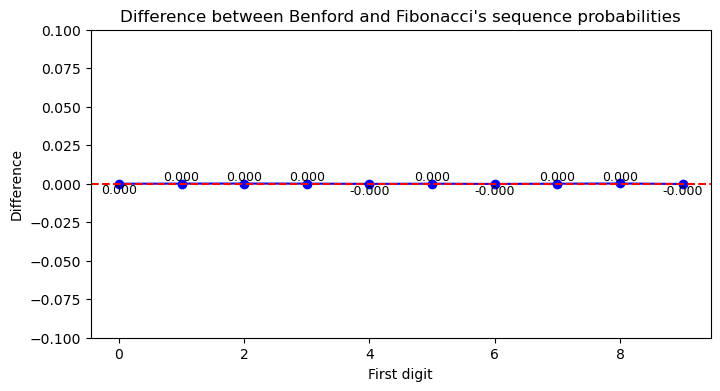

In [259]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Benford_theory['First digit'], Benford_theory['Difference'], 'bo-')
ax.axhline(0, color='red', linestyle='--')
ax.set_title('Difference between Benford and Fibonacci\'s sequence probabilities')
ax.set_xlabel('First digit')
ax.set_ylabel('Difference')

for i, (x, y) in enumerate(zip(Benford_theory['First digit'], Benford_theory['Difference'])):
    ax.text(x, y, f'{y:.3f}', ha='center', va='bottom' if y > 0 else 'top', fontsize=9, color='black')

ax.set_ylim(-0.1, 0.1)
plt.show()


In [260]:
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities_gen(6,1).items(), columns=['First digit', 'Benford probabilities'])
Benford_theory['Fibonacci\'s sequence probabilities'] = data_digit_probabilities_gen(fib, 6,1).values()
Benford_theory['Difference'] = Benford_theory['Fibonacci\'s sequence probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory

,First digit,Benford probabilities,Fibonacci's sequence probabilities,Difference
0,0,0.000000,0.000000,0.000000
1,1,0.386853,0.386869,0.000016
2,2,0.226294,0.226391,0.000096
3,3,0.160558,0.160606,0.000048
4,4,0.124539,0.124374,-0.000165
5,5,0.101756,0.101760,0.000005


#### Statistical tests

##### Z-Statistic

In [261]:
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(fib, 1).values())[1:]
N=len(fib)
z_value = calculate_z_statistic(AP, BP, N)
print(f"Z-statistic value: {z_value}")


N: 10000
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.3011
  Expected proportion (BP): 0.3010
  Z-statistic: 0.0044
  p-value: 0.996520
  Critical value at alpha=0.10000%: 3.2905
  Fail to reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Fail to reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Fail to reject null hypothesis at alpha=5.00000%
Digit 2:
  Actual proportion (DP): 0.1762
  Expected proportion (BP): 0.1761
  Z-statistic: 0.0154
  p-value: 0.987696
  Critical value at alpha=0.10000%: 3.2905
  Fail to reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Fail to reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Fail to reject null hypothesis at alpha=5.00000%
Digit 3:
  Actual proportion (DP): 0.1250
  Expected proportion (BP): 0.1249
  Z-statistic: 0.0034
  p-value: 0.997282
  Critical value at alpha=0.10000%:

In [262]:
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(fib, 2).values())
N=len(fib)
z_value = calculate_z_statistic(AP, BP, N)
print(f"Z-statistic value: {z_value}")


N: 10000
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.1198
  Expected proportion (BP): 0.1197
  Z-statistic: 0.0131
  p-value: 0.989530
  Critical value at alpha=0.10000%: 3.2905
  Fail to reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Fail to reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Fail to reject null hypothesis at alpha=5.00000%
Digit 2:
  Actual proportion (DP): 0.1139
  Expected proportion (BP): 0.1139
  Z-statistic: 0.0069
  p-value: 0.994529
  Critical value at alpha=0.10000%: 3.2905
  Fail to reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Fail to reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Fail to reject null hypothesis at alpha=5.00000%
Digit 3:
  Actual proportion (DP): 0.1086
  Expected proportion (BP): 0.1088
  Z-statistic: 0.0663
  p-value: 0.947167
  Critical value at alpha=0.10000%:

In [263]:
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(fib).values())
N=len(fib)

z_value = calculate_z_statistic(AP, BP, N)
print(f"Z-statistic value: {z_value}")

N: 10000
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.0413
  Expected proportion (BP): 0.0414
  Z-statistic: 0.0090
  p-value: 0.992834
  Critical value at alpha=0.10000%: 3.2905
  Fail to reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Fail to reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Fail to reject null hypothesis at alpha=5.00000%
Digit 2:
  Actual proportion (DP): 0.0379
  Expected proportion (BP): 0.0378
  Z-statistic: 0.0442
  p-value: 0.964783
  Critical value at alpha=0.10000%: 3.2905
  Fail to reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Fail to reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Fail to reject null hypothesis at alpha=5.00000%
Digit 3:
  Actual proportion (DP): 0.0347
  Expected proportion (BP): 0.0348
  Z-statistic: 0.0225
  p-value: 0.982023
  Critical value at alpha=0.10000%:

##### Chi squared test

In [264]:
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(fib, 1).values())[1:]
N=len(fib)
calculate_chi_square(AP, BP, N)


N: 10000
Chi-Square statistic: 0.0153
p-value: 1.000000
At alpha=0.001000: Fail to reject the null hypothesis
At alpha=0.010000: Fail to reject the null hypothesis
At alpha=0.050000: Fail to reject the null hypothesis


({0.001: {'chi_square': 0.015330245678050618,
   'p_value': '1.000000',
   'decision': 'Fail to reject the null hypothesis',
   'degrees of freedom': 8},
  0.01: {'chi_square': 0.015330245678050618,
   'p_value': '1.000000',
   'decision': 'Fail to reject the null hypothesis',
   'degrees of freedom': 8},
  0.05: {'chi_square': 0.015330245678050618,
   'p_value': '1.000000',
   'decision': 'Fail to reject the null hypothesis',
   'degrees of freedom': 8}},
 0.015330245678050618,
 0.999999999857044)

In [265]:
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(fib, 2).values())
N=len(fib)
calculate_chi_square(AP, BP, N)

N: 10000
Chi-Square statistic: 0.0367
p-value: 1.000000
At alpha=0.001000: Fail to reject the null hypothesis
At alpha=0.010000: Fail to reject the null hypothesis
At alpha=0.050000: Fail to reject the null hypothesis


({0.001: {'chi_square': 0.036684439117149144,
   'p_value': '1.000000',
   'decision': 'Fail to reject the null hypothesis',
   'degrees of freedom': 9},
  0.01: {'chi_square': 0.036684439117149144,
   'p_value': '1.000000',
   'decision': 'Fail to reject the null hypothesis',
   'degrees of freedom': 9},
  0.05: {'chi_square': 0.036684439117149144,
   'p_value': '1.000000',
   'decision': 'Fail to reject the null hypothesis',
   'degrees of freedom': 9}},
 0.036684439117149144,
 0.99999999971149)

In [266]:
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(fib).values())
N=len(fib)
calculate_chi_square(AP, BP, N)

N: 10000
Chi-Square statistic: 1.3222
p-value: 1.000000
At alpha=0.001000: Fail to reject the null hypothesis
At alpha=0.010000: Fail to reject the null hypothesis
At alpha=0.050000: Fail to reject the null hypothesis


({0.001: {'chi_square': 1.322200666733364,
   'p_value': '1.000000',
   'decision': 'Fail to reject the null hypothesis',
   'degrees of freedom': 89},
  0.01: {'chi_square': 1.322200666733364,
   'p_value': '1.000000',
   'decision': 'Fail to reject the null hypothesis',
   'degrees of freedom': 89},
  0.05: {'chi_square': 1.322200666733364,
   'p_value': '1.000000',
   'decision': 'Fail to reject the null hypothesis',
   'degrees of freedom': 89}},
 1.322200666733364,
 1.0)

##### Kolmorogov-Smirnov test

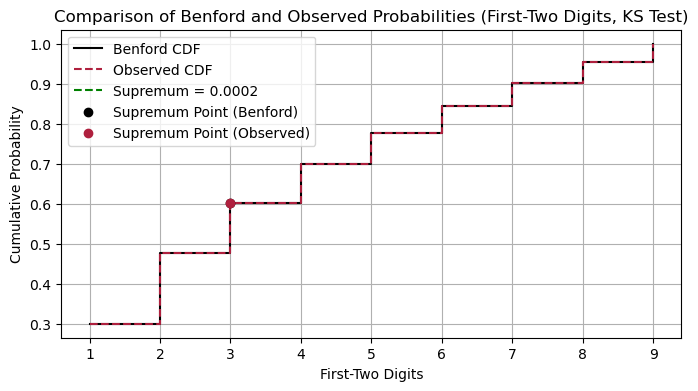

Supremum: 0.0002
First Digits of Supremum: 3
P-value (manual calculation): 1.0000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=1:
Alpha level: 0.001000
Alpha level: 0.010000
Alpha level: 0.050000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=3:
Alpha level: 0.000333
Alpha level: 0.003333
Alpha level: 0.016667

Total observations (n): 10000


In [267]:
# Compute cumulative proportions for Benford's law and observed data
benford_digits = list(benford_nth_digit_probabilities(1).keys())[1:]
benford_probs = list(benford_nth_digit_probabilities(1).values())[1:]
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities(fib, 1).keys())[1:]
election_probs = list(data_digit_probabilities(fib, 1).values())[1:]
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the KS statistic manually
supremum, supremum_index = calculate_ks_manually(benford_cumulative, election_cumulative)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Calculate the theoretical p-value manually
n = 10000  # Total observations
p_value_manual = manual_ks_p_value(supremum, n)

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
plt.step(range(1, 10), benford_cumulative, where="post", label="Benford CDF", color="black")
plt.step(range(1, 10), election_cumulative, where="post", label="Observed CDF", color="#af203e", linestyle="--")

# Highlight the supremum
plt.plot(
    [supremum_x, supremum_x],
    [supremum_y_benford, supremum_y_el],
    color="green",
    linestyle="--",
    label=f"Supremum = {supremum:.4f}"
)

# Add points for the supremum
plt.scatter([supremum_x], [supremum_y_benford], color="black", zorder=5, label="Supremum Point (Benford)")
plt.scatter([supremum_x], [supremum_y_el], color="#af203e", zorder=5, label="Supremum Point (Observed)")

# Customize the plot
plt.xlabel("First-Two Digits")
plt.ylabel("Cumulative Probability")
plt.title("Comparison of Benford and Observed Probabilities (First-Two Digits, KS Test)")
plt.legend()
plt.grid(True)
plt.show()

# Print results
print(f"Supremum: {supremum:.4f}")
print(f"First Digits of Supremum: {supremum_x}")
print(f"P-value (manual calculation): {p_value_manual:.4f}\n")

for num_tests, adjusted_alpha_levels in alpha_levels_results.items():
    print(f"Adjusted Alpha Levels (Bonferroni Correction) for num_tests={num_tests}:")
    for alpha in adjusted_alpha_levels:
        print(f"Alpha level: {alpha:.6f}")
    print()

print(f"Total observations (n): {n}")

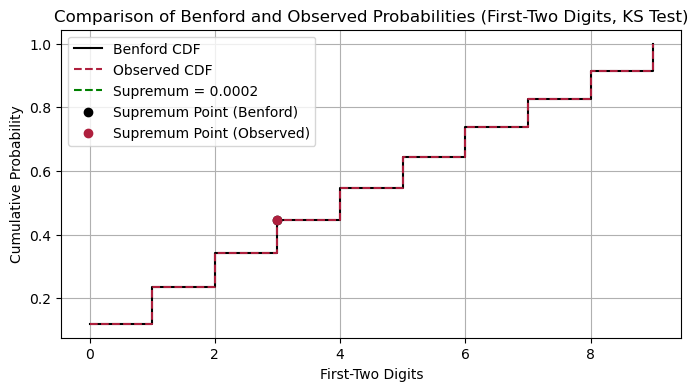

Supremum: 0.0002
First Digits of Supremum: 3
P-value (manual calculation): 1.0000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=1:
Alpha level: 0.001000
Alpha level: 0.010000
Alpha level: 0.050000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=3:
Alpha level: 0.000333
Alpha level: 0.003333
Alpha level: 0.016667

Total observations (n): 10000


In [268]:
# Compute cumulative proportions for Benford's law and observed data
benford_digits = list(benford_nth_digit_probabilities(2).keys())
benford_probs = list(benford_nth_digit_probabilities(2).values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities(fib,2).keys())
election_probs = list(data_digit_probabilities(fib,2).values())
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]


# Calculate the KS statistic manually
supremum, supremum_index = calculate_ks_manually(benford_cumulative, election_cumulative)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Calculate the theoretical p-value manually
n = 10000  # Total observations
p_value_manual = manual_ks_p_value(supremum, n)

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
plt.step(range(0, 10), benford_cumulative, where="post", label="Benford CDF", color="black")
plt.step(range(0, 10), election_cumulative, where="post", label="Observed CDF", color="#af203e", linestyle="--")

# Highlight the supremum
plt.plot(
    [supremum_x, supremum_x],
    [supremum_y_benford, supremum_y_el],
    color="green",
    linestyle="--",
    label=f"Supremum = {supremum:.4f}"
)

# Add points for the supremum
plt.scatter([supremum_x], [supremum_y_benford], color="black", zorder=5, label="Supremum Point (Benford)")
plt.scatter([supremum_x], [supremum_y_el], color="#af203e", zorder=5, label="Supremum Point (Observed)")

# Customize the plot
plt.xlabel("First-Two Digits")
plt.ylabel("Cumulative Probability")
plt.title("Comparison of Benford and Observed Probabilities (First-Two Digits, KS Test)")
plt.legend()
plt.grid(True)
plt.show()

# Print results
print(f"Supremum: {supremum:.4f}")
print(f"First Digits of Supremum: {supremum_x}")
print(f"P-value (manual calculation): {p_value_manual:.4f}\n")

for num_tests, adjusted_alpha_levels in alpha_levels_results.items():
    print(f"Adjusted Alpha Levels (Bonferroni Correction) for num_tests={num_tests}:")
    for alpha in adjusted_alpha_levels:
        print(f"Alpha level: {alpha:.6f}")
    print()

print(f"Total observations (n): {n}")

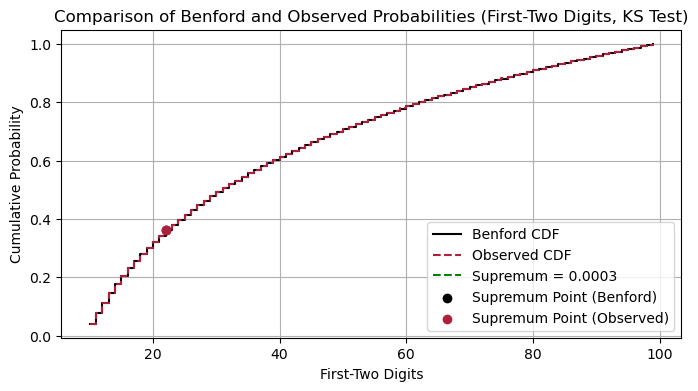

Supremum: 0.0003
First Digits of Supremum: 22
P-value (manual calculation): 1.0000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=1:
Alpha level: 0.001000
Alpha level: 0.010000
Alpha level: 0.050000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=3:
Alpha level: 0.000333
Alpha level: 0.003333
Alpha level: 0.016667

Total observations (n): 10000


In [269]:
# Compute cumulative proportions for Benford's law and observed data
benford_digits = list(Benford_theory_firsttwo_digits().keys())
benford_probs = list(Benford_theory_firsttwo_digits().values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities_firsttwo(fib).keys())
election_probs = list(data_digit_probabilities_firsttwo(fib).values())
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]


# Calculate the KS statistic manually
supremum, supremum_index = calculate_ks_manually(benford_cumulative, election_cumulative)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Calculate the theoretical p-value manually
n = 10000  # Total observations
p_value_manual = manual_ks_p_value(supremum, n)

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
plt.step(range(10, 100), benford_cumulative, where="post", label="Benford CDF", color="black")
plt.step(range(10, 100), election_cumulative, where="post", label="Observed CDF", color="#af203e", linestyle="--")

# Highlight the supremum
plt.plot(
    [supremum_x, supremum_x],
    [supremum_y_benford, supremum_y_el],
    color="green",
    linestyle="--",
    label=f"Supremum = {supremum:.4f}"
)

# Add points for the supremum
plt.scatter([supremum_x], [supremum_y_benford], color="black", zorder=5, label="Supremum Point (Benford)")
plt.scatter([supremum_x], [supremum_y_el], color="#af203e", zorder=5, label="Supremum Point (Observed)")

# Customize the plot
plt.xlabel("First-Two Digits")
plt.ylabel("Cumulative Probability")
plt.title("Comparison of Benford and Observed Probabilities (First-Two Digits, KS Test)")
plt.legend()
plt.grid(True)
plt.show()

# Print results
print(f"Supremum: {supremum:.4f}")
print(f"First Digits of Supremum: {supremum_x}")
print(f"P-value (manual calculation): {p_value_manual:.4f}\n")

for num_tests, adjusted_alpha_levels in alpha_levels_results.items():
    print(f"Adjusted Alpha Levels (Bonferroni Correction) for num_tests={num_tests}:")
    for alpha in adjusted_alpha_levels:
        print(f"Alpha level: {alpha:.6f}")
    print()

print(f"Total observations (n): {n}")

##### Saville regression

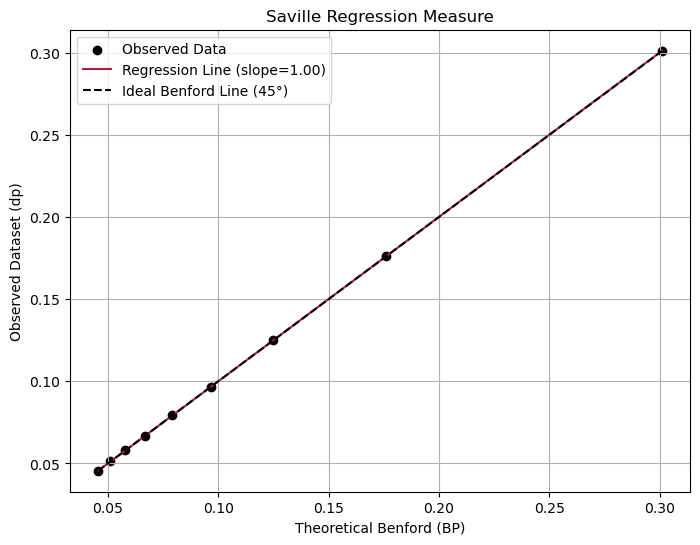

Slope (b1): 1.0005, Z-score: 1.1560, p-value: 0.2477
Intercept (b0): -0.0001, Z-score: -0.9473, p-value: 0.3435
Joint Test (b0=0 and b1=1), Z-score: 1.4946, p-value: 0.1350
Reject H0 at α=0.001: False
Reject H0 at α=0.01: False
Reject H0 at α=0.05: False


{'slope': 1.0005461108900664,
 'intercept': -6.067898778515379e-05,
 'z_slope': 1.1560263267796524,
 'z_intercept': -0.9473460913406496,
 'joint_z': 1.494610813886365,
 'p_slope': 0.24767038862776847,
 'p_intercept': 0.3434624514472635,
 'p_joint': 0.13501604226300712,
 'hypothesis_results': {0.001: False, 0.01: False, 0.05: False}}

In [270]:
saville_regression(list(benford_nth_digit_probabilities(1).values())[1:], list(data_digit_probabilities(fib, 1).values())[1:])

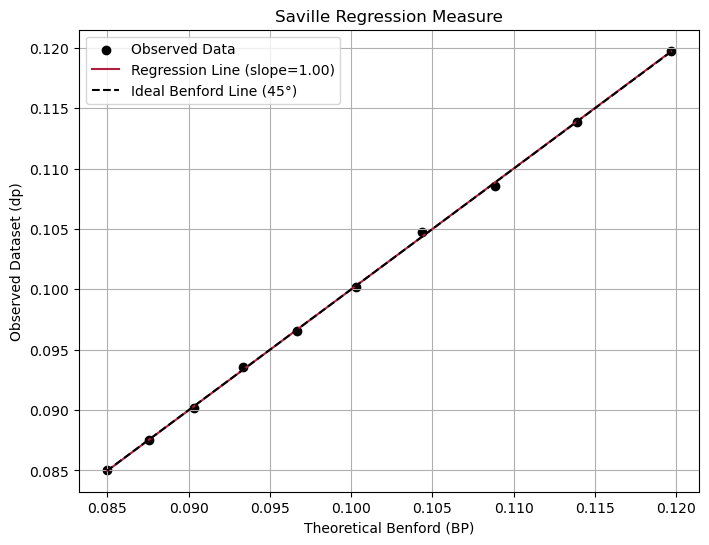

Slope (b1): 1.0013, Z-score: 0.2145, p-value: 0.8302
Intercept (b0): -0.0001, Z-score: -0.2132, p-value: 0.8312
Joint Test (b0=0 and b1=1), Z-score: 0.3025, p-value: 0.7623
Reject H0 at α=0.001: False
Reject H0 at α=0.01: False
Reject H0 at α=0.05: False


{'slope': 1.0013324397553787,
 'intercept': -0.0001332439755378223,
 'z_slope': 0.21450365510276379,
 'z_intercept': -0.2132233932612732,
 'joint_z': 0.3024500512254825,
 'p_slope': 0.8301543169393291,
 'p_intercept': 0.8311527226109954,
 'p_joint': 0.7623090047660388,
 'hypothesis_results': {0.001: False, 0.01: False, 0.05: False}}

In [271]:
results = saville_regression(list(benford_nth_digit_probabilities(2).values()), list(data_digit_probabilities(fib, 2).values()))
results

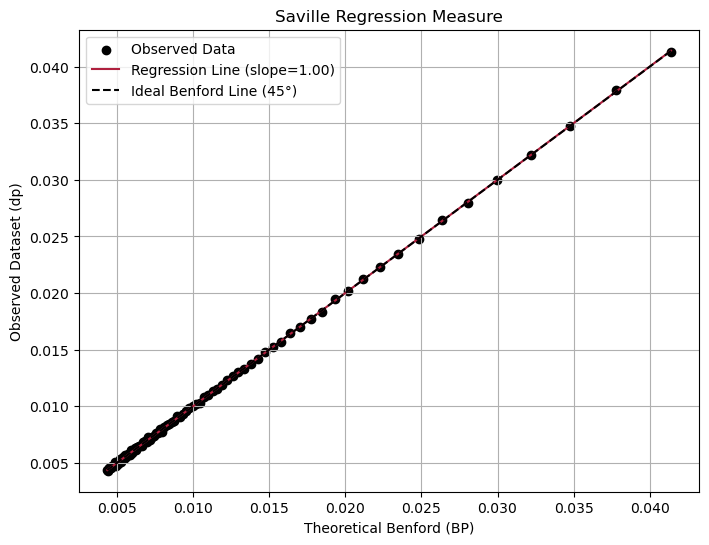

Slope (b1): 1.0005, Z-score: 0.3542, p-value: 0.7232
Intercept (b0): -0.0000, Z-score: -0.2866, p-value: 0.7744
Joint Test (b0=0 and b1=1), Z-score: 0.4556, p-value: 0.6487
Reject H0 at α=0.001: False
Reject H0 at α=0.01: False
Reject H0 at α=0.05: False


{'slope': 1.0004812448110372,
 'intercept': -5.3471645670745416e-06,
 'z_slope': 0.35415906179409634,
 'z_intercept': -0.28657500949169995,
 'joint_z': 0.4555808129366759,
 'p_slope': 0.7232196817453609,
 'p_intercept': 0.7744377517161463,
 'p_joint': 0.6486914430777355,
 'hypothesis_results': {0.001: False, 0.01: False, 0.05: False}}

In [272]:
results = saville_regression(list(Benford_theory_firsttwo_digits().values()), list(data_digit_probabilities_firsttwo(fib).values()))
results

#### Metrics

##### MAD

Comparison between Fibonacci first significant digit and Benford's law first significant digit

In [273]:
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(fib, 1).values())[1:]
K=len(BP)
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")

Number of digits (K): 9
Mean Absolute Deviation (MAD) from Benford's Law: 9.206515540995108e-05


In [274]:
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(fib, 2).values())
K=len(BP)  
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")

Number of digits (K): 10
Mean Absolute Deviation (MAD) from Benford's Law: 0.00015219369250198816


In [275]:
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(fib).values())
K=len(BP)
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")

Number of digits (K): 90
Mean Absolute Deviation (MAD) from Benford's Law: 8.210617381083443e-05


##### FSD mean

In [276]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(benford_nth_digit_probabilities(1).values())[1:], start_digit=1, num_digits=9), 
      " | Uniform FSD Mean:", calculate_fsd_mean(uniform_first_digit, start_digit=1, num_digits=9),
      " | Fibonacci FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities(fib, 1).values())[1:], start_digit=1, num_digits=9))

Benford's Law FSD Mean: 3.440236967123206  | Uniform FSD Mean: 5.0  | Fibonacci FSD Mean: 3.4393000000000002


In [277]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(benford_nth_digit_probabilities(2).values()), start_digit=0, num_digits=10), 
      " | Uniform FSD Mean:", calculate_fsd_mean(uniform_other_digits, start_digit=0, num_digits=10),
      " | Fibonacci FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities(fib, 2).values()), start_digit=0, num_digits=10))

Benford's Law FSD Mean: 4.1873897069289425  | Uniform FSD Mean: 4.500000000000001  | Fibonacci FSD Mean: 4.187012207324394


In [278]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(Benford_theory_firsttwo_digits().values()), start_digit=10, num_digits=90),
       " | Uniform FSD Mean:", calculate_fsd_mean(uniform_10_99, start_digit=10, num_digits=90), 
       " | Fibonacci FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities_firsttwo(fib).values()), start_digit=10, num_digits=90))

Benford's Law FSD Mean: 38.589759378161006  | Uniform FSD Mean: 54.5  | Fibonacci FSD Mean: 38.58064838903343


##### Squared deviation


In [279]:
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(fib, 1).values())[1:]
sum_squares_deviation(BP, AP)

0.0010109792791879685

In [280]:
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(fib, 2).values())
sum_squares_deviation(BP, AP)

0.0037394028243250043

In [281]:
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(fib).values())
sum_squares_deviation(BP, AP)

0.009533218593688232

### 2018 Italian elections

#### Data cleaning and preparation

In this cell, we select only the columns that we need for the analysis. We don't have the data for the polling stations so we use the aggregation for comune.

In [282]:
file_path = "C:/Users/franc/Documents/Università/Thesis/Benford/Codice/Dati/Camera2018_livComune.txt"
election_data_18 = pd.read_csv(file_path, sep=";", encoding='latin1')
election_data_18_region=election_data_18
election_data_18 = election_data_18[['COMUNE','VOTANTI', 'LISTA', 'COGNOME', 'NOME', 'VOTI_LISTA', 'CIRCOSCRIZIONE']]
election_data_18



,COMUNE,VOTANTI,LISTA,COGNOME,NOME,VOTI_LISTA,CIRCOSCRIZIONE
0,TORINO,124770,CASAPOUND ITALIA,ARNONE,GINO MICHELE DOMENICO,972.0,PIEMONTE 1
1,TORINO,124770,IL POPOLO DELLA FAMIGLIA,COLUCCI,VITANTONIO,765.0,PIEMONTE 1
2,TORINO,124770,NOI CON L'ITALIA - UDC,FRANCIA,MARCO,743.0,PIEMONTE 1
3,TORINO,124770,LEGA,FRANCIA,MARCO,15783.0,PIEMONTE 1
4,TORINO,124770,FORZA ITALIA,FRANCIA,MARCO,15055.0,PIEMONTE 1
...,...,...,...,...,...,...,...
133819,VILLENEUVE,705,POUR TOUS PER TUTTI PE TCHEUT,MARCOZ,GIAMPAOLO,NaN,AOSTA
133820,VILLENEUVE,705,FI -FRAT. D'IT. -MOV.NUOVA VALLE D'AOSTA,MELGARA,EDOARDO,NaN,AOSTA
133821,VILLENEUVE,705,RISPOSTA CIVICA,MINELLI,CHIARA,NaN,AOSTA
133822,VILLENEUVE,705,POTERE AL POPOLO!,RAPPAZZO,FRANCESCO,NaN,AOSTA


In [283]:
election_data_18['CIRCOSCRIZIONE'].unique()

array(['PIEMONTE 1', 'PIEMONTE 2', 'LOMBARDIA 1', 'LOMBARDIA 2',
       'LOMBARDIA 3', 'LOMBARDIA 4', 'VENETO 1', 'VENETO 2',
       'FRIULI-VENEZIA GIULIA', 'LIGURIA', 'EMILIA-ROMAGNA', 'TOSCANA',
       'UMBRIA', 'MARCHE', 'LAZIO 1', 'LAZIO 2', 'ABRUZZO', 'MOLISE',
       'CAMPANIA 1', 'CAMPANIA 2', 'PUGLIA', 'BASILICATA', 'CALABRIA',
       'SICILIA 1', 'SICILIA 2', 'SARDEGNA',
       'TRENTINO-ALTO ADIGE/S_DTIROL', 'AOSTA'], dtype=object)

In [284]:
election_data_18.loc[election_data_18['VOTANTI'].idxmin()]

COMUNE                      MONCENISIO
VOTANTI                             24
LISTA             PARTITO VALORE UMANO
COGNOME                        CARELLA
NOME                           CLAUDIA
VOTI_LISTA                         0.0
CIRCOSCRIZIONE              PIEMONTE 1
Name: 3820, dtype: object

In [285]:
election_data_18.loc[election_data_18['VOTANTI'].idxmax()]

COMUNE                        ROMA
VOTANTI                     163964
LISTA             CASAPOUND ITALIA
COGNOME                  ALTARELLI
NOME                       CLAUDIA
VOTI_LISTA                  2658.0
CIRCOSCRIZIONE             LAZIO 1
Name: 78500, dtype: object

In [286]:
#count how many unique values we have in the column 'COMUNE'
election_data_18['COMUNE'].nunique()


7951

In [287]:
election_data_18

,COMUNE,VOTANTI,LISTA,COGNOME,NOME,VOTI_LISTA,CIRCOSCRIZIONE
0,TORINO,124770,CASAPOUND ITALIA,ARNONE,GINO MICHELE DOMENICO,972.0,PIEMONTE 1
1,TORINO,124770,IL POPOLO DELLA FAMIGLIA,COLUCCI,VITANTONIO,765.0,PIEMONTE 1
2,TORINO,124770,NOI CON L'ITALIA - UDC,FRANCIA,MARCO,743.0,PIEMONTE 1
3,TORINO,124770,LEGA,FRANCIA,MARCO,15783.0,PIEMONTE 1
4,TORINO,124770,FORZA ITALIA,FRANCIA,MARCO,15055.0,PIEMONTE 1
...,...,...,...,...,...,...,...
133819,VILLENEUVE,705,POUR TOUS PER TUTTI PE TCHEUT,MARCOZ,GIAMPAOLO,NaN,AOSTA
133820,VILLENEUVE,705,FI -FRAT. D'IT. -MOV.NUOVA VALLE D'AOSTA,MELGARA,EDOARDO,NaN,AOSTA
133821,VILLENEUVE,705,RISPOSTA CIVICA,MINELLI,CHIARA,NaN,AOSTA
133822,VILLENEUVE,705,POTERE AL POPOLO!,RAPPAZZO,FRANCESCO,NaN,AOSTA


In [288]:
election_data_18.groupby('COMUNE').filter(lambda x: x.shape[0] > 25)['COMUNE'].unique()


array(['TORINO', 'SAMONE', 'CALLIANO', 'MILANO', 'LIVO', 'PEGLIO',
       'CASTRO', 'VALVERDE', 'GENOVA', 'BOLOGNA', 'FIRENZE', 'ROMA',
       'NAPOLI', 'BARI', 'PALERMO', 'SAN TEODORO'], dtype=object)

In the next cell, we group the data by comune and we sum the votes for each party, without taking into consideration the different candidates. Due to the electoral law (Rosatellum bis), the voters can't write the preference for the candidate, that are elected in the order of the blocked list, but can choose only the party. So we will consider only the votes for the party, for each comune.

In [289]:
#group by circoscrizione, comune and lista and sum the VOTI_LISTA
election_18_grouped = election_data_18.groupby(['CIRCOSCRIZIONE','COMUNE', 'LISTA'])['VOTI_LISTA'].sum().reset_index()
election_18_grouped


,CIRCOSCRIZIONE,COMUNE,LISTA,VOTI_LISTA
0,ABRUZZO,ABBATEGGIO,+EUROPA,6.0
1,ABRUZZO,ABBATEGGIO,10 VOLTE MEGLIO,0.0
2,ABRUZZO,ABBATEGGIO,CASAPOUND ITALIA,14.0
3,ABRUZZO,ABBATEGGIO,CIVICA POPOLARE LORENZIN,1.0
4,ABRUZZO,ABBATEGGIO,FORZA ITALIA,28.0
...,...,...,...,...
133342,VENETO 2,ZUGLIANO,NOI CON L'ITALIA - UDC,28.0
133343,VENETO 2,ZUGLIANO,PARTITO DEMOCRATICO,652.0
133344,VENETO 2,ZUGLIANO,PARTITO REPUBBLICANO ITALIANO - ALA,3.0
133345,VENETO 2,ZUGLIANO,PARTITO VALORE UMANO,22.0


In order to apply the Benford's law, we need to consider the first significant digit of the votes. For doing this, we have to removes all the parties that has zero votes.

In [290]:
#count the values of VOTI_LISTA equal to 0
election_18_grouped[election_18_grouped['VOTI_LISTA'] == 0].shape[0]

11198

In [291]:
election_18_grouped = election_18_grouped[election_18_grouped['VOTI_LISTA'] != 0].reset_index(drop=True)
election_18_grouped['VOTI_LISTA'] = election_18_grouped['VOTI_LISTA'].astype(int)
print(election_18_grouped)


       CIRCOSCRIZIONE      COMUNE                                 LISTA  \
0             ABRUZZO  ABBATEGGIO                               +EUROPA   
1             ABRUZZO  ABBATEGGIO                      CASAPOUND ITALIA   
2             ABRUZZO  ABBATEGGIO              CIVICA POPOLARE LORENZIN   
3             ABRUZZO  ABBATEGGIO                          FORZA ITALIA   
4             ABRUZZO  ABBATEGGIO  FRATELLI D'ITALIA CON GIORGIA MELONI   
...               ...         ...                                   ...   
122144       VENETO 2    ZUGLIANO                NOI CON L'ITALIA - UDC   
122145       VENETO 2    ZUGLIANO                   PARTITO DEMOCRATICO   
122146       VENETO 2    ZUGLIANO   PARTITO REPUBBLICANO ITALIANO - ALA   
122147       VENETO 2    ZUGLIANO                  PARTITO VALORE UMANO   
122148       VENETO 2    ZUGLIANO                     POTERE AL POPOLO!   

        VOTI_LISTA  
0                6  
1               14  
2                1  
3              

We have a skewed distribution with a lot of VOTI_LISTA equals to 1.

In [292]:
election_18_grouped[election_18_grouped['VOTI_LISTA'] == 1].shape[0]


8633

In [293]:
election_18_grouped['LISTA'].unique()

array(['+EUROPA', 'CASAPOUND ITALIA', 'CIVICA POPOLARE LORENZIN',
       'FORZA ITALIA', "FRATELLI D'ITALIA CON GIORGIA MELONI",
       'ITALIA AGLI ITALIANI', 'ITALIA EUROPA INSIEME', 'LEGA',
       'LIBERI E UGUALI', 'MOVIMENTO 5 STELLE', "NOI CON L'ITALIA - UDC",
       'PARTITO DEMOCRATICO', 'POTERE AL POPOLO!', 'PARTITO COMUNISTA',
       'PARTITO VALORE UMANO', '10 VOLTE MEGLIO',
       'IL POPOLO DELLA FAMIGLIA', "BLOCCO NAZIONALE PER LE LIBERTA'",
       'PER UNA SINISTRA RIVOLUZIONARIA',
       'LISTA DEL POPOLO PER LA COSTITUZIONE',
       'PARTITO REPUBBLICANO ITALIANO - ALA', "PATTO PER L'AUTONOMIA",
       'SIAMO', 'RINASCIMENTO MIR', 'GRANDE NORD', 'ITALIA NEL CUORE',
       'AUTODETERMINATZIONE', 'SVP - PATT'], dtype=object)

In [294]:
election_18_grouped[election_18_grouped['COMUNE'] == 'ROMA'].shape[0]

19

In [295]:
election_18_grouped.loc[election_18_grouped['VOTI_LISTA'].idxmax()]

CIRCOSCRIZIONE               LAZIO 1
COMUNE                          ROMA
LISTA             MOVIMENTO 5 STELLE
VOTI_LISTA                    423382
Name: 33217, dtype: object

In [296]:
election_18_grouped

,CIRCOSCRIZIONE,COMUNE,LISTA,VOTI_LISTA
0,ABRUZZO,ABBATEGGIO,+EUROPA,6
1,ABRUZZO,ABBATEGGIO,CASAPOUND ITALIA,14
2,ABRUZZO,ABBATEGGIO,CIVICA POPOLARE LORENZIN,1
3,ABRUZZO,ABBATEGGIO,FORZA ITALIA,28
4,ABRUZZO,ABBATEGGIO,FRATELLI D'ITALIA CON GIORGIA MELONI,6
...,...,...,...,...
122144,VENETO 2,ZUGLIANO,NOI CON L'ITALIA - UDC,28
122145,VENETO 2,ZUGLIANO,PARTITO DEMOCRATICO,652
122146,VENETO 2,ZUGLIANO,PARTITO REPUBBLICANO ITALIANO - ALA,3
122147,VENETO 2,ZUGLIANO,PARTITO VALORE UMANO,22


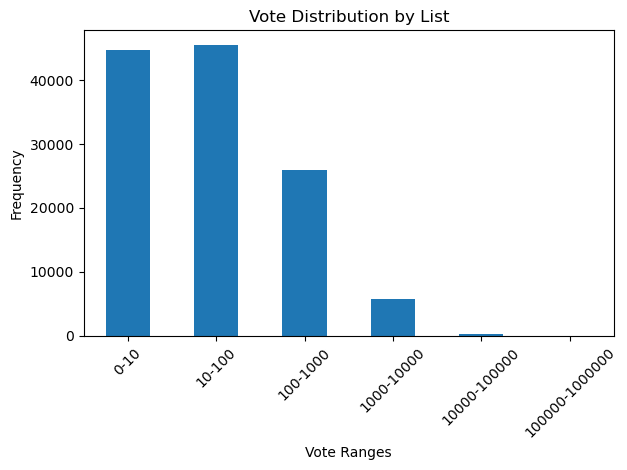

In [297]:
value_counts = election_18_grouped['VOTI_LISTA'].value_counts(
    bins=[1, 10, 100, 1000, 10000, 100000, 1000000], 
    sort=False
)

value_counts.plot.bar()

plt.xlabel('Vote Ranges')
plt.ylabel('Frequency')
plt.title('Vote Distribution by List')
plt.xticks(
    ticks=range(len(value_counts.index)),
    labels=[f'{int(interval.left)}-{int(interval.right)}' for interval in value_counts.index],
    rotation=45
)
plt.tight_layout()
plt.show()



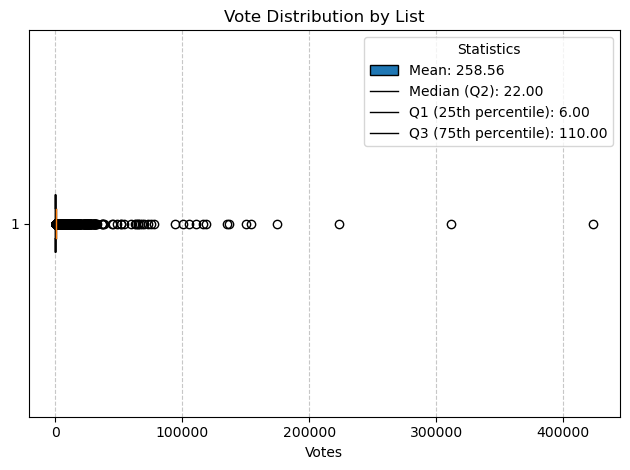

In [298]:
q1 = election_18_grouped['VOTI_LISTA'].quantile(0.25)
median_value = election_18_grouped['VOTI_LISTA'].median()
q3 = election_18_grouped['VOTI_LISTA'].quantile(0.75)
mean_value = election_18_grouped['VOTI_LISTA'].mean()

# box plot
plt.boxplot(election_18_grouped['VOTI_LISTA'], vert=False, patch_artist=True, notch=True)

plt.legend(
    labels=[
        f'Mean: {mean_value:.2f}', 
        f'Median (Q2): {median_value:.2f}', 
        f'Q1 (25th percentile): {q1:.2f}', 
        f'Q3 (75th percentile): {q3:.2f}'
    ],
    loc='best',
    title='Statistics'
)

plt.xlabel('Votes')
plt.title('Vote Distribution by List')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


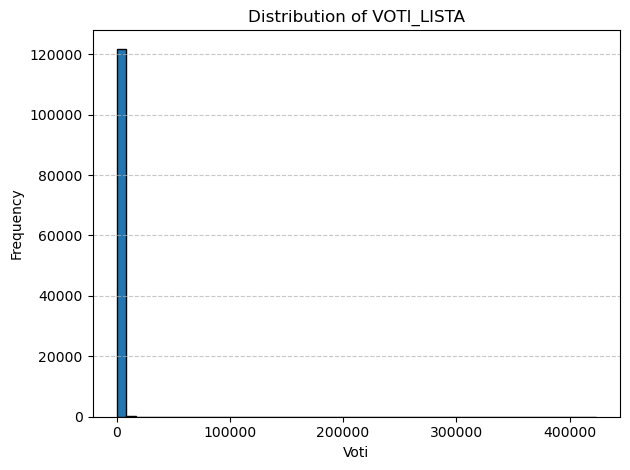

In [299]:
plt.hist(election_18_grouped['VOTI_LISTA'], bins=50, edgecolor='black')
plt.title('Distribution of VOTI_LISTA')
plt.xlabel('Voti')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


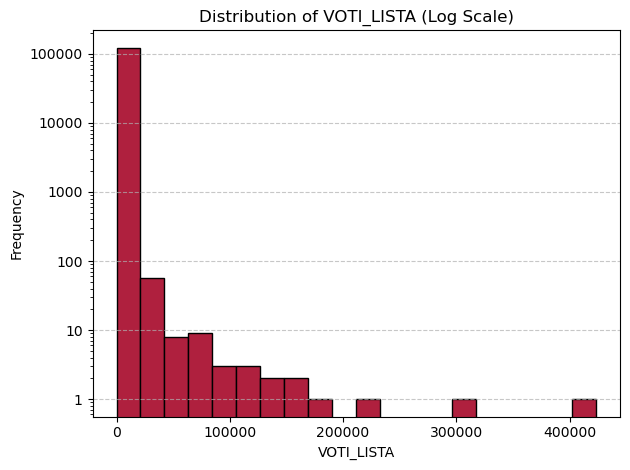

Bin 1 (1.00 - 21170.05): 122061
Bin 2 (21170.05 - 42339.10): 57
Bin 3 (42339.10 - 63508.15): 8
Bin 4 (63508.15 - 84677.20): 9
Bin 5 (84677.20 - 105846.25): 3
Bin 6 (105846.25 - 127015.30): 3
Bin 7 (127015.30 - 148184.35): 2
Bin 8 (148184.35 - 169353.40): 2
Bin 9 (169353.40 - 190522.45): 1
Bin 10 (190522.45 - 211691.50): 0
Bin 11 (211691.50 - 232860.55): 1
Bin 12 (232860.55 - 254029.60): 0
Bin 13 (254029.60 - 275198.65): 0
Bin 14 (275198.65 - 296367.70): 0
Bin 15 (296367.70 - 317536.75): 1
Bin 16 (317536.75 - 338705.80): 0
Bin 17 (338705.80 - 359874.85): 0
Bin 18 (359874.85 - 381043.90): 0
Bin 19 (381043.90 - 402212.95): 0
Bin 20 (402212.95 - 423382.00): 1


In [300]:
plt.hist(election_18_grouped['VOTI_LISTA'], bins=20, edgecolor='black', log=True, color='#af203e')
plt.title('Distribution of VOTI_LISTA (Log Scale)')
plt.xlabel('VOTI_LISTA')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.tight_layout()
plt.show()

hist, bin_edges = np.histogram(election_18_grouped['VOTI_LISTA'], bins=20)

for i in range(len(bin_edges) - 1):
    print(f"Bin {i+1} ({bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}): {hist[i]}")



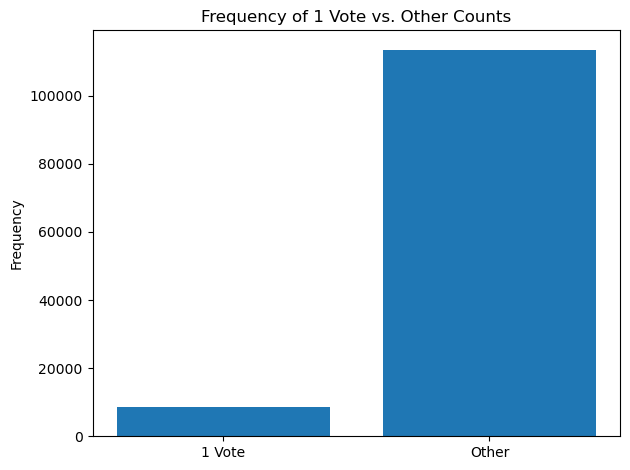

In [301]:
value_counts = election_18_grouped['VOTI_LISTA'].value_counts()

plt.bar(['1 Vote', 'Other'], [value_counts.get(1, 0), value_counts.sum() - value_counts.get(1, 0)])
plt.title('Frequency of 1 Vote vs. Other Counts')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [302]:
election_18_grouped['VOTI_LISTA'].describe()


count    122149.000000
mean        258.557483
std        2391.581247
min           1.000000
25%           6.000000
50%          22.000000
75%         110.000000
max      423382.000000
Name: VOTI_LISTA, dtype: float64

###### Some preliminar tests


In [303]:
election_18_grouped[election_18_grouped['VOTI_LISTA'] == 0].shape[0]

0

In [304]:
election_18_grouped[election_18_grouped['VOTI_LISTA'] < 0].shape[0]

0

In [305]:
deciles=election_18_grouped['VOTI_LISTA'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

print("Deciles of VOTI_LISTA:")
print(deciles)

Deciles of VOTI_LISTA:
0.1      2.0
0.2      4.0
0.3      7.0
0.4     13.0
0.5     22.0
0.6     39.0
0.7     75.0
0.8    166.0
0.9    459.0
Name: VOTI_LISTA, dtype: float64


In [306]:
quartiles = election_18_grouped['VOTI_LISTA'].quantile([0.25, 0.5, 0.75])

print("Quartiles of VOTI_LISTA:")
print(quartiles)

Quartiles of VOTI_LISTA:
0.25      6.0
0.50     22.0
0.75    110.0
Name: VOTI_LISTA, dtype: float64


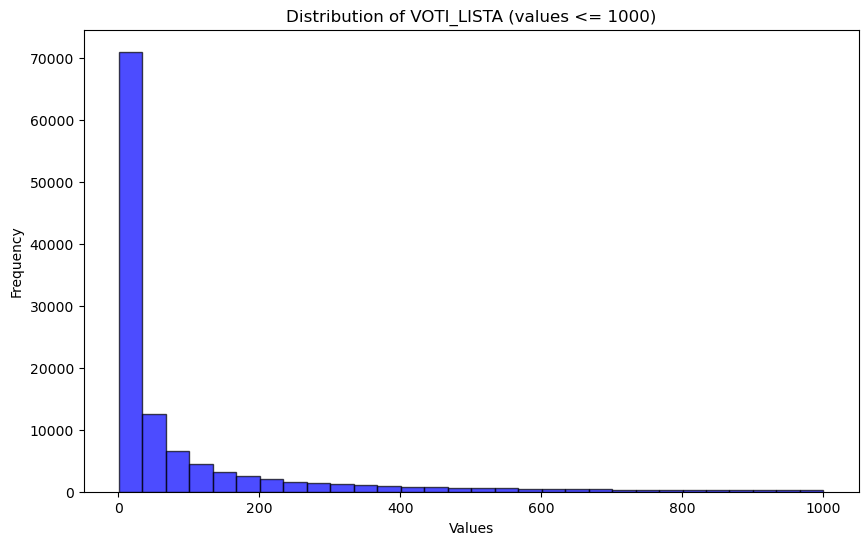

mean 90.16322964901107 median 19.0


In [307]:
voti_lista=election_18_grouped['VOTI_LISTA']

filtered_voti_lista = election_18_grouped['VOTI_LISTA'][election_18_grouped['VOTI_LISTA'] <= 1000]

plt.figure(figsize=(10, 6))
plt.hist(filtered_voti_lista, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of VOTI_LISTA (values <= 1000)")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

print("mean", filtered_voti_lista.mean(), "median", filtered_voti_lista.median())

If the mean is greater than the median, the distribution is right-skewed. If the mean is less than the median, the distribution is left-skewed. If the mean is equal to the median, the distribution is perfectly symmetrical.

Skewness of VOTI_LISTA

In [308]:

election_18_grouped['VOTI_LISTA'].skew()


88.58158286852981

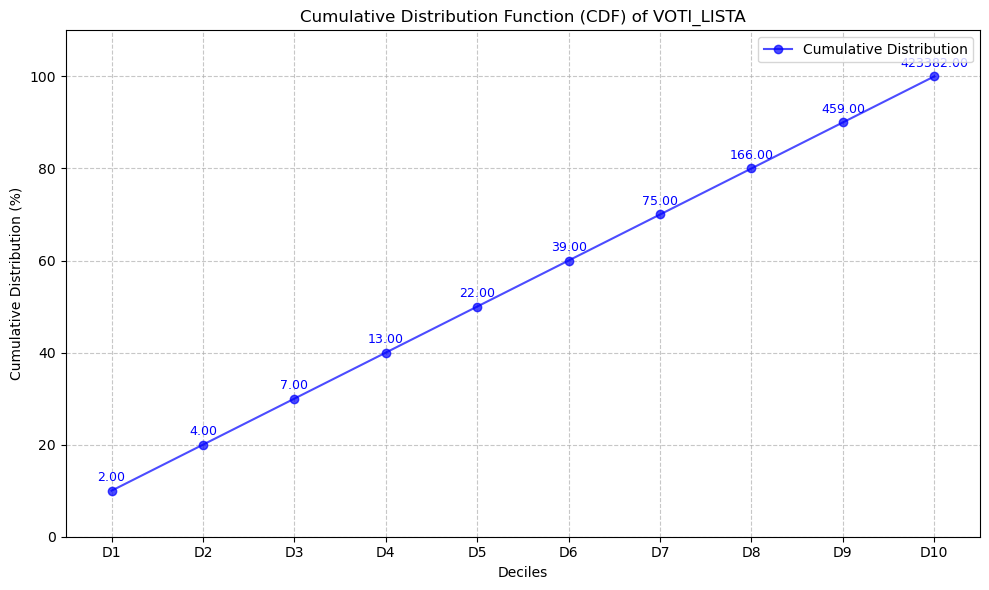

In [309]:
deciles = election_18_grouped['VOTI_LISTA'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
cumulative_percentage = np.linspace(10, 100, len(deciles))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(deciles) + 1), cumulative_percentage, marker='o', color='blue', linestyle='-', alpha=0.7, label="Cumulative Distribution")

for x, y, value in zip(range(1, len(deciles) + 1), cumulative_percentage, deciles.values):
    plt.text(x, y + 2, f'{value:.2f}', color='blue', fontsize=9, ha='center')

plt.title("Cumulative Distribution Function (CDF) of VOTI_LISTA")
plt.xlabel("Deciles")
plt.ylabel("Cumulative Distribution (%)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, len(deciles) + 1), [f'D{i}' for i in range(1, len(deciles) + 1)])
plt.legend()

plt.ylim(0, 110)
plt.xlim(0.5, 10.5)
plt.tight_layout()
plt.show()


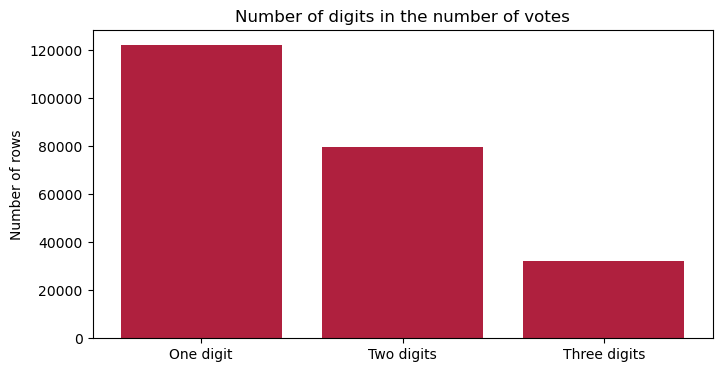

,digit,value,percentage,difference
0,One digit,122149,1.000000,0
1,Two digits,79678,0.652302,-42471
2,Three digits,32122,0.262974,-47556


In [310]:
onep=election_18_grouped['VOTI_LISTA'].shape[0]

twop=election_18_grouped[election_18_grouped['VOTI_LISTA'] >= 10].shape[0]

threep=election_18_grouped[election_18_grouped['VOTI_LISTA'] >= 100].shape[0]

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(['One digit', 'Two digits', 'Three digits'], [onep, twop, threep], color='#af203e')
ax.set_title('Number of digits in the number of votes')
ax.set_ylabel('Number of rows')
plt.show()

onep, twop, threep

data = {'digit': ['One digit', 'Two digits', 'Three digits'],
        'value': [onep, twop, threep],
        'percentage': [onep/onep, twop/onep, threep/onep],
        'difference': [0, twop-onep, threep-twop]}

digits = pd.DataFrame(data)
digits



#### First digit analysis

The first digit test compares the actual first digit frequency distribution of data that come from the italian election
with that developed by Benford.
It is an extremely high-level test and will only identify obvious anomalies (i.e., it will only point
you in the right direction)

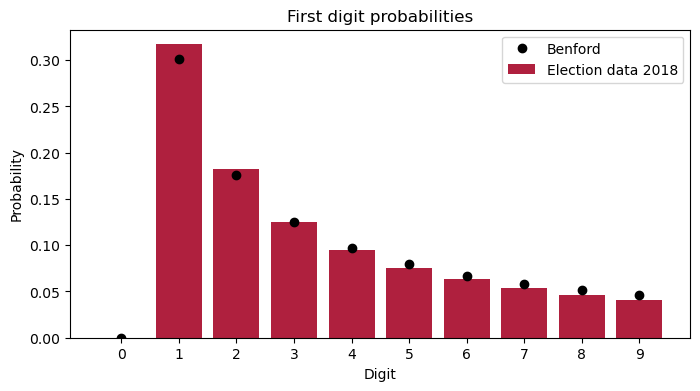

In [311]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(1).keys()), list(benford_nth_digit_probabilities(1).values()), 'ko', label='Benford')
ax.bar(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).keys(), data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values(), label='Election data 2018', color='#af203e')
ax.set_title('First digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.xticks(range(10))
plt.show()


In [312]:
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(1).items(), columns=['First digit', 'Benford probabilities'])
Benford_theory['Election data 2018 probabilities'] = data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values()
Benford_theory['Difference'] = Benford_theory['Election data 2018 probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory

#write the result for a LaTeX table
#Benford_theory.to_latex('italy_first_digit.tex', float_format="%.3f")

,First digit,Benford probabilities,Election data 2018 probabilities,Difference
0,0,0.000000,0.000000,0.000000
1,1,0.301030,0.317137,0.016107
2,2,0.176091,0.182212,0.006121
3,3,0.124939,0.125584,0.000646
4,4,0.096910,0.095375,-0.001535
5,5,0.079181,0.075711,-0.003470
6,6,0.066947,0.063365,-0.003582
7,7,0.057992,0.054057,-0.003935
8,8,0.051153,0.045837,-0.005315
9,9,0.045757,0.040721,-0.005037


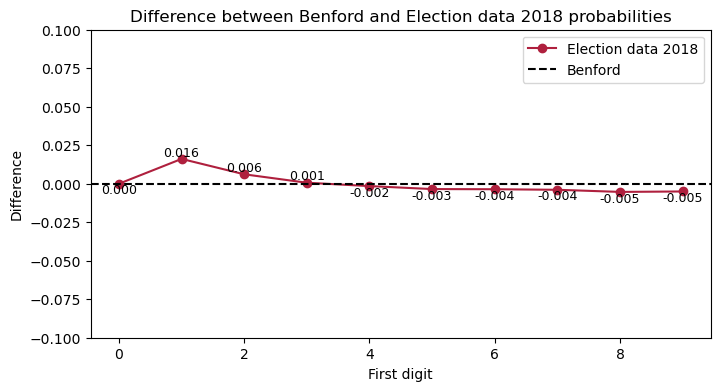

In [313]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Benford_theory['First digit'], Benford_theory['Difference'], 'o-', color='#af203e')
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Difference between Benford and Election data 2018 probabilities')
ax.set_xlabel('First digit')
ax.set_ylabel('Difference')

for i, (x, y) in enumerate(zip(Benford_theory['First digit'], Benford_theory['Difference'])):
    ax.text(x, y, f'{y:.3f}', ha='center', va='bottom' if y > 0 else 'top', fontsize=9, color='black')

ax.set_ylim(-0.1, 0.1)

ax.legend(['Election data 2018', 'Benford'], loc='upper right')

plt.show()


##### Z-Statistic

In [314]:
BP = list(benford_nth_digit_probabilities(1).values())[1:]
AP = list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values())[1:]
N = len(election_18_grouped)

alpha_values = [0.001, 0.01, 0.05]
alpha_corrected_values = apply_bonferroni_correction(num_tests=115)

z_value = calculate_z_statistic(AP, BP, N, alpha_values, alpha_corrected_values)

N: 122149
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.3171
  Expected proportion (BP): 0.3010
  Z-statistic: 12.2694
  p-value: 0.000000
  Critical value at alpha=0.10000%: 3.2905
  Reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Reject null hypothesis at alpha=5.00000%
  Corrected critical value at alpha=0.00087%: 4.4473
  Reject null hypothesis at corrected alpha=0.00087%
  Corrected critical value at alpha=0.00870%: 3.9244
  Reject null hypothesis at corrected alpha=0.00870%
  Corrected critical value at alpha=0.04348%: 3.5180
  Reject null hypothesis at corrected alpha=0.04348%
Digit 2:
  Actual proportion (DP): 0.1822
  Expected proportion (BP): 0.1761
  Z-statistic: 5.6123
  p-value: 0.000000
  Critical value at alpha=0.10000%: 3.2905
  Reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Reject nu

##### Chi-squared test

In [315]:
BP = list(benford_nth_digit_probabilities(1).values())[1:]
AP = list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values())[1:]
N = len(election_18_grouped)
alpha_corrected_values = apply_bonferroni_correction(num_tests=115)
cs_first_digit = calculate_chi_square(AP, BP, N, alpha_levels=alpha_values)
cs_first_digit_corrected = calculate_chi_square(AP, BP, N, alpha_levels=alpha_corrected_values)

cs_first_digit, cs_first_digit_corrected

N: 122149
Chi-Square statistic: 344.4165
p-value: 0.000000
At alpha=0.001000: Reject the null hypothesis
At alpha=0.010000: Reject the null hypothesis
At alpha=0.050000: Reject the null hypothesis
N: 122149
Chi-Square statistic: 344.4165
p-value: 0.000000
At alpha=0.000009: Reject the null hypothesis
At alpha=0.000087: Reject the null hypothesis
At alpha=0.000435: Reject the null hypothesis


(({0.001: {'chi_square': 344.416530278937,
    'p_value': '0.000000',
    'decision': 'Reject the null hypothesis',
    'degrees of freedom': 8},
   0.01: {'chi_square': 344.416530278937,
    'p_value': '0.000000',
    'decision': 'Reject the null hypothesis',
    'degrees of freedom': 8},
   0.05: {'chi_square': 344.416530278937,
    'p_value': '0.000000',
    'decision': 'Reject the null hypothesis',
    'degrees of freedom': 8}},
  344.416530278937,
  0.0),
 ({8.695652173913044e-06: {'chi_square': 344.416530278937,
    'p_value': '0.000000',
    'decision': 'Reject the null hypothesis',
    'degrees of freedom': 8},
   8.695652173913044e-05: {'chi_square': 344.416530278937,
    'p_value': '0.000000',
    'decision': 'Reject the null hypothesis',
    'degrees of freedom': 8},
   0.0004347826086956522: {'chi_square': 344.416530278937,
    'p_value': '0.000000',
    'decision': 'Reject the null hypothesis',
    'degrees of freedom': 8}},
  344.416530278937,
  0.0))

The data suggest a significant difference between the observed and expected frequencies. This result confirms the strong deviation of the observed frequencies from the expected proportions, indicating that the theoretical model (expected distribution) does not fit well with the observed data.

##### Kolmogorov-Smirnov test

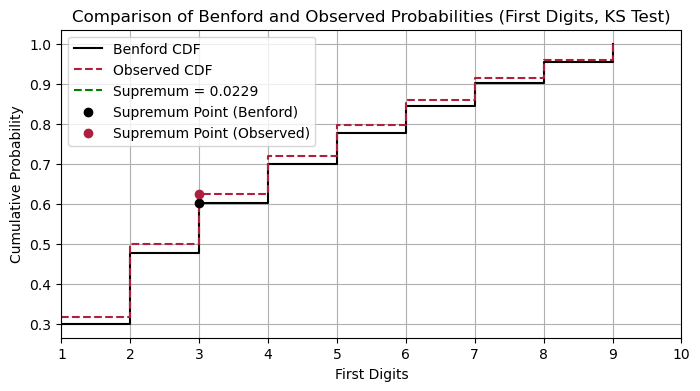

Supremum: 0.0229
First Digits of Supremum: 3
P-value (manual calculation): 0.000000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=1:
Alpha level: 0.001000
Alpha level: 0.010000
Alpha level: 0.050000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=115:
Alpha level: 0.000009
Alpha level: 0.000087
Alpha level: 0.000435

Total observations (n): 122149


In [316]:
# Compute Bonferroni-adjusted alpha levels for different num_tests
alpha_levels_results = {}
for num_tests in [1, 115]:
    alpha_levels_results[num_tests] = apply_bonferroni_correction(num_tests=num_tests)

# Compute cumulative proportions for Benford's law and observed data
benford_digits = list(benford_nth_digit_probabilities(1).keys())[1:]
benford_probs = list(benford_nth_digit_probabilities(1).values())[1:]
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).keys())[1:]
election_probs = list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values())[1:]
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the KS statistic manually
supremum, supremum_index = calculate_ks_manually(benford_cumulative, election_cumulative)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Calculate the theoretical p-value manually
n = onep  # Total observations
p_value_manual = manual_ks_p_value(supremum, n)

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
plt.step(range(1, 10), benford_cumulative, where="post", label="Benford CDF", color="black")
plt.step(range(1, 10), election_cumulative, where="post", label="Observed CDF", color="#af203e", linestyle="--")

# Highlight the supremum
plt.plot(
    [supremum_x, supremum_x],
    [supremum_y_benford, supremum_y_el],
    color="green",
    linestyle="--",
    label=f"Supremum = {supremum:.4f}"
)

# Add points for the supremum
plt.scatter([supremum_x], [supremum_y_benford], color="black", zorder=5, label="Supremum Point (Benford)")
plt.scatter([supremum_x], [supremum_y_el], color="#af203e", zorder=5, label="Supremum Point (Observed)")

# Customize the plot
plt.xlabel("First Digits")
plt.ylabel("Cumulative Probability")
plt.title("Comparison of Benford and Observed Probabilities (First Digits, KS Test)")
plt.legend()
plt.grid(True)
plt.xlim(1, 10)
plt.show()

# Print results
print(f"Supremum: {supremum:.4f}")
print(f"First Digits of Supremum: {supremum_x}")
print(f"P-value (manual calculation): {p_value_manual:.6f}\n")

for num_tests, adjusted_alpha_levels in alpha_levels_results.items():
    print(f"Adjusted Alpha Levels (Bonferroni Correction) for num_tests={num_tests}:")
    for alpha in adjusted_alpha_levels:
        print(f"Alpha level: {alpha:.6f}")
    print()

print(f"Total observations (n): {n}")


##### Saville's regression

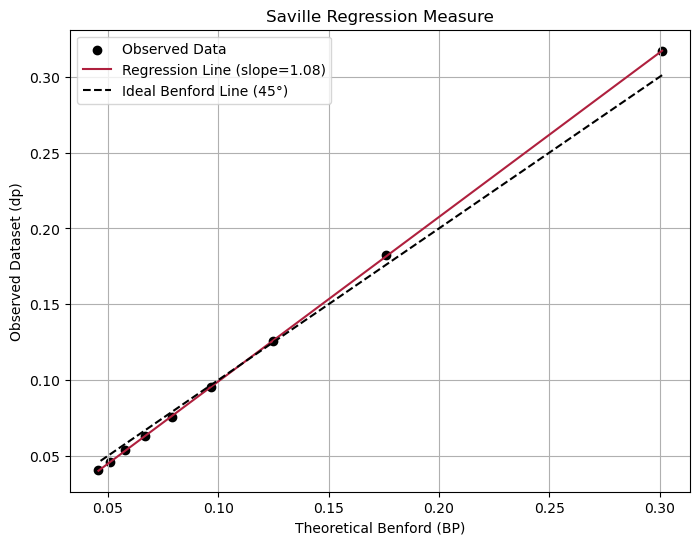

Slope (b1): 1.0849, Z-score: 37.0216, p-value: 0.0000
Intercept (b0): -0.0094, Z-score: -30.3387, p-value: 0.0000
Joint Test (b0=0 and b1=1), Z-score: 47.8648, p-value: 0.0000
Reject H0 at α=0.001: True
Reject H0 at α=0.01: True
Reject H0 at α=0.05: True


{'slope': 1.0848948989824871,
 'intercept': -0.009432766553609681,
 'z_slope': 37.02163168833959,
 'z_intercept': -30.338667262625044,
 'joint_z': 47.864767252534996,
 'p_slope': 0.0,
 'p_intercept': 0.0,
 'p_joint': 0.0,
 'hypothesis_results': {0.001: True, 0.01: True, 0.05: True}}

In [317]:
saville_regression(list(benford_nth_digit_probabilities(1).values())[1:], list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values())[1:])

##### MAD

In [318]:
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values())[1:]
K=len(BP)   #number of digits
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")


Number of digits (K): 9
Mean Absolute Deviation (MAD) from Benford's Law: 0.005082998122112654


##### FSD mean


In [319]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(benford_nth_digit_probabilities(1).values())[1:], start_digit=1, num_digits=9), 
      " | Uniform FSD Mean:", calculate_fsd_mean(uniform_first_digit, start_digit=1, num_digits=9),
        " | Election data 2018 FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values())[1:], start_digit=1, num_digits=9))

Benford's Law FSD Mean: 3.440236967123206  | Uniform FSD Mean: 5.0  | Election data 2018 FSD Mean: 3.3101458055325867


##### Sum of Squares Deviations

In [320]:
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values())[1:]
sum_squares_deviation(BP, AP)

3.936527090262961

#### Second digit

We can do the same analysis that we have done for the first digit but for the second digit.

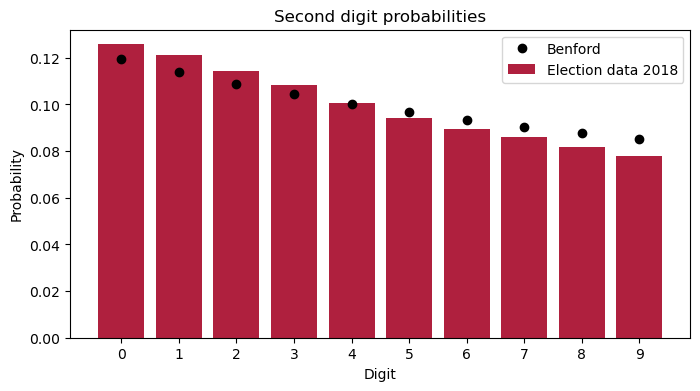

In [321]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(2).keys()), list(benford_nth_digit_probabilities(2).values()), 'ko', label='Benford')
ax.bar(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).keys(), data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values(), label='Election data 2018', color='#af203e')
ax.set_title('Second digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.xticks(range(10))

plt.show()


##### Z-Statistic

In [322]:
BP = list(benford_nth_digit_probabilities(2).values())
AP = list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values())
N = twop

alpha_values = [0.001, 0.01, 0.05]
alpha_corrected_values = apply_bonferroni_correction(num_tests=115)

z_value = calculate_z_statistic(AP, BP, N, alpha_values, alpha_corrected_values)

N: 79678
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.1257
  Expected proportion (BP): 0.1197
  Z-statistic: 5.2683
  p-value: 0.000000
  Critical value at alpha=0.10000%: 3.2905
  Reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Reject null hypothesis at alpha=5.00000%
  Corrected critical value at alpha=0.00087%: 4.4473
  Reject null hypothesis at corrected alpha=0.00087%
  Corrected critical value at alpha=0.00870%: 3.9244
  Reject null hypothesis at corrected alpha=0.00870%
  Corrected critical value at alpha=0.04348%: 3.5180
  Reject null hypothesis at corrected alpha=0.04348%
Digit 2:
  Actual proportion (DP): 0.1211
  Expected proportion (BP): 0.1139
  Z-statistic: 6.3896
  p-value: 0.000000
  Critical value at alpha=0.10000%: 3.2905
  Reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Reject null

##### Chi-squared test

In [323]:
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values())
N=twop
alpha_corrected_values = apply_bonferroni_correction(num_tests=115)
cs_second_digit=calculate_chi_square(AP, BP, N)
cs_second_digit_corrected=calculate_chi_square(AP, BP, N, alpha_levels=alpha_corrected_values)

cs_second_digit, cs_second_digit_corrected

N: 79678
Chi-Square statistic: 204.5951
p-value: 0.000000
At alpha=0.001000: Reject the null hypothesis
At alpha=0.010000: Reject the null hypothesis
At alpha=0.050000: Reject the null hypothesis
N: 79678
Chi-Square statistic: 204.5951
p-value: 0.000000
At alpha=0.000009: Reject the null hypothesis
At alpha=0.000087: Reject the null hypothesis
At alpha=0.000435: Reject the null hypothesis


(({0.001: {'chi_square': 204.59506563262244,
    'p_value': '0.000000',
    'decision': 'Reject the null hypothesis',
    'degrees of freedom': 9},
   0.01: {'chi_square': 204.59506563262244,
    'p_value': '0.000000',
    'decision': 'Reject the null hypothesis',
    'degrees of freedom': 9},
   0.05: {'chi_square': 204.59506563262244,
    'p_value': '0.000000',
    'decision': 'Reject the null hypothesis',
    'degrees of freedom': 9}},
  204.59506563262244,
  0.0),
 ({8.695652173913044e-06: {'chi_square': 204.59506563262244,
    'p_value': '0.000000',
    'decision': 'Reject the null hypothesis',
    'degrees of freedom': 9},
   8.695652173913044e-05: {'chi_square': 204.59506563262244,
    'p_value': '0.000000',
    'decision': 'Reject the null hypothesis',
    'degrees of freedom': 9},
   0.0004347826086956522: {'chi_square': 204.59506563262244,
    'p_value': '0.000000',
    'decision': 'Reject the null hypothesis',
    'degrees of freedom': 9}},
  204.59506563262244,
  0.0))

##### Kolmogorov-Smirnov test


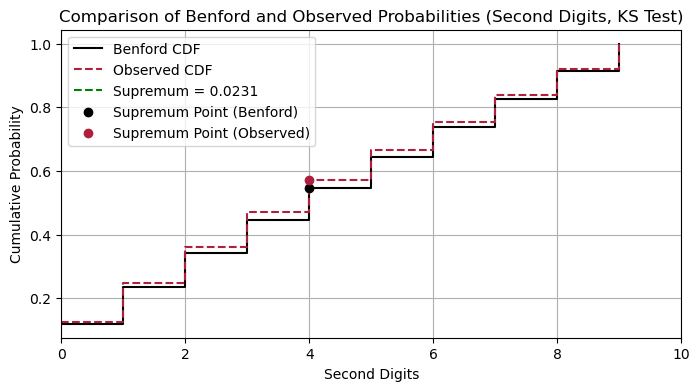

Supremum: 0.0231
First Digits of Supremum: 4
P-value (manual calculation): 0.0000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=1:
Alpha level: 0.001000
Alpha level: 0.010000
Alpha level: 0.050000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=115:
Alpha level: 0.000009
Alpha level: 0.000087
Alpha level: 0.000435

Total observations (n): 79678


In [324]:
# Compute Bonferroni-adjusted alpha levels for different num_tests
alpha_levels_results = {}
for num_tests in [1, 115]:
    alpha_levels_results[num_tests] = apply_bonferroni_correction(num_tests=num_tests)

# Compute cumulative proportions for Benford's law and observed data
benford_digits = list(benford_nth_digit_probabilities(2).keys())
benford_probs = list(benford_nth_digit_probabilities(2).values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).keys())
election_probs = list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values())
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the KS statistic manually
supremum, supremum_index = calculate_ks_manually(benford_cumulative, election_cumulative)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Calculate the theoretical p-value manually
n = twop  # Total observations
p_value_manual = manual_ks_p_value(supremum, n)

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
plt.step(range(0, 10), benford_cumulative, where="post", label="Benford CDF", color="black")
plt.step(range(0, 10), election_cumulative, where="post", label="Observed CDF", color="#af203e", linestyle="--")

# Highlight the supremum
plt.plot(
    [supremum_x, supremum_x],
    [supremum_y_benford, supremum_y_el],
    color="green",
    linestyle="--",
    label=f"Supremum = {supremum:.4f}"
)

# Add points for the supremum
plt.scatter([supremum_x], [supremum_y_benford], color="black", zorder=5, label="Supremum Point (Benford)")
plt.scatter([supremum_x], [supremum_y_el], color="#af203e", zorder=5, label="Supremum Point (Observed)")

# Customize the plot
plt.xlabel("Second Digits")
plt.ylabel("Cumulative Probability")
plt.title("Comparison of Benford and Observed Probabilities (Second Digits, KS Test)")
plt.legend()
plt.grid(True)
plt.xlim(0, 10)
plt.show()

# Print results
print(f"Supremum: {supremum:.4f}")
print(f"First Digits of Supremum: {supremum_x}")
print(f"P-value (manual calculation): {p_value_manual:.4f}\n")

for num_tests, adjusted_alpha_levels in alpha_levels_results.items():
    print(f"Adjusted Alpha Levels (Bonferroni Correction) for num_tests={num_tests}:")
    for alpha in adjusted_alpha_levels:
        print(f"Alpha level: {alpha:.6f}")
    print()

print(f"Total observations (n): {n}")

##### Saville's regression

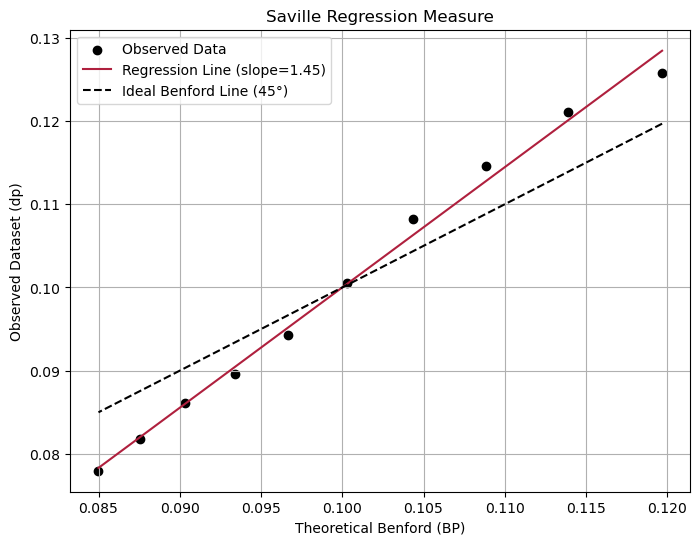

Slope (b1): 1.4456, Z-score: 10.6657, p-value: 0.0000
Intercept (b0): -0.0446, Z-score: -10.6021, p-value: 0.0000
Joint Test (b0=0 and b1=1), Z-score: 15.0387, p-value: 0.0000
Reject H0 at α=0.001: True
Reject H0 at α=0.01: True
Reject H0 at α=0.05: True


{'slope': 1.4455645909135935,
 'intercept': -0.0445564590913593,
 'z_slope': 10.665729624351028,
 'z_intercept': -10.602071377397547,
 'joint_z': 15.038673675267757,
 'p_slope': 0.0,
 'p_intercept': 0.0,
 'p_joint': 0.0,
 'hypothesis_results': {0.001: True, 0.01: True, 0.05: True}}

In [325]:
result = saville_regression(list(benford_nth_digit_probabilities(2).values()), list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values()))
result

##### MAD

In [326]:
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values())
K=len(BP)   #number of digits
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")

Number of digits (K): 10
Mean Absolute Deviation (MAD) from Benford's Law: 0.004618219682499526


##### SSD mean

In [327]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(benford_nth_digit_probabilities(2).values()), start_digit=0, num_digits=10), 
    " | Uniform FSD Mean:", calculate_fsd_mean(uniform_other_digits, start_digit=0, num_digits=10),
    " | Election data 2018 FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values()), start_digit=0, num_digits=10))

Benford's Law FSD Mean: 4.1873897069289425  | Uniform FSD Mean: 4.500000000000001  | Election data 2018 FSD Mean: 4.045646226059891


##### Sum of squares deviations

In [328]:
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values())
sum_squares_deviation(BP, AP)

2.559368180196842

#### First-two digits

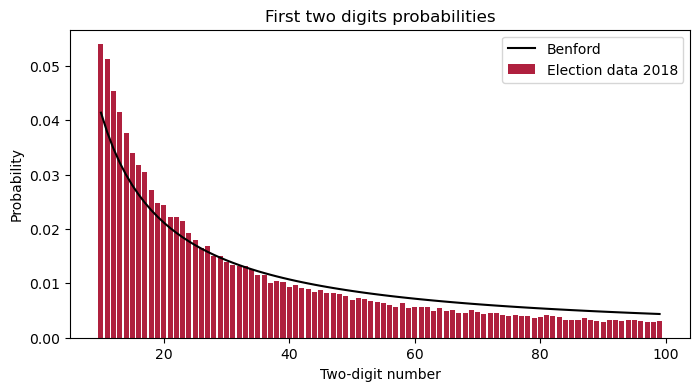

In [329]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(Benford_theory_firsttwo_digits().keys()), list(Benford_theory_firsttwo_digits().values()), 'black', label='Benford')
ax.bar(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).keys(), data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values(), label='Election data 2018',color='#af203e')
ax.set_title('First two digits probabilities')
ax.set_xlabel('Two-digit number')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


##### Z-Statistic

In [330]:
BP = list(Benford_theory_firsttwo_digits().values())
AP = list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values())
N = twop

alpha_values = [0.001, 0.01, 0.05]
alpha_corrected_values = apply_bonferroni_correction(num_tests=115)

z_values, p_values = calculate_z_statistic(AP, BP, N, alpha_values, alpha_corrected_values)

Benford_theory = pd.DataFrame(Benford_theory_firsttwo_digits().items(), columns=['Two-digit number', 'Benford probabilities'])
Benford_theory['Election data 2018 probabilities'] = data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values()
Benford_theory['Difference'] = Benford_theory['Election data 2018 probabilities'] - Benford_theory['Benford probabilities']
Benford_theory['Z-statistic'] = [z_values.get(f"Digit_{i+1}", 0) for i in range(len(Benford_theory))]
Benford_theory['p-value'] = [p_values.get(f"Digit_{i+1}", 0) for i in range(len(Benford_theory))]
Benford_theory = Benford_theory.round(3)
Benford_theory = Benford_theory.sort_values(by='Z-statistic', ascending=False)
Benford_theory = pd.concat([Benford_theory.head(5), Benford_theory.tail(5)])
Benford_theory.to_latex('z_statistic_18_firsttwo.tex', float_format="%.3f")


N: 79678
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.0540
  Expected proportion (BP): 0.0414
  Z-statistic: 17.7921
  p-value: 0.000000
  Critical value at alpha=0.10000%: 3.2905
  Reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Reject null hypothesis at alpha=5.00000%
  Corrected critical value at alpha=0.00087%: 4.4473
  Reject null hypothesis at corrected alpha=0.00087%
  Corrected critical value at alpha=0.00870%: 3.9244
  Reject null hypothesis at corrected alpha=0.00870%
  Corrected critical value at alpha=0.04348%: 3.5180
  Reject null hypothesis at corrected alpha=0.04348%
Digit 2:
  Actual proportion (DP): 0.0512
  Expected proportion (BP): 0.0378
  Z-statistic: 19.8157
  p-value: 0.000000
  Critical value at alpha=0.10000%: 3.2905
  Reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Reject nu

C:\Users\franc\AppData\Local\Temp\ipykernel_5012\2837777433.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  Benford_theory.to_latex('z_statistic_18_firsttwo.tex', float_format="%.3f")


In [331]:
alpha_values = [0.001, 0.01, 0.05]
alpha_corrected_values = apply_bonferroni_correction(num_tests=115)
uncorrected_counts = {alpha: sum([1 for p in p_values.values() if p > alpha]) for alpha in alpha_values}
corrected_counts = {alpha: sum([1 for p in p_values.values() if p > alpha]) for alpha in alpha_corrected_values}

uncorrected_counts, corrected_counts


({0.001: 23, 0.01: 16, 0.05: 11},
 {8.695652173913044e-06: 35,
  8.695652173913044e-05: 28,
  0.0004347826086956522: 24})

##### Chi-square test


In [332]:
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values())
N=twop
alpha_corrected_values = apply_bonferroni_correction(num_tests=115)
cs_firsttwo_digit=calculate_chi_square(AP, BP, N)
cs_firsttwo_digit_corrected=calculate_chi_square(AP, BP, N, alpha_levels=alpha_corrected_values)

cs_firsttwo_digit, cs_firsttwo_digit_corrected

N: 79678
Chi-Square statistic: 3600.4739
p-value: 0.000000
At alpha=0.001000: Reject the null hypothesis
At alpha=0.010000: Reject the null hypothesis
At alpha=0.050000: Reject the null hypothesis
N: 79678
Chi-Square statistic: 3600.4739
p-value: 0.000000
At alpha=0.000009: Reject the null hypothesis
At alpha=0.000087: Reject the null hypothesis
At alpha=0.000435: Reject the null hypothesis


(({0.001: {'chi_square': 3600.473895318019,
    'p_value': '0.000000',
    'decision': 'Reject the null hypothesis',
    'degrees of freedom': 89},
   0.01: {'chi_square': 3600.473895318019,
    'p_value': '0.000000',
    'decision': 'Reject the null hypothesis',
    'degrees of freedom': 89},
   0.05: {'chi_square': 3600.473895318019,
    'p_value': '0.000000',
    'decision': 'Reject the null hypothesis',
    'degrees of freedom': 89}},
  3600.473895318019,
  0.0),
 ({8.695652173913044e-06: {'chi_square': 3600.473895318019,
    'p_value': '0.000000',
    'decision': 'Reject the null hypothesis',
    'degrees of freedom': 89},
   8.695652173913044e-05: {'chi_square': 3600.473895318019,
    'p_value': '0.000000',
    'decision': 'Reject the null hypothesis',
    'degrees of freedom': 89},
   0.0004347826086956522: {'chi_square': 3600.473895318019,
    'p_value': '0.000000',
    'decision': 'Reject the null hypothesis',
    'degrees of freedom': 89}},
  3600.473895318019,
  0.0))

##### Kolmogorov-Smirnov test

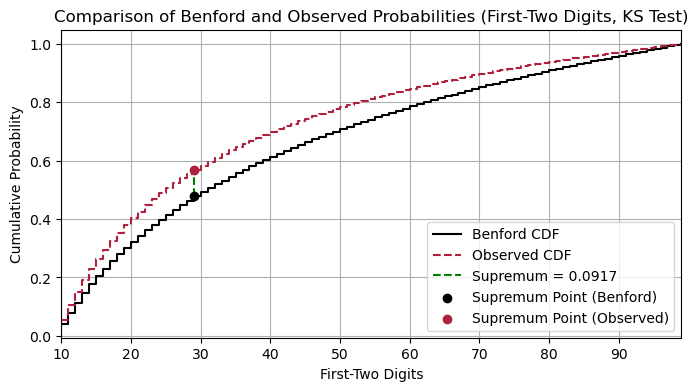

Supremum: 0.0917
First Digits of Supremum: 29
P-value (manual calculation): 0.000000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=1:
Alpha level: 0.001000
Alpha level: 0.010000
Alpha level: 0.050000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=115:
Alpha level: 0.000009
Alpha level: 0.000087
Alpha level: 0.000435

Total observations (n): 79678


In [333]:
# Compute Bonferroni-adjusted alpha levels for different num_tests
alpha_levels_results = {}
for num_tests in [1, 115]:
    alpha_levels_results[num_tests] = apply_bonferroni_correction(num_tests=num_tests)

# Compute cumulative proportions for Benford's law and observed data
benford_digits = list(Benford_theory_firsttwo_digits().keys())
benford_probs = list(Benford_theory_firsttwo_digits().values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).keys())
election_probs = list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values())
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the KS statistic manually
supremum, supremum_index = calculate_ks_manually(benford_cumulative, election_cumulative)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Calculate the theoretical p-value manually
n = twop  # Total observations
p_value_manual = manual_ks_p_value(supremum, n)

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
plt.step(range(10, 100), benford_cumulative, where="post", label="Benford CDF", color="black")
plt.step(range(10, 100), election_cumulative, where="post", label="Observed CDF", color="#af203e", linestyle="--")

# Highlight the supremum
plt.plot(
    [supremum_x, supremum_x],
    [supremum_y_benford, supremum_y_el],
    color="green",
    linestyle="--",
    label=f"Supremum = {supremum:.4f}"
)

# Add points for the supremum
plt.scatter([supremum_x], [supremum_y_benford], color="black", zorder=5, label="Supremum Point (Benford)")
plt.scatter([supremum_x], [supremum_y_el], color="#af203e", zorder=5, label="Supremum Point (Observed)")

# Customize the plot
plt.xlabel("First-Two Digits")
plt.ylabel("Cumulative Probability")
plt.title("Comparison of Benford and Observed Probabilities (First-Two Digits, KS Test)")
plt.legend()
plt.grid(True)
plt.xlim(10, 99)
plt.show()

# Print results
print(f"Supremum: {supremum:.4f}")
print(f"First Digits of Supremum: {supremum_x}")
print(f"P-value (manual calculation): {p_value_manual:.6f}\n")

for num_tests, adjusted_alpha_levels in alpha_levels_results.items():
    print(f"Adjusted Alpha Levels (Bonferroni Correction) for num_tests={num_tests}:")
    for alpha in adjusted_alpha_levels:
        print(f"Alpha level: {alpha:.6f}")
    print()

print(f"Total observations (n): {n}")


##### Saville's regression

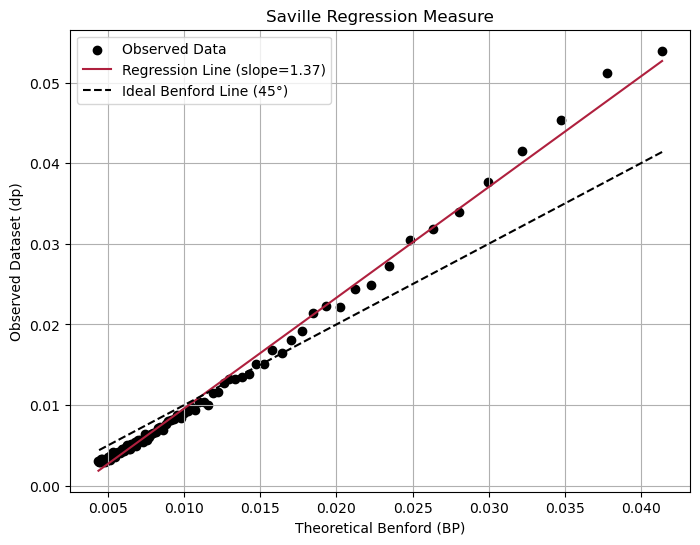

Slope (b1): 1.3728, Z-score: 32.2215, p-value: 0.0000
Intercept (b0): -0.0041, Z-score: -26.0727, p-value: 0.0000
Joint Test (b0=0 and b1=1), Z-score: 41.4489, p-value: 0.0000
Reject H0 at α=0.001: True
Reject H0 at α=0.01: True
Reject H0 at α=0.05: True
{'slope': 1.3727757404388687, 'intercept': -0.0041419526715429835, 'z_slope': 32.22154778006034, 'z_intercept': -26.07272086768019, 'joint_z': 41.44894347008953, 'p_slope': 0.0, 'p_intercept': 0.0, 'p_joint': 0.0, 'hypothesis_results': {0.001: True, 0.01: True, 0.05: True}}


In [334]:
result = saville_regression(list(Benford_theory_firsttwo_digits().values()), list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values()))
print(result)

##### MAD


In [335]:
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values())
K=len(BP)   #number of digits
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")

Number of digits (K): 90
Mean Absolute Deviation (MAD) from Benford's Law: 0.0020474417267288235


##### FTSD mean


In [336]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(Benford_theory_firsttwo_digits().values()), start_digit=10, num_digits=90),
       " | Uniform FSD Mean:", calculate_fsd_mean(uniform_10_99, start_digit=10, num_digits=90), 
         " | Election data 2018 FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values()), start_digit=10, num_digits=90))

Benford's Law FSD Mean: 38.589759378161006  | Uniform FSD Mean: 54.5  | Election data 2018 FSD Mean: 33.587301388087056


##### Sum of Squares Deviations

In [337]:
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values())
sum_squares_deviation(BP, AP)

8.83144498687247

#### Third digit

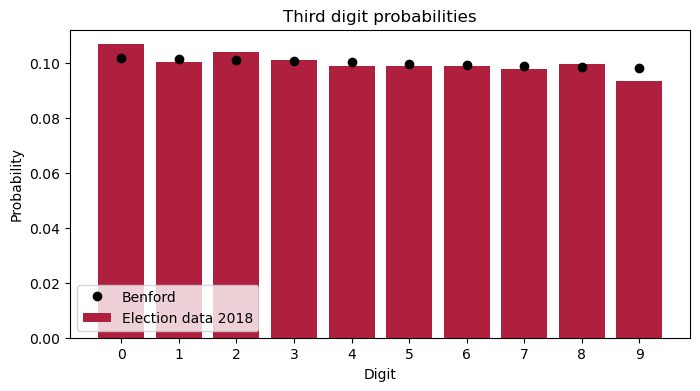

In [338]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(3).keys()), list(benford_nth_digit_probabilities(3).values()), 'ko', label='Benford')
ax.bar(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 3).keys(), data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 3).values(), label='Election data 2018', color='#af203e')
ax.set_title('Third digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()

plt.xticks(range(10))

plt.show()

In [339]:
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(3).items(), columns=['Second digit', 'Benford probabilities'])
Benford_theory['Election data 2018 probabilities'] = data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 3).values()
Benford_theory['Difference'] = Benford_theory['Election data 2018 probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory

,Second digit,Benford probabilities,Election data 2018 probabilities,Difference
0,0,0.101784,0.106749,0.004965
1,1,0.101376,0.100367,-0.001009
2,2,0.100972,0.103854,0.002882
3,3,0.100573,0.101208,0.000635
4,4,0.100178,0.098998,-0.001181
5,5,0.099788,0.098998,-0.000790
6,6,0.099401,0.098717,-0.000684
7,7,0.099019,0.097846,-0.001173
8,8,0.098641,0.099776,0.001135
9,9,0.098267,0.093487,-0.004780


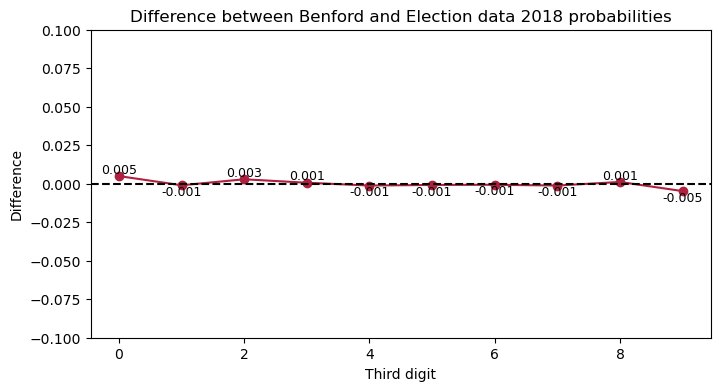

In [340]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Benford_theory['Second digit'], Benford_theory['Difference'], 'o-', color='#af203e')
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Difference between Benford and Election data 2018 probabilities')
ax.set_xlabel('Third digit')
ax.set_ylabel('Difference')

for i, (x, y) in enumerate(zip(Benford_theory['Second digit'], Benford_theory['Difference'])):
    ax.text(x, y, f'{y:.3f}', ha='center', va='bottom' if y > 0 else 'top', fontsize=9, color='black')

ax.set_ylim(-0.1, 0.1)

plt.show()

#### Italy, one region

In [341]:
election_data_18_region['CIRCOSCRIZIONE'].unique()

array(['PIEMONTE 1', 'PIEMONTE 2', 'LOMBARDIA 1', 'LOMBARDIA 2',
       'LOMBARDIA 3', 'LOMBARDIA 4', 'VENETO 1', 'VENETO 2',
       'FRIULI-VENEZIA GIULIA', 'LIGURIA', 'EMILIA-ROMAGNA', 'TOSCANA',
       'UMBRIA', 'MARCHE', 'LAZIO 1', 'LAZIO 2', 'ABRUZZO', 'MOLISE',
       'CAMPANIA 1', 'CAMPANIA 2', 'PUGLIA', 'BASILICATA', 'CALABRIA',
       'SICILIA 1', 'SICILIA 2', 'SARDEGNA',
       'TRENTINO-ALTO ADIGE/S_DTIROL', 'AOSTA'], dtype=object)

In [342]:
election_data_18_region['CIRCOSCRIZIONE'] = election_data_18_region['CIRCOSCRIZIONE'].replace({'PIEMONTE 1': 'PIEMONTE', 'PIEMONTE 2': 'PIEMONTE',
                                                                                                'LOMBARDIA 1': 'LOMBARDIA', 'LOMBARDIA 2': 'LOMBARDIA', 'LOMBARDIA 3': 'LOMBARDIA', 'LOMBARDIA 4': 'LOMBARDIA',
                                                                                                'VENETO 1': 'VENETO', 'VENETO 2': 'VENETO',
                                                                                                'CAMPANIA 1': 'CAMPANIA', 'CAMPANIA 2': 'CAMPANIA',
                                                                                                'SICILIA 1': 'SICILIA', 'SICILIA 2': 'SICILIA',
                                                                                                'LAZIO 1': 'LAZIO', 'LAZIO 2': 'LAZIO'})

election_data_18_region['CIRCOSCRIZIONE'].unique()

election_data_18_region['CIRCOSCRIZIONE'].value_counts()


LOMBARDIA                       26524
PIEMONTE                        17681
VENETO                          10184
CAMPANIA                         9724
CALABRIA                         7290
LAZIO                            6618
SICILIA                          6170
SARDEGNA                         6032
EMILIA-ROMAGNA                   5574
ABRUZZO                          5185
FRIULI-VENEZIA GIULIA            4730
PUGLIA                           4496
TRENTINO-ALTO ADIGE/S_DTIROL     4380
TOSCANA                          4281
LIGURIA                          4248
MARCHE                           3584
BASILICATA                       2489
MOLISE                           2312
UMBRIA                           1656
AOSTA                             666
Name: CIRCOSCRIZIONE, dtype: int64

In [343]:
election_data_18_region
veneto = election_data_18_region[election_data_18_region['CIRCOSCRIZIONE'].isin(["VENETO"])]
veneto = veneto[['COMUNE', 'VOTANTI', 'LISTA', 'COGNOME', 'NOME', 'VOTI_LISTA']]
veneto


,COMUNE,VOTANTI,LISTA,COGNOME,NOME,VOTI_LISTA
44205,SPINEA,16776,10 VOLTE MEGLIO,AKAY,EMINE ELIF,35.0
44206,SPINEA,16776,NOI CON L'ITALIA - UDC,ANDREUZZA,GIORGIA,75.0
44207,SPINEA,16776,FORZA ITALIA,ANDREUZZA,GIORGIA,1297.0
44208,SPINEA,16776,FRATELLI D'ITALIA CON GIORGIA MELONI,ANDREUZZA,GIORGIA,471.0
44209,SPINEA,16776,LEGA,ANDREUZZA,GIORGIA,3731.0
...,...,...,...,...,...,...
54384,ZEVIO,8788,ITALIA EUROPA INSIEME,ROVERONI,ISABELLA,37.0
54385,ZEVIO,8788,CIVICA POPOLARE LORENZIN,ROVERONI,ISABELLA,33.0
54386,ZEVIO,8788,+EUROPA,ROVERONI,ISABELLA,135.0
54387,ZEVIO,8788,LIBERI E UGUALI,TOSI,OSCAR,119.0


In [344]:
veneto = veneto.groupby(['COMUNE', 'LISTA'])['VOTI_LISTA'].sum().reset_index()
veneto

,COMUNE,LISTA,VOTI_LISTA
0,ABANO TERME,+EUROPA,343.0
1,ABANO TERME,10 VOLTE MEGLIO,47.0
2,ABANO TERME,CASAPOUND ITALIA,72.0
3,ABANO TERME,CIVICA POPOLARE LORENZIN,48.0
4,ABANO TERME,FORZA ITALIA,1408.0
...,...,...,...
10179,ZUGLIANO,NOI CON L'ITALIA - UDC,28.0
10180,ZUGLIANO,PARTITO DEMOCRATICO,652.0
10181,ZUGLIANO,PARTITO REPUBBLICANO ITALIANO - ALA,3.0
10182,ZUGLIANO,PARTITO VALORE UMANO,22.0


In [345]:
veneto = veneto[veneto['VOTI_LISTA'] != 0].reset_index(drop=True)
veneto['VOTI_LISTA'] = veneto['VOTI_LISTA'].astype(int)
veneto

,COMUNE,LISTA,VOTI_LISTA
0,ABANO TERME,+EUROPA,343
1,ABANO TERME,10 VOLTE MEGLIO,47
2,ABANO TERME,CASAPOUND ITALIA,72
3,ABANO TERME,CIVICA POPOLARE LORENZIN,48
4,ABANO TERME,FORZA ITALIA,1408
...,...,...,...
9872,ZUGLIANO,NOI CON L'ITALIA - UDC,28
9873,ZUGLIANO,PARTITO DEMOCRATICO,652
9874,ZUGLIANO,PARTITO REPUBBLICANO ITALIANO - ALA,3
9875,ZUGLIANO,PARTITO VALORE UMANO,22


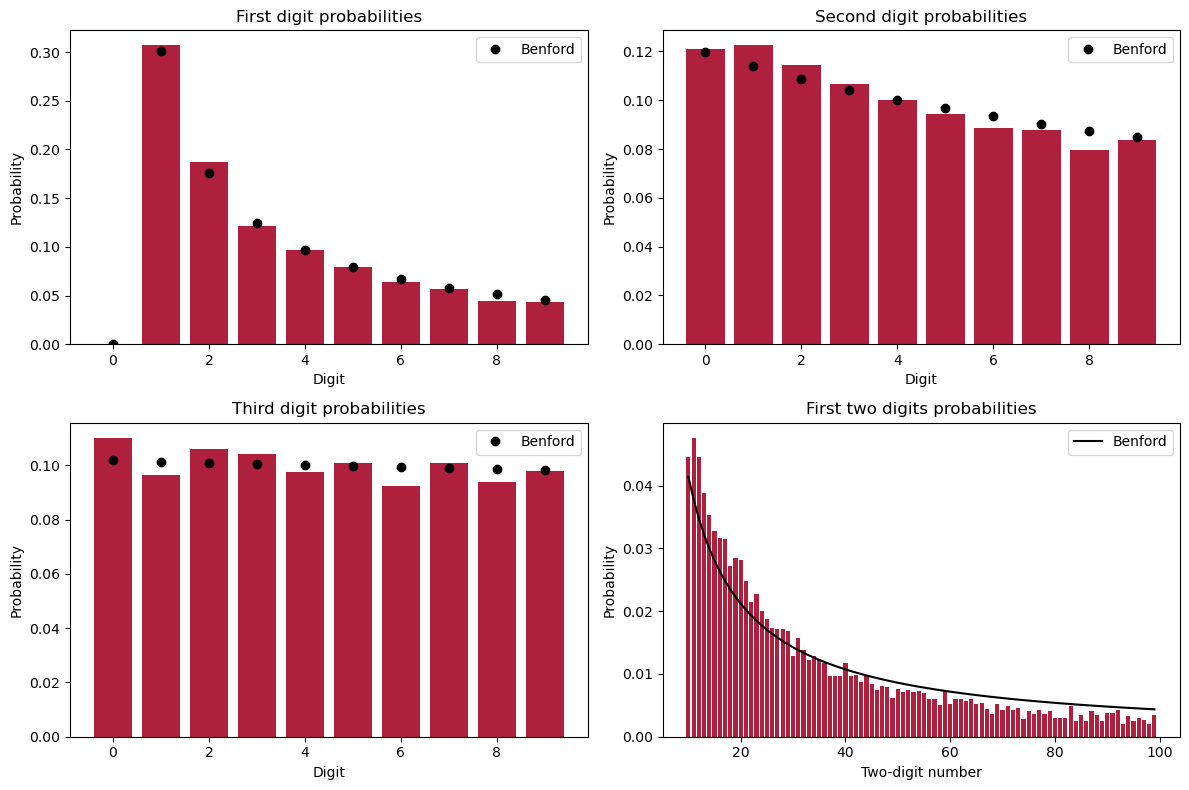

In [346]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0, 0].plot(list(benford_nth_digit_probabilities(1).keys()), list(benford_nth_digit_probabilities(1).values()), 'ko', label='Benford')
ax[0, 0].bar(data_digit_probabilities(veneto['VOTI_LISTA'], 1).keys(), data_digit_probabilities(veneto['VOTI_LISTA'], 1).values(), color='#af203e')
ax[0, 0].set_title('First digit probabilities')
ax[0, 0].set_xlabel('Digit')
ax[0, 0].set_ylabel('Probability')
ax[0, 0].legend()

ax[0, 1].plot(list(benford_nth_digit_probabilities(2).keys()), list(benford_nth_digit_probabilities(2).values()), 'ko', label='Benford')
ax[0, 1].bar(data_digit_probabilities(veneto['VOTI_LISTA'], 2).keys(), data_digit_probabilities(veneto['VOTI_LISTA'], 2).values(), color='#af203e')
ax[0, 1].set_title('Second digit probabilities')
ax[0, 1].set_xlabel('Digit')
ax[0, 1].set_ylabel('Probability')
ax[0, 1].legend()

ax[1, 0].plot(list(benford_nth_digit_probabilities(3).keys()), list(benford_nth_digit_probabilities(3).values()), 'ko', label='Benford')
ax[1, 0].bar(data_digit_probabilities(veneto['VOTI_LISTA'], 3).keys(), data_digit_probabilities(veneto['VOTI_LISTA'], 3).values(), color='#af203e')
ax[1, 0].set_title('Third digit probabilities')
ax[1, 0].set_xlabel('Digit')
ax[1, 0].set_ylabel('Probability')
ax[1, 0].legend()

ax[1, 1].plot(list(Benford_theory_firsttwo_digits().keys()), list(Benford_theory_firsttwo_digits().values()), 'k', label='Benford')
ax[1, 1].bar(data_digit_probabilities_firsttwo(veneto['VOTI_LISTA']).keys(), data_digit_probabilities_firsttwo(veneto['VOTI_LISTA']).values(), color='#af203e')
ax[1, 1].set_title('First two digits probabilities')
ax[1, 1].set_xlabel('Two-digit number')
ax[1, 1].set_ylabel('Probability')
ax[1, 1].legend()

plt.tight_layout()
plt.show()



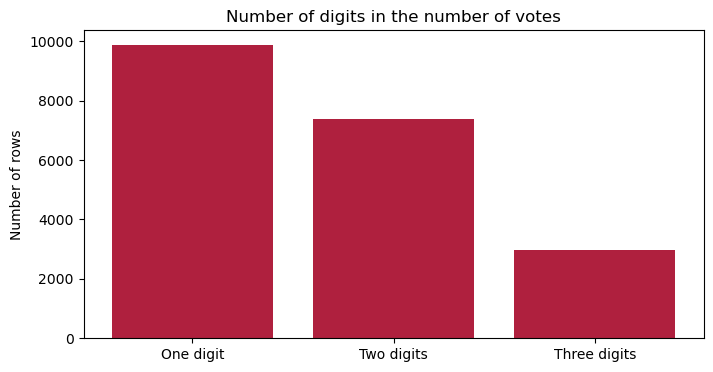

,digit,value,percentage,difference
0,One digit,9877,1.000000,0
1,Two digits,7393,0.748507,-2484
2,Three digits,2978,0.301509,-4415


In [347]:
onep=veneto['VOTI_LISTA'].shape[0]
twop=veneto[veneto['VOTI_LISTA'] >= 10].shape[0]
threep=veneto[veneto['VOTI_LISTA'] >= 100].shape[0]

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(['One digit', 'Two digits', 'Three digits'], [onep, twop, threep], color='#af203e')
ax.set_title('Number of digits in the number of votes')
ax.set_ylabel('Number of rows')
plt.show()

onep, twop, threep

data = {'digit': ['One digit', 'Two digits', 'Three digits'],
        'value': [onep, twop, threep],
        'percentage': [onep/onep, twop/onep, threep/onep],
        'difference': [0, twop-onep, threep-twop]}

digits = pd.DataFrame(data)
digits


##### Tests

In [348]:
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(veneto['VOTI_LISTA'], 1).values())[1:]
N=onep
z_value1 = calculate_z_statistic(AP, BP, N)

BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(veneto['VOTI_LISTA'], 2).values())
N=twop
z_value2 = calculate_z_statistic(AP, BP, N)

BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(veneto['VOTI_LISTA']).values())
N=twop
z_value12 = calculate_z_statistic(AP, BP, N)

z_value1, z_value2, z_value12


N: 9877
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.3070
  Expected proportion (BP): 0.3010
  Z-statistic: 1.2772
  p-value: 0.201514
  Critical value at alpha=0.10000%: 3.2905
  Fail to reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Fail to reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Fail to reject null hypothesis at alpha=5.00000%
Digit 2:
  Actual proportion (DP): 0.1872
  Expected proportion (BP): 0.1761
  Z-statistic: 2.8859
  p-value: 0.003902
  Critical value at alpha=0.10000%: 3.2905
  Fail to reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Reject null hypothesis at alpha=5.00000%
Digit 3:
  Actual proportion (DP): 0.1218
  Expected proportion (BP): 0.1249
  Z-statistic: 0.9288
  p-value: 0.353014
  Critical value at alpha=0.10000%: 3.2905
  Fail to

(({'Digit_1': 1.2772494947115984,
   'Digit_2': 2.885938584159869,
   'Digit_3': 0.9287585308203835,
   'Digit_4': 0.006128987820919872,
   'Digit_5': 0.021358491106504802,
   'Digit_6': 1.1165370786532445,
   'Digit_7': 0.6150365976668507,
   'Digit_8': 3.2305812678464405,
   'Digit_9': 1.0327332615943652},
  {'Digit_1': 0.20151417808875927,
   'Digit_2': 0.003902483020864711,
   'Digit_3': 0.35301423997668335,
   'Digit_4': 0.9951098058606347,
   'Digit_5': 0.9829596853036546,
   'Digit_6': 0.26419230792248305,
   'Digit_7': 0.5385305514604088,
   'Digit_8': 0.0012353877872008923,
   'Digit_9': 0.301728743329138}),
 ({'Digit_1': 0.38379253231106114,
   'Digit_2': 2.3251349042711627,
   'Digit_3': 1.5679054655754534,
   'Digit_4': 0.6921206548721967,
   'Digit_5': 0.04175519760438554,
   'Digit_6': 0.5995742000097897,
   'Digit_7': 1.3518460043935172,
   'Digit_8': 0.7088153293782331,
   'Digit_9': 2.382490544372513,
   'Digit_10': 0.32885224467457197},
  {'Digit_1': 0.701132223358095

In [349]:
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(veneto['VOTI_LISTA'], 1).values())[1:]
K=len(BP) 

mad1 = calculate_mad(AP, BP, K)

BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(veneto['VOTI_LISTA'], 2).values())
K=len(BP) 

mad2 = calculate_mad(AP, BP, K)

BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(veneto['VOTI_LISTA']).values())
K=len(BP) 

mad12 = calculate_mad(AP, BP, K)

mad1, mad2, mad12

Number of digits (K): 9
Number of digits (K): 10
Number of digits (K): 90


(0.003790475451023007, 0.0036898647865816247, 0.00207699766578569)

In [350]:
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(veneto['VOTI_LISTA'], 1).values())[1:]
N=onep
cs_first_digit=calculate_chi_square(AP, BP, N)

BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(veneto['VOTI_LISTA'], 2).values())
N=twop

cs_second_digit=calculate_chi_square(AP, BP, N)

BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(veneto['VOTI_LISTA']).values())
N=twop

cs_firsttwo_digits=calculate_chi_square(AP, BP, N)

cs_first_digit, cs_second_digit, cs_firsttwo_digits

N: 9877
Chi-Square statistic: 21.5625
p-value: 0.005794
At alpha=0.001000: Fail to reject the null hypothesis
At alpha=0.010000: Reject the null hypothesis
At alpha=0.050000: Reject the null hypothesis
N: 7393
Chi-Square statistic: 15.6250
p-value: 0.075137
At alpha=0.001000: Fail to reject the null hypothesis
At alpha=0.010000: Fail to reject the null hypothesis
At alpha=0.050000: Fail to reject the null hypothesis
N: 7393
Chi-Square statistic: 351.7561
p-value: 0.000000
At alpha=0.001000: Reject the null hypothesis
At alpha=0.010000: Reject the null hypothesis
At alpha=0.050000: Reject the null hypothesis


(({0.001: {'chi_square': 21.562463703321402,
    'p_value': '0.005794',
    'decision': 'Fail to reject the null hypothesis',
    'degrees of freedom': 8},
   0.01: {'chi_square': 21.562463703321402,
    'p_value': '0.005794',
    'decision': 'Reject the null hypothesis',
    'degrees of freedom': 8},
   0.05: {'chi_square': 21.562463703321402,
    'p_value': '0.005794',
    'decision': 'Reject the null hypothesis',
    'degrees of freedom': 8}},
  21.562463703321402,
  0.005794259262148493),
 ({0.001: {'chi_square': 15.625016012944469,
    'p_value': '0.075137',
    'decision': 'Fail to reject the null hypothesis',
    'degrees of freedom': 9},
   0.01: {'chi_square': 15.625016012944469,
    'p_value': '0.075137',
    'decision': 'Fail to reject the null hypothesis',
    'degrees of freedom': 9},
   0.05: {'chi_square': 15.625016012944469,
    'p_value': '0.075137',
    'decision': 'Fail to reject the null hypothesis',
    'degrees of freedom': 9}},
  15.625016012944469,
  0.075137319

In [351]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(benford_nth_digit_probabilities(1).values())[1:], start_digit=1, num_digits=9), 
      " | Uniform FSD Mean:", calculate_fsd_mean(uniform_first_digit, start_digit=1, num_digits=9),
        " | Veneto FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities(veneto['VOTI_LISTA'], 1).values())[1:], start_digit=1, num_digits=9))

print("Benford's Law FSD Mean:", calculate_fsd_mean(list(benford_nth_digit_probabilities(2).values()), start_digit=0, num_digits=10), 
    " | Uniform FSD Mean:", calculate_fsd_mean(uniform_other_digits, start_digit=0, num_digits=10),
    " | Veneto FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities(veneto['VOTI_LISTA'], 2).values()), start_digit=0, num_digits=10))

print("Benford's Law FSD Mean:", calculate_fsd_mean(list(Benford_theory_firsttwo_digits().values()), start_digit=10, num_digits=90),
       " | Uniform FSD Mean:", calculate_fsd_mean(uniform_10_99, start_digit=10, num_digits=90), 
         " | Veneto FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities_firsttwo(veneto['VOTI_LISTA']).values()), start_digit=10, num_digits=90))



Benford's Law FSD Mean: 3.440236967123206  | Uniform FSD Mean: 5.0  | Veneto FSD Mean: 3.3530424217879924
Benford's Law FSD Mean: 4.1873897069289425  | Uniform FSD Mean: 4.500000000000001  | Veneto FSD Mean: 4.085351007709996
Benford's Law FSD Mean: 38.589759378161006  | Uniform FSD Mean: 54.5  | Veneto FSD Mean: 33.71202488840797


In [352]:
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(veneto['VOTI_LISTA'], 1).values())[1:]
sum_squares_deviation(BP, AP)

2.3605323217119705

In [353]:
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(veneto['VOTI_LISTA'], 2).values())
sum_squares_deviation(BP, AP)

2.124102135383561

In [354]:
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(veneto['VOTI_LISTA']).values())
sum_squares_deviation(BP, AP)

7.019746004093844

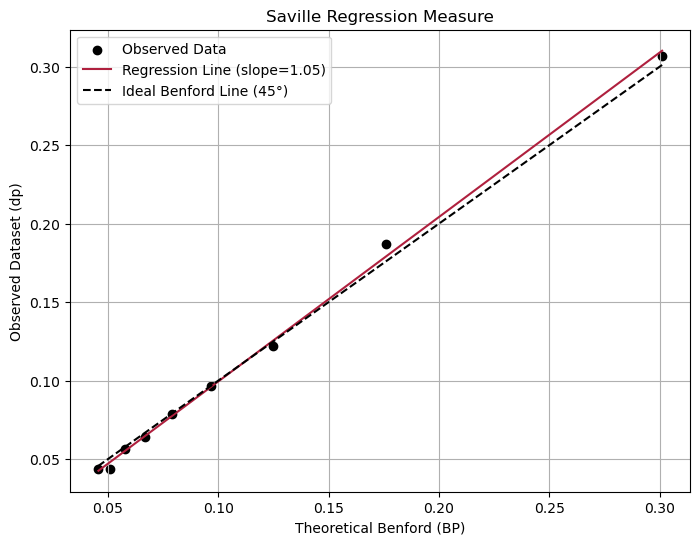

Slope (b1): 1.0478, Z-score: 2.7812, p-value: 0.0054
Intercept (b0): -0.0053, Z-score: -2.2791, p-value: 0.0227
Joint Test (b0=0 and b1=1), Z-score: 3.5957, p-value: 0.0003
Reject H0 at α=0.001: True
Reject H0 at α=0.01: True
Reject H0 at α=0.05: True


{'slope': 1.0477518867903122,
 'intercept': -0.005305765198923576,
 'z_slope': 2.7811773023144104,
 'z_intercept': -2.279132737411401,
 'joint_z': 3.5957465458023106,
 'p_slope': 0.005416214755993298,
 'p_intercept': 0.022659175982548962,
 'p_joint': 0.0003234626159305254,
 'hypothesis_results': {0.001: True, 0.01: True, 0.05: True}}

In [355]:
result = saville_regression(list(benford_nth_digit_probabilities(1).values())[1:], list(data_digit_probabilities(veneto['VOTI_LISTA'], 1).values())[1:])
result

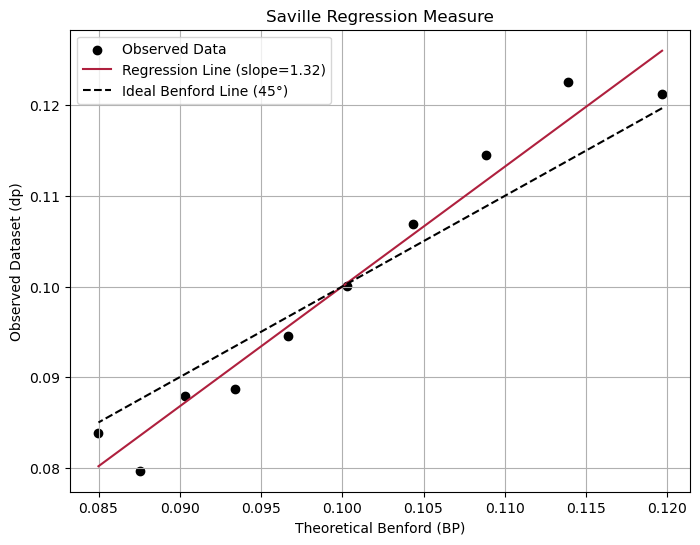

Slope (b1): 1.3223, Z-score: 3.3857, p-value: 0.0007
Intercept (b0): -0.0322, Z-score: -3.3654, p-value: 0.0008
Joint Test (b0=0 and b1=1), Z-score: 4.7738, p-value: 0.0000
Reject H0 at α=0.001: True
Reject H0 at α=0.01: True
Reject H0 at α=0.05: True


{'slope': 1.322278432547445,
 'intercept': -0.032227843254744454,
 'z_slope': 3.3856520952742177,
 'z_intercept': -3.365444881631047,
 'joint_z': 4.773767836995355,
 'p_slope': 0.0007100934663939462,
 'p_intercept': 0.0007642033367756262,
 'p_joint': 1.808108081480242e-06,
 'hypothesis_results': {0.001: True, 0.01: True, 0.05: True}}

In [356]:
result = saville_regression(list(benford_nth_digit_probabilities(2).values()), list(data_digit_probabilities(veneto['VOTI_LISTA'], 2).values()))
result

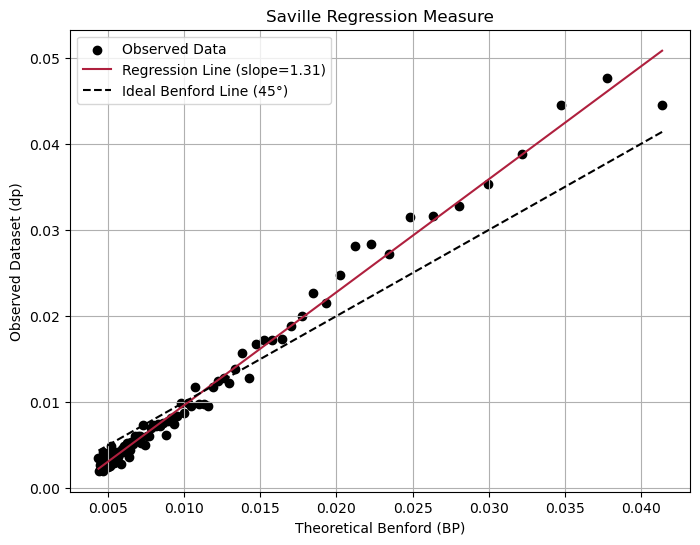

Slope (b1): 1.3115, Z-score: 19.3595, p-value: 0.0000
Intercept (b0): -0.0035, Z-score: -15.6652, p-value: 0.0000
Joint Test (b0=0 and b1=1), Z-score: 24.9036, p-value: 0.0000
Reject H0 at α=0.001: True
Reject H0 at α=0.01: True
Reject H0 at α=0.05: True


{'slope': 1.3115024529921364,
 'intercept': -0.0034611383665792885,
 'z_slope': 19.359543178343735,
 'z_intercept': -15.665168193041179,
 'joint_z': 24.903602281405487,
 'p_slope': 0.0,
 'p_intercept': 0.0,
 'p_joint': 0.0,
 'hypothesis_results': {0.001: True, 0.01: True, 0.05: True}}

In [357]:
result = saville_regression(list(Benford_theory_firsttwo_digits().values()), list(data_digit_probabilities_firsttwo(veneto['VOTI_LISTA']).values()))
result

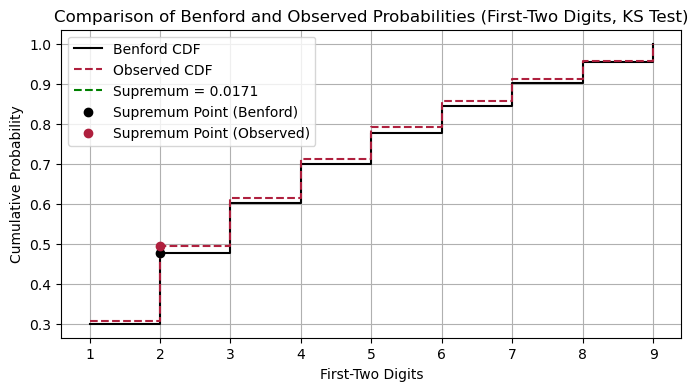

Supremum: 0.0171
First Digits of Supremum: 2
P-value (manual calculation): 0.0059

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=1:
Alpha level: 0.001000
Alpha level: 0.010000
Alpha level: 0.050000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=115:
Alpha level: 0.000009
Alpha level: 0.000087
Alpha level: 0.000435

Total observations (n): 10000


In [358]:
benford_digits = list(benford_nth_digit_probabilities(1).keys())[1:]
benford_probs = list(benford_nth_digit_probabilities(1).values())[1:]
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities(veneto['VOTI_LISTA'], 1).keys())[1:]
election_probs = list(data_digit_probabilities(veneto['VOTI_LISTA'], 1).values())[1:]
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the KS statistic manually
supremum, supremum_index = calculate_ks_manually(benford_cumulative, election_cumulative)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Calculate the theoretical p-value manually
n = 10000  # Total observations
p_value_manual = manual_ks_p_value(supremum, n)

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
plt.step(range(1, 10), benford_cumulative, where="post", label="Benford CDF", color="black")
plt.step(range(1, 10), election_cumulative, where="post", label="Observed CDF", color="#af203e", linestyle="--")

# Highlight the supremum
plt.plot(
    [supremum_x, supremum_x],
    [supremum_y_benford, supremum_y_el],
    color="green",
    linestyle="--",
    label=f"Supremum = {supremum:.4f}"
)

# Add points for the supremum
plt.scatter([supremum_x], [supremum_y_benford], color="black", zorder=5, label="Supremum Point (Benford)")
plt.scatter([supremum_x], [supremum_y_el], color="#af203e", zorder=5, label="Supremum Point (Observed)")

# Customize the plot
plt.xlabel("First-Two Digits")
plt.ylabel("Cumulative Probability")
plt.title("Comparison of Benford and Observed Probabilities (First-Two Digits, KS Test)")
plt.legend()
plt.grid(True)
plt.show()

# Print results
print(f"Supremum: {supremum:.4f}")
print(f"First Digits of Supremum: {supremum_x}")
print(f"P-value (manual calculation): {p_value_manual:.4f}\n")

for num_tests, adjusted_alpha_levels in alpha_levels_results.items():
    print(f"Adjusted Alpha Levels (Bonferroni Correction) for num_tests={num_tests}:")
    for alpha in adjusted_alpha_levels:
        print(f"Alpha level: {alpha:.6f}")
    print()

print(f"Total observations (n): {n}")


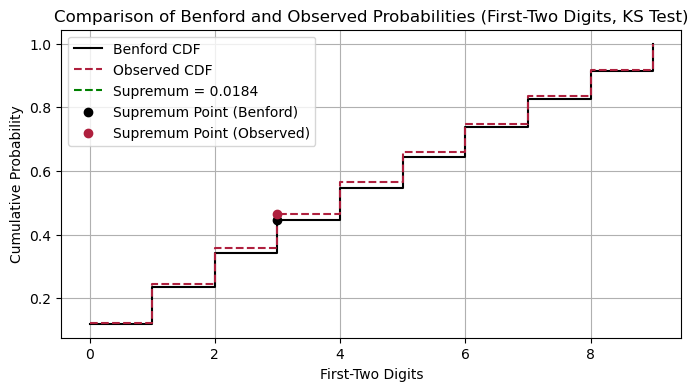

Supremum: 0.0184
First Digits of Supremum: 3
P-value (manual calculation): 0.0022

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=1:
Alpha level: 0.001000
Alpha level: 0.010000
Alpha level: 0.050000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=115:
Alpha level: 0.000009
Alpha level: 0.000087
Alpha level: 0.000435

Total observations (n): 10000


In [359]:
# Calculate cumulative proportions for Benford's law and first position of the election data
benford_digits = list(benford_nth_digit_probabilities(2).keys())
benford_probs = list(benford_nth_digit_probabilities(2).values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities(veneto['VOTI_LISTA'], 2).keys())
election_probs = list(data_digit_probabilities(veneto['VOTI_LISTA'], 2).values())
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the KS statistic manually
supremum, supremum_index = calculate_ks_manually(benford_cumulative, election_cumulative)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Calculate the theoretical p-value manually
n = 10000  # Total observations
p_value_manual = manual_ks_p_value(supremum, n)

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
plt.step(range(0, 10), benford_cumulative, where="post", label="Benford CDF", color="black")
plt.step(range(0, 10), election_cumulative, where="post", label="Observed CDF", color="#af203e", linestyle="--")

# Highlight the supremum
plt.plot(
    [supremum_x, supremum_x],
    [supremum_y_benford, supremum_y_el],
    color="green",
    linestyle="--",
    label=f"Supremum = {supremum:.4f}"
)

# Add points for the supremum
plt.scatter([supremum_x], [supremum_y_benford], color="black", zorder=5, label="Supremum Point (Benford)")
plt.scatter([supremum_x], [supremum_y_el], color="#af203e", zorder=5, label="Supremum Point (Observed)")

# Customize the plot
plt.xlabel("First-Two Digits")
plt.ylabel("Cumulative Probability")
plt.title("Comparison of Benford and Observed Probabilities (First-Two Digits, KS Test)")
plt.legend()
plt.grid(True)
plt.show()

# Print results
print(f"Supremum: {supremum:.4f}")
print(f"First Digits of Supremum: {supremum_x}")
print(f"P-value (manual calculation): {p_value_manual:.4f}\n")

for num_tests, adjusted_alpha_levels in alpha_levels_results.items():
    print(f"Adjusted Alpha Levels (Bonferroni Correction) for num_tests={num_tests}:")
    for alpha in adjusted_alpha_levels:
        print(f"Alpha level: {alpha:.6f}")
    print()

print(f"Total observations (n): {n}")


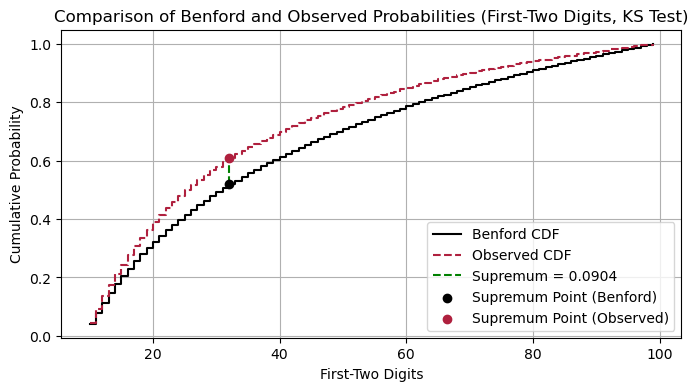

Supremum: 0.0904
First Digits of Supremum: 32
P-value (manual calculation): 0.0000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=1:
Alpha level: 0.001000
Alpha level: 0.010000
Alpha level: 0.050000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=115:
Alpha level: 0.000009
Alpha level: 0.000087
Alpha level: 0.000435

Total observations (n): 10000


In [360]:
# Calculate cumulative proportions for Benford's law and first position of the election data
benford_digits = list(Benford_theory_firsttwo_digits().keys())
benford_probs = list(Benford_theory_firsttwo_digits().values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities_firsttwo(veneto['VOTI_LISTA']).keys())
election_probs = list(data_digit_probabilities_firsttwo(veneto['VOTI_LISTA']).values())
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the KS statistic manually
supremum, supremum_index = calculate_ks_manually(benford_cumulative, election_cumulative)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Calculate the theoretical p-value manually
n = 10000  # Total observations
p_value_manual = manual_ks_p_value(supremum, n)

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
plt.step(range(10, 100), benford_cumulative, where="post", label="Benford CDF", color="black")
plt.step(range(10, 100), election_cumulative, where="post", label="Observed CDF", color="#af203e", linestyle="--")

# Highlight the supremum
plt.plot(
    [supremum_x, supremum_x],
    [supremum_y_benford, supremum_y_el],
    color="green",
    linestyle="--",
    label=f"Supremum = {supremum:.4f}"
)

# Add points for the supremum
plt.scatter([supremum_x], [supremum_y_benford], color="black", zorder=5, label="Supremum Point (Benford)")
plt.scatter([supremum_x], [supremum_y_el], color="#af203e", zorder=5, label="Supremum Point (Observed)")

# Customize the plot
plt.xlabel("First-Two Digits")
plt.ylabel("Cumulative Probability")
plt.title("Comparison of Benford and Observed Probabilities (First-Two Digits, KS Test)")
plt.legend()
plt.grid(True)
plt.show()

# Print results
print(f"Supremum: {supremum:.4f}")
print(f"First Digits of Supremum: {supremum_x}")
print(f"P-value (manual calculation): {p_value_manual:.4f}\n")

for num_tests, adjusted_alpha_levels in alpha_levels_results.items():
    print(f"Adjusted Alpha Levels (Bonferroni Correction) for num_tests={num_tests}:")
    for alpha in adjusted_alpha_levels:
        print(f"Alpha level: {alpha:.6f}")
    print()

print(f"Total observations (n): {n}")


### Brexit referendum

In [361]:
file_path = "C:/Users/franc/Documents/Università/Thesis/Benford/Codice/Dati/EU-referendum-result-data.csv"
brexit_data = pd.read_csv(file_path)
brexit_data
brexit_data.columns



Index(['id', 'Region_Code', 'Region', 'Area_Code', 'Area', 'Electorate',
       'ExpectedBallots', 'VerifiedBallotPapers', 'Pct_Turnout', 'Votes_Cast',
       'Valid_Votes', 'Remain', 'Leave', 'Rejected_Ballots',
       'No_official_mark', 'Voting_for_both_answers', 'Writing_or_mark',
       'Unmarked_or_void', 'Pct_Remain', 'Pct_Leave', 'Pct_Rejected'],
      dtype='object')

In [362]:
brexit_data = brexit_data[['Area', 'Remain', 'Leave', 'Valid_Votes']]
brexit_data

,Area,Remain,Leave,Valid_Votes
0,Peterborough,34176,53216,87392
1,Luton,36708,47773,84481
2,Southend-on-Sea,39348,54522,93870
3,Thurrock,22151,57765,79916
4,Bedford,41497,44569,86066
...,...,...,...,...
377,Bradford,104575,123913,228488
378,Calderdale,46950,58975,105925
379,Kirklees,98485,118755,217240
380,Leeds,194863,192474,387337


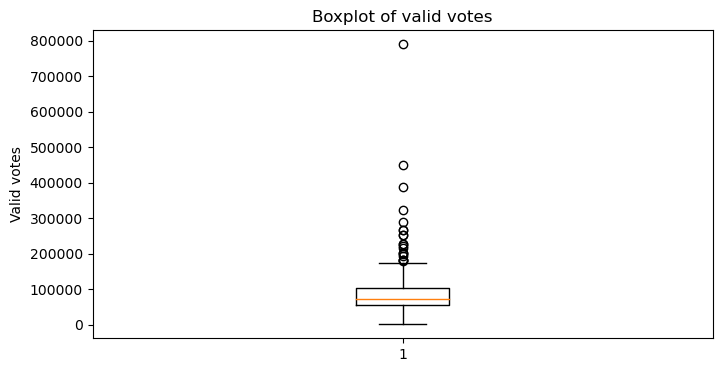

In [363]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.boxplot(brexit_data['Valid_Votes'])
ax.set_title('Boxplot of valid votes')
ax.set_ylabel('Valid votes')
plt.show()



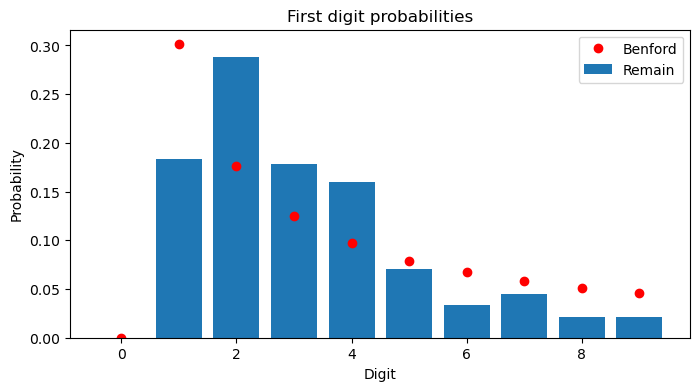

In [364]:
remain_benford = data_digit_probabilities(brexit_data['Remain'], 1)
remain_benford

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(1).keys()), list(benford_nth_digit_probabilities(1).values()), 'ro', label='Benford')
ax.bar(remain_benford.keys(), remain_benford.values(), label='Remain')
ax.set_title('First digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


In [365]:
N=len(brexit_data)
N


382

In [366]:
#compute the z-statistic for the remain_benford first digit
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(remain_benford,1))[1:]
N=len(brexit_data)
z_value = calculate_z_statistic(AP, BP, N)
print(f"Z-statistic value: {z_value}")


N: 382
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 1.0000
  Expected proportion (BP): 0.3010
  Z-statistic: 29.7264
  p-value: 0.000000
  Critical value at alpha=0.10000%: 3.2905
  Reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Reject null hypothesis at alpha=5.00000%
Digit 2:
  Actual proportion (DP): 2.0000
  Expected proportion (BP): 0.1761
  Z-statistic: 93.5222
  p-value: 0.000000
  Critical value at alpha=0.10000%: 3.2905
  Reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Reject null hypothesis at alpha=5.00000%
Digit 3:
  Actual proportion (DP): 3.0000
  Expected proportion (BP): 0.1249
  Z-statistic: 169.8687
  p-value: 0.000000
  Critical value at alpha=0.10000%: 3.2905
  Reject null hypothesis at alpha=0.10

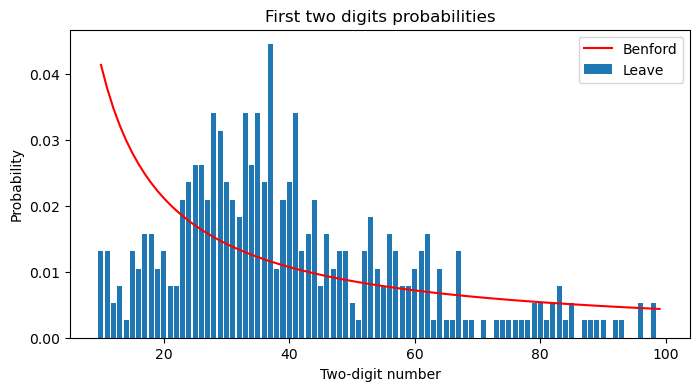

In [367]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(Benford_theory_firsttwo_digits().keys()), list(Benford_theory_firsttwo_digits().values()), 'r', label='Benford')
ax.bar(data_digit_probabilities_firsttwo(brexit_data['Leave']).keys(), data_digit_probabilities_firsttwo(brexit_data['Leave']).values(), label='Leave')
ax.set_title('First two digits probabilities')
ax.set_xlabel('Two-digit number')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


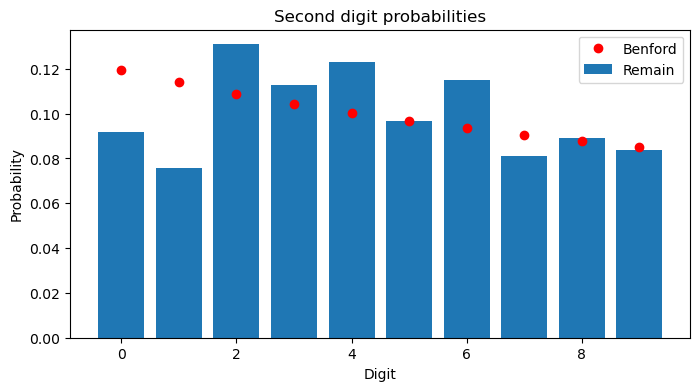

In [368]:
remain_benford = data_digit_probabilities(brexit_data['Remain'], 2)
remain_benford

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(2).keys()), list(benford_nth_digit_probabilities(2).values()), 'ro', label='Benford')
ax.bar(remain_benford.keys(), remain_benford.values(), label='Remain')
ax.set_title('Second digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


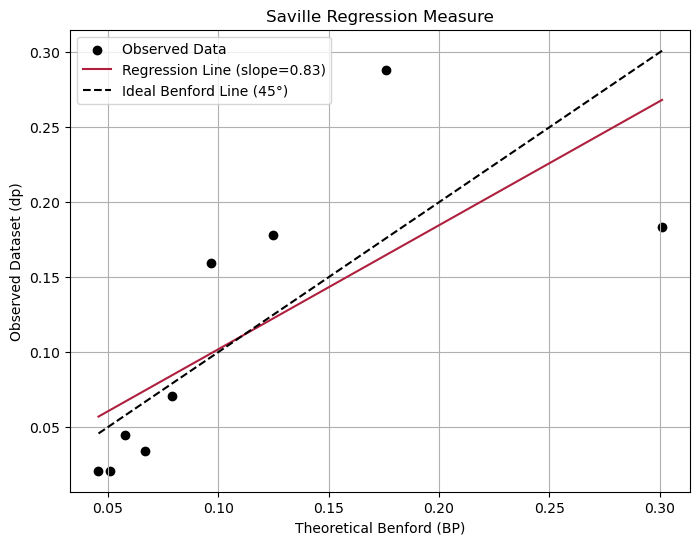

Slope (b1): 0.8273, Z-score: -0.5743, p-value: 0.5658
Intercept (b0): 0.0192, Z-score: 0.4706, p-value: 0.6379
Joint Test (b0=0 and b1=1), Z-score: 0.7425, p-value: 0.4578
Reject H0 at α=0.001: False
Reject H0 at α=0.01: False
Reject H0 at α=0.05: False


{'slope': 0.827332626761361,
 'intercept': 0.019185263693182117,
 'z_slope': -0.5742597065965742,
 'z_intercept': 0.4705971445946159,
 'joint_z': 0.7424526133841737,
 'p_slope': 0.5657920712924305,
 'p_intercept': 0.6379284471094244,
 'p_joint': 0.45781315225316677,
 'hypothesis_results': {0.001: False, 0.01: False, 0.05: False}}

In [369]:
result = saville_regression(list(benford_nth_digit_probabilities(1).values())[1:], list(data_digit_probabilities(brexit_data['Remain'], 1).values())[1:])
result

### United states presidential election of 2020

#### Data cleaning and preparation

Datased is charged from an Excel file, reading only the sheet "9. 2020 Pres General Results"

In [370]:
file_path = "C:/Users/franc/Documents/Università/Thesis/Benford/Codice/Dati/federalelections2020.xlsx"
election_data_20 = pd.read_excel(file_path, sheet_name="9. 2020 Pres General Results")
election_data_20


,1,FEC ID,STATE,STATE ABBREVIATION,GENERAL ELECTION DATE,FIRST NAME,LAST NAME,"LAST NAME, FIRST",TOTAL VOTES,PARTY,GENERAL RESULTS,GENERAL %,TOTAL VOTES #,COMBINED GE PARTY TOTALS (NY),COMBINED % (NY),WINNER INDICATOR,ELECTORAL VOTES,FOOTNOTES
0,2,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,P80001571,Alabama,AL,2020-11-03,Donald J.,Trump,"Trump, Donald J.",NaN,R,1441170.0,0.620316,NaN,NaN,NaN,W,9,NaN
2,4,P80000722,Alabama,AL,2020-11-03,Joseph R.,Biden,"Biden, Joseph R.",NaN,D,849624.0,0.365700,NaN,NaN,NaN,NaN,NaN,NaN
3,5,P00013524,Alabama,AL,2020-11-03,Jo,Jorgensen,"Jorgensen, Jo",NaN,IND,25176.0,0.010836,NaN,NaN,NaN,NaN,NaN,NaN
4,6,NaN,Alabama,AL,2020-11-03,NaN,Scattered,Scattered,NaN,W,7312.0,0.003147,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,678,P00016550,Wyoming,WY,2020-11-03,Brock,Pierce,"Pierce, Brock",NaN,IND,2208.0,0.007978,NaN,NaN,NaN,NaN,NaN,NaN
677,679,NaN,Wyoming,WY,2020-11-03,NaN,Scattered,Scattered,NaN,W,1739.0,0.006283,NaN,NaN,NaN,NaN,NaN,NaN
678,680,NaN,Wyoming,WY,2020-11-03,NaN,NaN,NaN,Total State Votes:,NaN,NaN,NaN,276765.0,NaN,NaN,NaN,NaN,NaN
679,681,NaN,NaN,NaN,2020-11-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


All the rows without a name are removed.

In [371]:
election_data_20 = election_data_20.dropna(subset=['FIRST NAME'])
election_data_20

,1,FEC ID,STATE,STATE ABBREVIATION,GENERAL ELECTION DATE,FIRST NAME,LAST NAME,"LAST NAME, FIRST",TOTAL VOTES,PARTY,GENERAL RESULTS,GENERAL %,TOTAL VOTES #,COMBINED GE PARTY TOTALS (NY),COMBINED % (NY),WINNER INDICATOR,ELECTORAL VOTES,FOOTNOTES
1,3,P80001571,Alabama,AL,2020-11-03,Donald J.,Trump,"Trump, Donald J.",NaN,R,1441170.0,0.620316,NaN,NaN,NaN,W,9,NaN
2,4,P80000722,Alabama,AL,2020-11-03,Joseph R.,Biden,"Biden, Joseph R.",NaN,D,849624.0,0.365700,NaN,NaN,NaN,NaN,NaN,NaN
3,5,P00013524,Alabama,AL,2020-11-03,Jo,Jorgensen,"Jorgensen, Jo",NaN,IND,25176.0,0.010836,NaN,NaN,NaN,NaN,NaN,NaN
7,9,P80001571,Alaska,AK,2020-11-03,Donald J.,Trump,"Trump, Donald J.",NaN,R,189951.0,0.528331,NaN,NaN,NaN,W,3,NaN
8,10,P80000722,Alaska,AK,2020-11-03,"Joseph R., Jr.",Biden,"Biden, Joseph R., Jr.",NaN,D,153778.0,0.427720,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,672,P00007864,Wisconsin,WI,2020-11-03,Kasey,Wells,"Wells, Kasey",NaN,W,25.0,0.000008,NaN,NaN,NaN,NaN,NaN,NaN
673,675,P80001571,Wyoming,WY,2020-11-03,Donald J.,Trump,"Trump, Donald J.",NaN,R,193559.0,0.699362,NaN,NaN,NaN,W,3,NaN
674,676,P80000722,Wyoming,WY,2020-11-03,Joseph R.,Biden,"Biden, Joseph R.",NaN,D,73491.0,0.265536,NaN,NaN,NaN,NaN,NaN,NaN
675,677,P00013524,Wyoming,WY,2020-11-03,Jo,Jorgensen,"Jorgensen, Jo",NaN,LIB,5768.0,0.020841,NaN,NaN,NaN,NaN,NaN,NaN


Only interesting rows are kept.

In [372]:
election_data_20 = election_data_20[['STATE', 'FIRST NAME', 'LAST NAME', 'PARTY', 'GENERAL RESULTS']]
election_data_20


,STATE,FIRST NAME,LAST NAME,PARTY,GENERAL RESULTS
1,Alabama,Donald J.,Trump,R,1441170.0
2,Alabama,Joseph R.,Biden,D,849624.0
3,Alabama,Jo,Jorgensen,IND,25176.0
7,Alaska,Donald J.,Trump,R,189951.0
8,Alaska,"Joseph R., Jr.",Biden,D,153778.0
...,...,...,...,...,...
670,Wisconsin,Kasey,Wells,W,25.0
673,Wyoming,Donald J.,Trump,R,193559.0
674,Wyoming,Joseph R.,Biden,D,73491.0
675,Wyoming,Jo,Jorgensen,LIB,5768.0


We removed from the subset the rows where we the number of votes is NaN. This rows corresponds to the state of New York. In this state Conservative Party of New York State cross-endorsed the Republican ticket, nominating Donald Trump for president and Mike Pence for vice president and the Working Families Party cross-endorsed the Democratic ticket, nominating Joe Biden for president and Kamala Harris for vice president. So, in this state, Joe Biden and Donald Trump havve two parties that support them but the votes are counted as a candidate.

we romove the row where the sum of combined parties is calculated so we have, in New York state, two Joe Biden and two Donald Trump.


In [373]:
election_data_20 = election_data_20.dropna(subset=['GENERAL RESULTS'])
election_data_20['GENERAL RESULTS'] = election_data_20['GENERAL RESULTS'].astype(int)
election_data_20

C:\Users\franc\AppData\Local\Temp\ipykernel_5012\581946449.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  election_data_20['GENERAL RESULTS'] = election_data_20['GENERAL RESULTS'].astype(int)


,STATE,FIRST NAME,LAST NAME,PARTY,GENERAL RESULTS
1,Alabama,Donald J.,Trump,R,1441170
2,Alabama,Joseph R.,Biden,D,849624
3,Alabama,Jo,Jorgensen,IND,25176
7,Alaska,Donald J.,Trump,R,189951
8,Alaska,"Joseph R., Jr.",Biden,D,153778
...,...,...,...,...,...
670,Wisconsin,Kasey,Wells,W,25
673,Wyoming,Donald J.,Trump,R,193559
674,Wyoming,Joseph R.,Biden,D,73491
675,Wyoming,Jo,Jorgensen,LIB,5768


In [374]:
election_data_20[election_data_20['GENERAL RESULTS'] == 11110639][['STATE', 'FIRST NAME', 'LAST NAME', 'PARTY']].values.tolist()

[['California', 'Joseph R.', 'Biden', 'D']]

In [375]:
election_data_20['LAST NAME'].value_counts()


Trump           52
Biden           52
Jorgensen       51
Hawkins         39
Carroll         27
                ..
Schwalb          1
Lee              1
Stanek           1
Frederickson     1
Scalf            1
Name: LAST NAME, Length: 96, dtype: int64

In [376]:
election_data_20['GENERAL RESULTS'].value_counts()

1         32
2         17
4          9
3          9
5          8
          ..
3210       1
19637      1
759061     1
897672     1
2208       1
Name: GENERAL RESULTS, Length: 418, dtype: int64

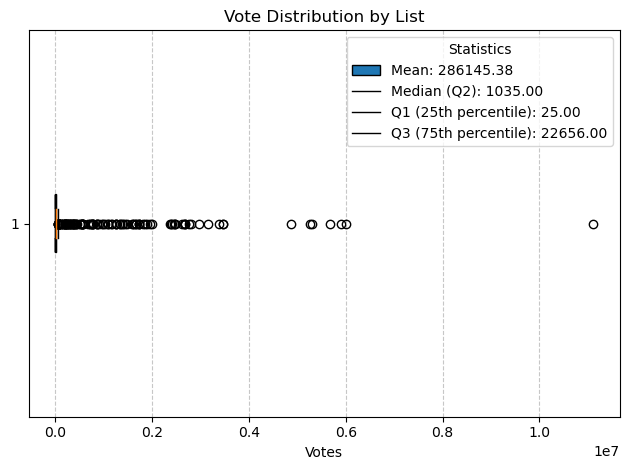

In [377]:
q1 = election_data_20['GENERAL RESULTS'].quantile(0.25)
median_value = election_data_20['GENERAL RESULTS'].median()
q3 = election_data_20['GENERAL RESULTS'].quantile(0.75)
mean_value = election_data_20['GENERAL RESULTS'].mean()

# box plot
plt.boxplot(election_data_20['GENERAL RESULTS'], vert=False, patch_artist=True, notch=True)

plt.legend(
    labels=[
        f'Mean: {mean_value:.2f}', 
        f'Median (Q2): {median_value:.2f}', 
        f'Q1 (25th percentile): {q1:.2f}', 
        f'Q3 (75th percentile): {q3:.2f}'
    ],
    loc='best',
    title='Statistics'
)

plt.xlabel('Votes')
plt.title('Vote Distribution by List')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [378]:
mean = election_data_20['GENERAL RESULTS'].mean()
median = election_data_20['GENERAL RESULTS'].median()
mean, median

(286145.38336347195, 1035.0)

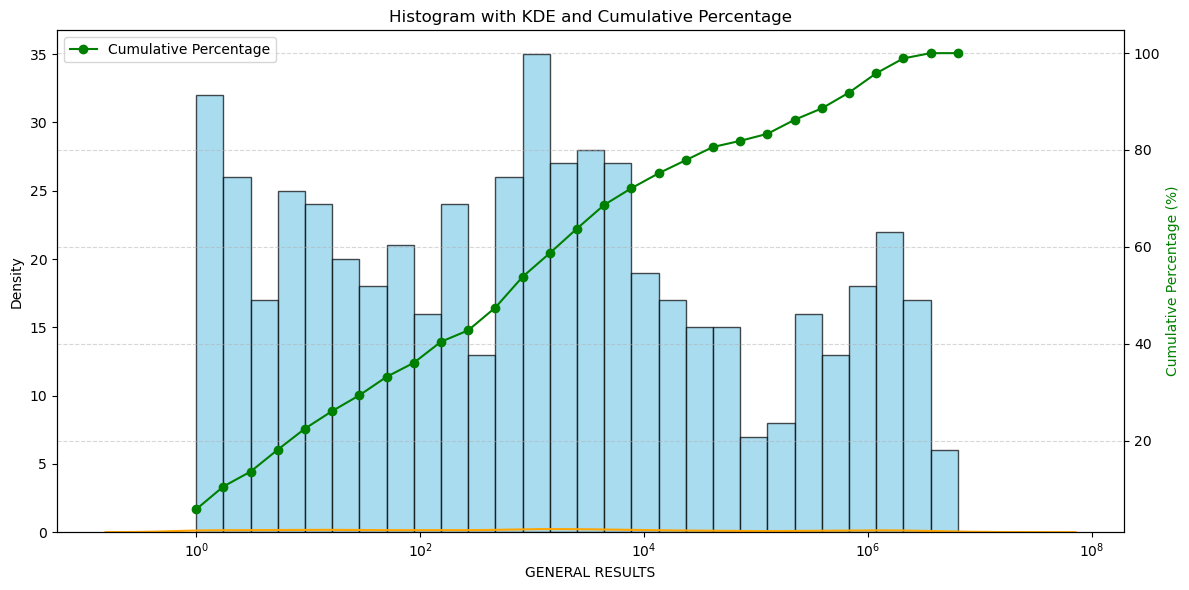

In [379]:
import seaborn as sns

data = election_data_20['GENERAL RESULTS']

bins = np.logspace(0, np.log10(max(data)), num=30)  
counts, edges = np.histogram(data, bins=bins)

cumulative_counts = np.cumsum(counts)
cumulative_percentages = cumulative_counts / cumulative_counts[-1] * 100

plt.figure(figsize=(12, 6))
plt.bar(edges[:-1], counts, width=np.diff(edges), align='edge', color='skyblue', edgecolor='black', alpha=0.7, label='Histogram')
sns.kdeplot(data, bw_adjust=0.5, color='orange', label='KDE', log_scale=True)

plt.twinx()  
plt.plot(edges[:-1], cumulative_percentages, color='green', marker='o', linestyle='-', label='Cumulative Percentage')
plt.ylabel('Cumulative Percentage (%)', color='green')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.xscale('log')
plt.xlabel('Unique Values (Log Scale)')
plt.title('Histogram with KDE and Cumulative Percentage')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()



In [380]:
election_data_20['GENERAL RESULTS'].describe()

election_data_20['GENERAL RESULTS'].describe().to_latex('election_data_20_describe.tex')


C:\Users\franc\AppData\Local\Temp\ipykernel_5012\3358927550.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  election_data_20['GENERAL RESULTS'].describe().to_latex('election_data_20_describe.tex')


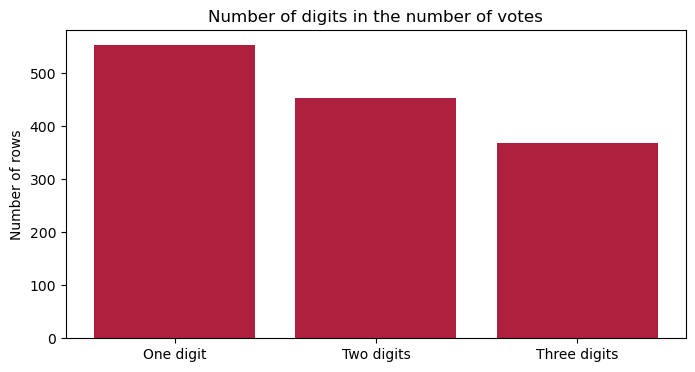

,digit,value,percentage,difference
0,One digit,553,1.000000,0
1,Two digits,453,0.819168,-100
2,Three digits,368,0.665461,-85


In [381]:
onep=election_data_20['GENERAL RESULTS'].shape[0]
twop=election_data_20[election_data_20['GENERAL RESULTS'] >= 10].shape[0]
threep=election_data_20[election_data_20['GENERAL RESULTS'] >= 100].shape[0]

#plot in bar chart onep, twop, threep
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(['One digit', 'Two digits', 'Three digits'], [onep, twop, threep], color='#af203e')
ax.set_title('Number of digits in the number of votes')
ax.set_ylabel('Number of rows')
plt.show()

onep, twop, threep

data = {'digit': ['One digit', 'Two digits', 'Three digits'],
        'value': [onep, twop, threep],
        'percentage': [onep/onep, twop/onep, threep/onep],
        'difference': [0, twop-onep, threep-twop]}

digits = pd.DataFrame(data)
digits

In [382]:
election_data_20['GENERAL RESULTS']

1      1441170
2       849624
3        25176
7       189951
8       153778
        ...   
670         25
673     193559
674      73491
675       5768
676       2208
Name: GENERAL RESULTS, Length: 553, dtype: int32

In [383]:
sorted(election_data_20['GENERAL RESULTS'].unique())



[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 36,
 43,
 46,
 47,
 48,
 49,
 51,
 52,
 53,
 54,
 55,
 56,
 58,
 61,
 64,
 65,
 67,
 68,
 74,
 75,
 78,
 82,
 84,
 87,
 89,
 98,
 100,
 110,
 112,
 114,
 119,
 121,
 125,
 126,
 131,
 137,
 141,
 142,
 159,
 163,
 166,
 169,
 170,
 175,
 180,
 181,
 185,
 186,
 190,
 192,
 195,
 196,
 205,
 208,
 209,
 212,
 213,
 217,
 219,
 236,
 255,
 318,
 332,
 337,
 350,
 354,
 355,
 362,
 368,
 379,
 407,
 408,
 411,
 437,
 495,
 536,
 544,
 546,
 559,
 568,
 572,
 579,
 611,
 614,
 619,
 636,
 643,
 659,
 662,
 664,
 668,
 669,
 693,
 701,
 716,
 749,
 762,
 767,
 795,
 825,
 847,
 854,
 855,
 856,
 860,
 895,
 923,
 931,
 963,
 987,
 989,
 999,
 1013,
 1035,
 1037,
 1082,
 1089,
 1117,
 1125,
 1127,
 1139,
 1161,
 1175,
 1183,
 1210,
 1269,
 1279,
 1282,
 1310,
 1317,
 1321,
 1336,
 1372,
 1450,
 1475,
 1491,
 1498,
 1557,
 1626,
 1640,
 1707,
 1713

#### First digit analysis

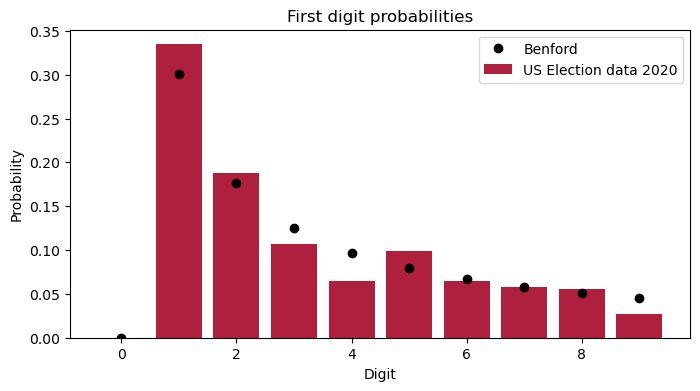

In [384]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(1).keys()), list(benford_nth_digit_probabilities(1).values()), 'ko', label='Benford')
ax.bar(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 1).keys(), data_digit_probabilities(election_data_20['GENERAL RESULTS'], 1).values(), label='US Election data 2020', color='#af203e')
ax.set_title('First digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


##### z-statistic

In [385]:
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 1).values())[1:]
N=len(election_data_20)
alpha_values = [0.001, 0.01, 0.05]
alpha_corrected_values = apply_bonferroni_correction(num_tests=115)


z_value, p_value = calculate_z_statistic(AP, BP, N, alpha_values, alpha_corrected_values)
print(f"Z-statistic value: {z_value}")

N: 553
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.3345
  Expected proportion (BP): 0.3010
  Z-statistic: 1.6715
  p-value: 0.094621
  Critical value at alpha=0.10000%: 3.2905
  Fail to reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Fail to reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Fail to reject null hypothesis at alpha=5.00000%
  Corrected critical value at alpha=0.00087%: 4.4473
  Fail to reject null hypothesis at corrected alpha=0.00087%
  Corrected critical value at alpha=0.00870%: 3.9244
  Fail to reject null hypothesis at corrected alpha=0.00870%
  Corrected critical value at alpha=0.04348%: 3.5180
  Fail to reject null hypothesis at corrected alpha=0.04348%
Digit 2:
  Actual proportion (DP): 0.1881
  Expected proportion (BP): 0.1761
  Z-statistic: 0.6834
  p-value: 0.494340
  Critical value at alpha=0.10000%: 3.2905
  Fail to reject null hypothesis at alpha=0.10000%
  

In [386]:
p_value.values()

dict_values([0.09462101570438186, 0.4943399514331741, 0.21738940219228686, 0.014019992405919668, 0.09158398773426324, 0.9292858768321426, 0.989904422924154, 0.6693137612980207, 0.046026555761645715])

In [387]:
election_data_20_first_digit = pd.DataFrame()
election_data_20_first_digit['Digit'] = list(benford_nth_digit_probabilities(1).keys())[1:]
election_data_20_first_digit['Benford'] = list(benford_nth_digit_probabilities(1).values())[1:]
election_data_20_first_digit['Election data 2020'] = list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 1).values())[1:]
election_data_20_first_digit['Difference'] = election_data_20_first_digit['Election data 2020'] - election_data_20_first_digit['Benford']
election_data_20_first_digit['Z P-value'] = list(p_value.values())  

election_data_20_first_digit


,Digit,Benford,Election data 2020,Difference,Z P-value
0,1,0.301030,0.334539,0.033509,0.094621
1,2,0.176091,0.188065,0.011974,0.494340
2,3,0.124939,0.106691,-0.018248,0.217389
3,4,0.096910,0.065099,-0.031811,0.014020
4,5,0.079181,0.099458,0.020276,0.091584
5,6,0.066947,0.065099,-0.001847,0.929286
6,7,0.057992,0.057866,-0.000126,0.989904
7,8,0.051153,0.056058,0.004905,0.669314
8,9,0.045757,0.027125,-0.018633,0.046027


##### MAD

In [388]:
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 1).values())[1:]
K=len(BP) 
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")


Number of digits (K): 9
Mean Absolute Deviation (MAD) from Benford's Law: 0.01570318350905698


##### Squared differences

In [389]:
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 1).values())[1:]
sd_first_digit=sum_squares_deviation(BP, AP)
sd_first_digit


33.96913191069093

##### Chi-squared test

In [390]:
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 1).values())[1:]
N=len(election_data_20)
alpha_corrected_values = apply_bonferroni_correction(num_tests=115)
cs_first_digit = calculate_chi_square(AP, BP, N, alpha_levels=alpha_values)
cs_first_digit_corrected = calculate_chi_square(AP, BP, N, alpha_levels=alpha_corrected_values)

cs_first_digit, cs_first_digit_corrected

N: 553
Chi-Square statistic: 17.1167
p-value: 0.028917
At alpha=0.001000: Fail to reject the null hypothesis
At alpha=0.010000: Fail to reject the null hypothesis
At alpha=0.050000: Reject the null hypothesis
N: 553
Chi-Square statistic: 17.1167
p-value: 0.028917
At alpha=0.000009: Fail to reject the null hypothesis
At alpha=0.000087: Fail to reject the null hypothesis
At alpha=0.000435: Fail to reject the null hypothesis


(({0.001: {'chi_square': 17.116681440994665,
    'p_value': '0.028917',
    'decision': 'Fail to reject the null hypothesis',
    'degrees of freedom': 8},
   0.01: {'chi_square': 17.116681440994665,
    'p_value': '0.028917',
    'decision': 'Fail to reject the null hypothesis',
    'degrees of freedom': 8},
   0.05: {'chi_square': 17.116681440994665,
    'p_value': '0.028917',
    'decision': 'Reject the null hypothesis',
    'degrees of freedom': 8}},
  17.116681440994665,
  0.028916760247990503),
 ({8.695652173913044e-06: {'chi_square': 17.116681440994665,
    'p_value': '0.028917',
    'decision': 'Fail to reject the null hypothesis',
    'degrees of freedom': 8},
   8.695652173913044e-05: {'chi_square': 17.116681440994665,
    'p_value': '0.028917',
    'decision': 'Fail to reject the null hypothesis',
    'degrees of freedom': 8},
   0.0004347826086956522: {'chi_square': 17.116681440994665,
    'p_value': '0.028917',
    'decision': 'Fail to reject the null hypothesis',
    'deg

##### FSD mean

In [391]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(benford_nth_digit_probabilities(1).values())[1:], start_digit=1, num_digits=9), 
      " | Uniform FSD Mean:", calculate_fsd_mean(uniform_first_digit, start_digit=1, num_digits=9),
        " | Election data 2020 FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 1).values())[1:], start_digit=1, num_digits=9))

Benford's Law FSD Mean: 3.440236967123206  | Uniform FSD Mean: 5.0  | Election data 2020 FSD Mean: 3.2766726943942137


##### Saville regression measure

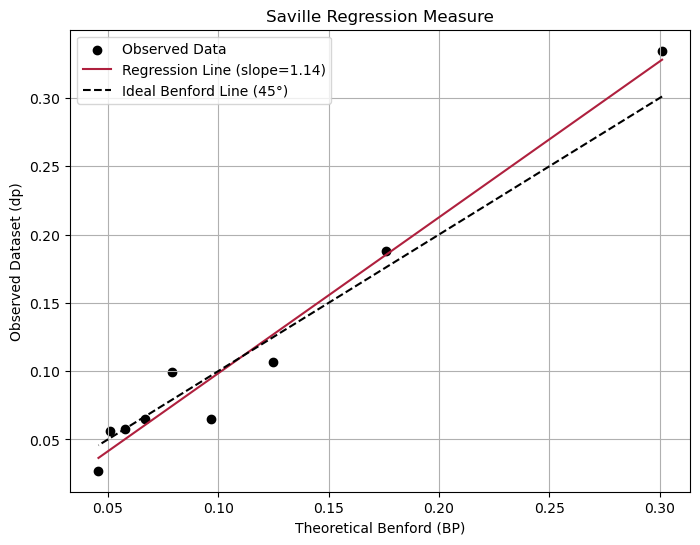

Slope (b1): 1.1418, Z-score: 1.8220, p-value: 0.0685
Intercept (b0): -0.0158, Z-score: -1.4931, p-value: 0.1354
Joint Test (b0=0 and b1=1), Z-score: 2.3556, p-value: 0.0185
Reject H0 at α=0.001: False
Reject H0 at α=0.01: False
Reject H0 at α=0.05: True


{'slope': 1.141803041318611,
 'intercept': -0.015755893479845698,
 'z_slope': 1.821981272657817,
 'z_intercept': -1.4930860977505136,
 'joint_z': 2.3556149628518783,
 'p_slope': 0.06845782725350791,
 'p_intercept': 0.13541465114618156,
 'p_joint': 0.01849207404277098,
 'hypothesis_results': {0.001: False, 0.01: False, 0.05: True}}

In [392]:
result = saville_regression(list(benford_nth_digit_probabilities(1).values())[1:], list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 1).values())[1:])
result

##### Kolmogorov-Smirnov test

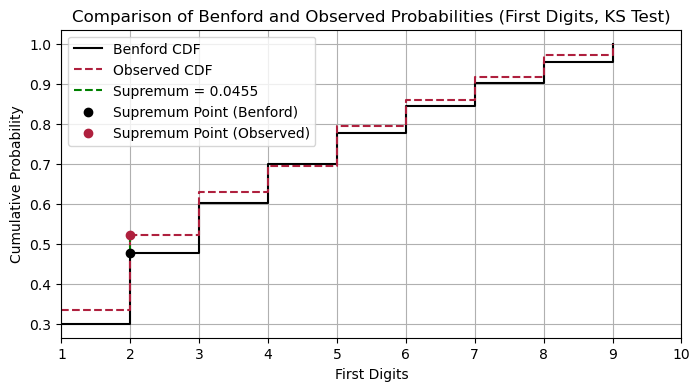

Supremum: 0.0455
First Digits of Supremum: 2
P-value (manual calculation): 0.2027

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=1:
Alpha level: 0.001000
Alpha level: 0.010000
Alpha level: 0.050000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=115:
Alpha level: 0.000009
Alpha level: 0.000087
Alpha level: 0.000435

Total observations (n): 553


In [393]:
# Compute Bonferroni-adjusted alpha levels for different num_tests
alpha_levels_results = {}
for num_tests in [1, 115]:
    alpha_levels_results[num_tests] = apply_bonferroni_correction(num_tests=num_tests)

# Compute cumulative proportions for Benford's law and observed data
benford_digits = list(benford_nth_digit_probabilities(1).keys())[1:]
benford_probs = list(benford_nth_digit_probabilities(1).values())[1:]
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities(election_data_20['GENERAL RESULTS'],1).keys())[1:]
election_probs = list(data_digit_probabilities(election_data_20['GENERAL RESULTS'],1).values())[1:]
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the KS statistic manually
supremum, supremum_index = calculate_ks_manually(benford_cumulative, election_cumulative)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Calculate the theoretical p-value manually
n = onep  # Total observations
p_value_manual = manual_ks_p_value(supremum, n)

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
plt.step(range(1, 10), benford_cumulative, where="post", label="Benford CDF", color="black")
plt.step(range(1, 10), election_cumulative, where="post", label="Observed CDF", color="#af203e", linestyle="--")

# Highlight the supremum
plt.plot(
    [supremum_x, supremum_x],
    [supremum_y_benford, supremum_y_el],
    color="green",
    linestyle="--",
    label=f"Supremum = {supremum:.4f}"
)

# Add points for the supremum
plt.scatter([supremum_x], [supremum_y_benford], color="black", zorder=5, label="Supremum Point (Benford)")
plt.scatter([supremum_x], [supremum_y_el], color="#af203e", zorder=5, label="Supremum Point (Observed)")

# Customize the plot
plt.xlabel("First Digits")
plt.ylabel("Cumulative Probability")
plt.title("Comparison of Benford and Observed Probabilities (First Digits, KS Test)")
plt.legend()
plt.grid(True)
plt.xlim(1, 10)
plt.show()

# Print results
print(f"Supremum: {supremum:.4f}")
print(f"First Digits of Supremum: {supremum_x}")
print(f"P-value (manual calculation): {p_value_manual:.4f}\n")

for num_tests, adjusted_alpha_levels in alpha_levels_results.items():
    print(f"Adjusted Alpha Levels (Bonferroni Correction) for num_tests={num_tests}:")
    for alpha in adjusted_alpha_levels:
        print(f"Alpha level: {alpha:.6f}")
    print()

print(f"Total observations (n): {n}")



In [394]:
election_data_20_first_digit = pd.DataFrame()
election_data_20_first_digit['Digit'] = list(benford_nth_digit_probabilities(1).keys())[1:]
election_data_20_first_digit['Benford'] = [round(val, 3) for val in list(benford_nth_digit_probabilities(1).values())[1:]]
election_data_20_first_digit['Election data 2020'] = [round(val, 3) for val in list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 1).values())[1:]]
election_data_20_first_digit['Difference'] = [round(val, 3) for val in (election_data_20_first_digit['Election data 2020'] - election_data_20_first_digit['Benford'])]
election_data_20_first_digit['Z test P-value'] = [round(val, 3) for val in list(p_value.values())]

election_data_20_first_digit

election_data_20_first_digit.to_latex('election_data_20_first_digit.tex', float_format="%.3f")





C:\Users\franc\AppData\Local\Temp\ipykernel_5012\4247451844.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  election_data_20_first_digit.to_latex('election_data_20_first_digit.tex', float_format="%.3f")


#### Second digit analysis

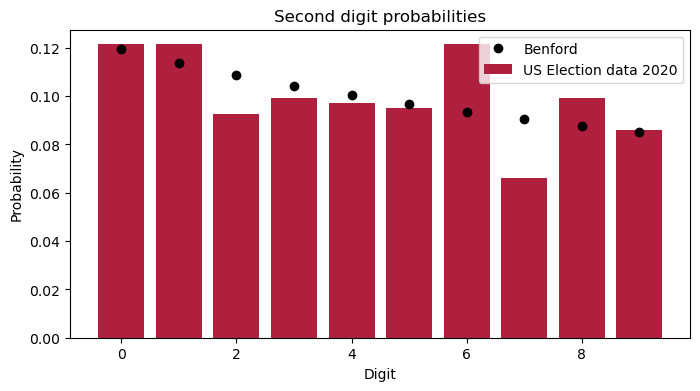

In [395]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(2).keys()), list(benford_nth_digit_probabilities(2).values()), 'ko', label='Benford')
ax.bar(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 2).keys(), data_digit_probabilities(election_data_20['GENERAL RESULTS'], 2).values(), label='US Election data 2020', color='#af203e')
ax.set_title('Second digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()

##### Z-Statistic

In [396]:
BP=list(benford_nth_digit_probabilities(2).values())
print(BP)
AP=list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 2).values())
print(AP)
N=twop
print(N)
alpha_values = [0.001, 0.01, 0.05]
alpha_corrected_values = apply_bonferroni_correction(num_tests=115)
z_value, p_value = calculate_z_statistic(AP, BP, N)
z_value, p_value = calculate_z_statistic(AP, BP, N, alpha_values, alpha_corrected_values)
print(f"Z-statistic value: {z_value}")

[0.11967926859688076, 0.1138901034075564, 0.10882149900550823, 0.10432956023095939, 0.10030820226757937, 0.09667723580232243, 0.09337473578303615, 0.09035198926960332, 0.08757005357886138, 0.08499735205769224]
[0.12141280353200883, 0.12141280353200883, 0.09271523178807947, 0.09933774834437085, 0.09713024282560706, 0.09492273730684327, 0.12141280353200883, 0.06622516556291391, 0.09933774834437085, 0.08609271523178808]
453
N: 453
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.1214
  Expected proportion (BP): 0.1197
  Z-statistic: 0.0413
  p-value: 0.967060
  Critical value at alpha=0.10000%: 3.2905
  Fail to reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Fail to reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Fail to reject null hypothesis at alpha=5.00000%
Digit 2:
  Actual proportion (DP): 0.1214
  Expected proportion (BP): 0.1139
  Z-statistic: 0.4301
  p-value: 0.667154
  Critical va

##### MAD

In [397]:
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 2).values())
K=len(BP)  
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")

Number of digits (K): 10
Mean Absolute Deviation (MAD) from Benford's Law: 0.010031472149631666


##### Squared differences

In [398]:
data_digit_probabilities(election_data_20['GENERAL RESULTS'], 2)

{0: 0.12141280353200883,
 1: 0.12141280353200883,
 2: 0.09271523178807947,
 3: 0.09933774834437085,
 4: 0.09713024282560706,
 5: 0.09492273730684327,
 6: 0.12141280353200883,
 7: 0.06622516556291391,
 8: 0.09933774834437085,
 9: 0.08609271523178808}

In [399]:
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 2).values())
sum_squares_deviation(BP, AP)

18.650192071565282

##### Chi-squared test

In [400]:
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 2).values())
N=twop
alpha_corrected_values = apply_bonferroni_correction(num_tests=115)
cs_second_digit = calculate_chi_square(AP, BP, N, alpha_levels=alpha_values)
cs_second_digit_corrected = calculate_chi_square(AP, BP, N, alpha_levels=alpha_corrected_values)

cs_second_digit, cs_second_digit_corrected

N: 453
Chi-Square statistic: 8.9397
p-value: 0.442860
At alpha=0.001000: Fail to reject the null hypothesis
At alpha=0.010000: Fail to reject the null hypothesis
At alpha=0.050000: Fail to reject the null hypothesis
N: 453
Chi-Square statistic: 8.9397
p-value: 0.442860
At alpha=0.000009: Fail to reject the null hypothesis
At alpha=0.000087: Fail to reject the null hypothesis
At alpha=0.000435: Fail to reject the null hypothesis


(({0.001: {'chi_square': 8.939683878119007,
    'p_value': '0.442860',
    'decision': 'Fail to reject the null hypothesis',
    'degrees of freedom': 9},
   0.01: {'chi_square': 8.939683878119007,
    'p_value': '0.442860',
    'decision': 'Fail to reject the null hypothesis',
    'degrees of freedom': 9},
   0.05: {'chi_square': 8.939683878119007,
    'p_value': '0.442860',
    'decision': 'Fail to reject the null hypothesis',
    'degrees of freedom': 9}},
  8.939683878119007,
  0.44286046561923886),
 ({8.695652173913044e-06: {'chi_square': 8.939683878119007,
    'p_value': '0.442860',
    'decision': 'Fail to reject the null hypothesis',
    'degrees of freedom': 9},
   8.695652173913044e-05: {'chi_square': 8.939683878119007,
    'p_value': '0.442860',
    'decision': 'Fail to reject the null hypothesis',
    'degrees of freedom': 9},
   0.0004347826086956522: {'chi_square': 8.939683878119007,
    'p_value': '0.442860',
    'decision': 'Fail to reject the null hypothesis',
    'deg

##### SSD mean

In [401]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(benford_nth_digit_probabilities(2).values()), start_digit=0, num_digits=10), 
    " | Uniform FSD Mean:", calculate_fsd_mean(uniform_other_digits, start_digit=0, num_digits=10),
    " | Election data 2020 FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 2).values()), start_digit=0, num_digits=10))

Benford's Law FSD Mean: 4.1873897069289425  | Uniform FSD Mean: 4.500000000000001  | Election data 2020 FSD Mean: 4.229580573951435


##### Saville regression measure

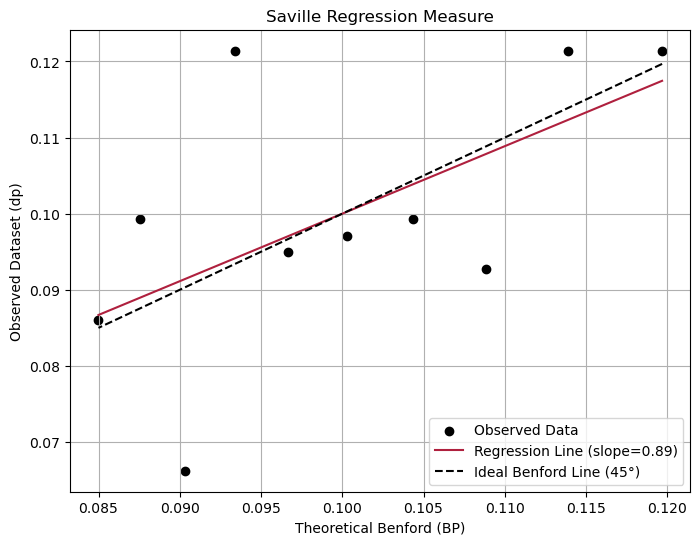

Slope (b1): 0.8871, Z-score: -0.2576, p-value: 0.7967
Intercept (b0): 0.0113, Z-score: 0.2560, p-value: 0.7979
Joint Test (b0=0 and b1=1), Z-score: 0.3632, p-value: 0.7165
Reject H0 at α=0.001: False
Reject H0 at α=0.01: False
Reject H0 at α=0.05: False


{'slope': 0.887148182944983,
 'intercept': 0.011285181705501732,
 'z_slope': -0.25757469749601364,
 'z_intercept': 0.2560373667854428,
 'joint_z': 0.363180200424784,
 'p_slope': 0.7967351594102121,
 'p_intercept': 0.7979219841962659,
 'p_joint': 0.7164702770975544,
 'hypothesis_results': {0.001: False, 0.01: False, 0.05: False}}

In [402]:
result = saville_regression(list(benford_nth_digit_probabilities(2).values()), list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 2).values()))
result

##### Kolmogorov-Smirnov test

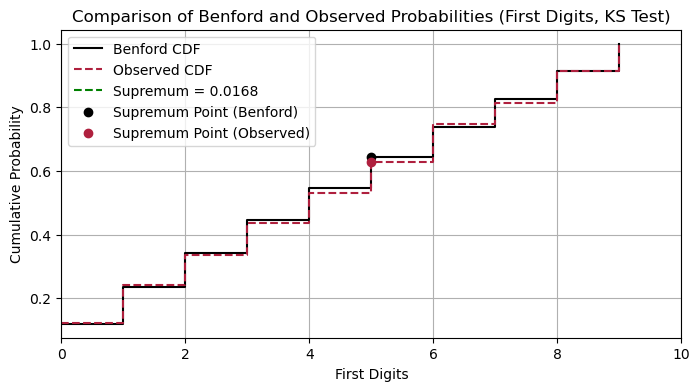

Supremum: 0.0168
First Digits of Supremum: 5
P-value (manual calculation): 0.9996

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=1:
Alpha level: 0.001000
Alpha level: 0.010000
Alpha level: 0.050000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=115:
Alpha level: 0.000009
Alpha level: 0.000087
Alpha level: 0.000435

Total observations (n): 453


In [403]:
# Compute Bonferroni-adjusted alpha levels for different num_tests
alpha_levels_results = {}
for num_tests in [1, 115]:
    alpha_levels_results[num_tests] = apply_bonferroni_correction(num_tests=num_tests)

# Compute cumulative proportions for Benford's law and observed data
benford_digits = list(benford_nth_digit_probabilities(2).keys())
benford_probs = list(benford_nth_digit_probabilities(2).values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities(election_data_20['GENERAL RESULTS'],2).keys())
election_probs = list(data_digit_probabilities(election_data_20['GENERAL RESULTS'],2).values())
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the KS statistic manually
supremum, supremum_index = calculate_ks_manually(benford_cumulative, election_cumulative)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Calculate the theoretical p-value manually
n = twop  # Total observations
p_value_manual = manual_ks_p_value(supremum, n)

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
plt.step(range(0, 10), benford_cumulative, where="post", label="Benford CDF", color="black")
plt.step(range(0, 10), election_cumulative, where="post", label="Observed CDF", color="#af203e", linestyle="--")

# Highlight the supremum
plt.plot(
    [supremum_x, supremum_x],
    [supremum_y_benford, supremum_y_el],
    color="green",
    linestyle="--",
    label=f"Supremum = {supremum:.4f}"
)

# Add points for the supremum
plt.scatter([supremum_x], [supremum_y_benford], color="black", zorder=5, label="Supremum Point (Benford)")
plt.scatter([supremum_x], [supremum_y_el], color="#af203e", zorder=5, label="Supremum Point (Observed)")

# Customize the plot
plt.xlabel("First Digits")
plt.ylabel("Cumulative Probability")
plt.title("Comparison of Benford and Observed Probabilities (First Digits, KS Test)")
plt.legend()
plt.grid(True)
plt.xlim(0, 10)
plt.show()

# Print results
print(f"Supremum: {supremum:.4f}")
print(f"First Digits of Supremum: {supremum_x}")
print(f"P-value (manual calculation): {p_value_manual:.4f}\n")

for num_tests, adjusted_alpha_levels in alpha_levels_results.items():
    print(f"Adjusted Alpha Levels (Bonferroni Correction) for num_tests={num_tests}:")
    for alpha in adjusted_alpha_levels:
        print(f"Alpha level: {alpha:.6f}")
    print()

print(f"Total observations (n): {n}")

In [404]:
election_data_20_second_digit = pd.DataFrame()
election_data_20_second_digit['Digit'] = list(benford_nth_digit_probabilities(2).keys())
election_data_20_second_digit['Benford'] = [round(val, 3) for val in list(benford_nth_digit_probabilities(2).values())]
election_data_20_second_digit['Election data 2020'] = [round(val, 3) for val in list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 2).values())]
election_data_20_second_digit['Difference'] = [round(val, 3) for val in (election_data_20_second_digit['Election data 2020'] - election_data_20_second_digit['Benford'])]
election_data_20_second_digit['Z test P-value'] = [round(val, 3) for val in list(p_value.values())]


election_data_20_second_digit

election_data_20_second_digit.to_latex('election_data_20_second_digit.tex', float_format="%.3f")

C:\Users\franc\AppData\Local\Temp\ipykernel_5012\2522168539.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  election_data_20_second_digit.to_latex('election_data_20_second_digit.tex', float_format="%.3f")


#### First-two digits

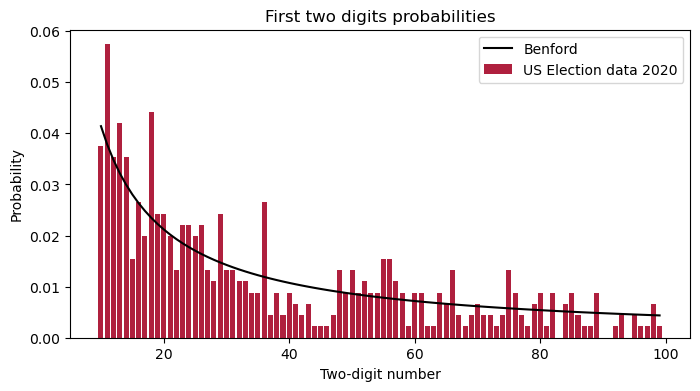

In [405]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(Benford_theory_firsttwo_digits().keys()), list(Benford_theory_firsttwo_digits().values()), 'k', label='Benford')
ax.bar(data_digit_probabilities_firsttwo(election_data_20['GENERAL RESULTS']).keys(), data_digit_probabilities_firsttwo(election_data_20['GENERAL RESULTS']).values(), label='US Election data 2020', color='#af203e')
ax.set_title('First two digits probabilities')
ax.set_xlabel('Two-digit number')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


##### Z-Statistic

In [406]:
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(election_data_20['GENERAL RESULTS']).values())
N=twop
alpha_values = [0.001, 0.01, 0.05]
alpha_corrected_values = apply_bonferroni_correction(num_tests=115)
z_value, p_value = calculate_z_statistic(AP, BP, N)
z_value, p_value = calculate_z_statistic(AP, BP, N)
z_value, p_value = calculate_z_statistic(AP, BP, N, alpha_values, alpha_corrected_values)
print(f"Z-statistic value: {z_value}")

N: 453
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.0375
  Expected proportion (BP): 0.0414
  Z-statistic: 0.2950
  p-value: 0.767960
  Critical value at alpha=0.10000%: 3.2905
  Fail to reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Fail to reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Fail to reject null hypothesis at alpha=5.00000%
Digit 2:
  Actual proportion (DP): 0.0574
  Expected proportion (BP): 0.0378
  Z-statistic: 2.0652
  p-value: 0.038900
  Critical value at alpha=0.10000%: 3.2905
  Fail to reject null hypothesis at alpha=0.10000%
  Critical value at alpha=1.00000%: 2.5758
  Fail to reject null hypothesis at alpha=1.00000%
  Critical value at alpha=5.00000%: 1.9600
  Reject null hypothesis at alpha=5.00000%
Digit 3:
  Actual proportion (DP): 0.0353
  Expected proportion (BP): 0.0348
  Z-statistic: 0.0648
  p-value: 0.948307
  Critical value at alpha=0.10000%: 3.2905
  

##### MAD

In [407]:
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(election_data_20['GENERAL RESULTS']).values())
K=len(BP)   #number of digits
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")


Number of digits (K): 90
Mean Absolute Deviation (MAD) from Benford's Law: 0.003972184101429304


##### Squared deviations

In [408]:
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(election_data_20['GENERAL RESULTS']).values())
sum_squares_deviation(BP, AP)

26.026310152540724

##### Chi-squared test

In [409]:
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(election_data_20['GENERAL RESULTS']).values())
alpha_corrected_values = apply_bonferroni_correction(num_tests=115)
cs_firsttwo_digits = calculate_chi_square(AP, BP, N, alpha_levels=alpha_values)
cs_firsttwo_digits_corrected = calculate_chi_square(AP, BP, N, alpha_levels=alpha_corrected_values)

cs_firsttwo_digits, cs_firsttwo_digits_corrected

N: 453
Chi-Square statistic: 96.3510
p-value: 0.278882
At alpha=0.001000: Fail to reject the null hypothesis
At alpha=0.010000: Fail to reject the null hypothesis
At alpha=0.050000: Fail to reject the null hypothesis
N: 453
Chi-Square statistic: 96.3510
p-value: 0.278882
At alpha=0.000009: Fail to reject the null hypothesis
At alpha=0.000087: Fail to reject the null hypothesis
At alpha=0.000435: Fail to reject the null hypothesis


(({0.001: {'chi_square': 96.35104729460281,
    'p_value': '0.278882',
    'decision': 'Fail to reject the null hypothesis',
    'degrees of freedom': 89},
   0.01: {'chi_square': 96.35104729460281,
    'p_value': '0.278882',
    'decision': 'Fail to reject the null hypothesis',
    'degrees of freedom': 89},
   0.05: {'chi_square': 96.35104729460281,
    'p_value': '0.278882',
    'decision': 'Fail to reject the null hypothesis',
    'degrees of freedom': 89}},
  96.35104729460281,
  0.27888168434297755),
 ({8.695652173913044e-06: {'chi_square': 96.35104729460281,
    'p_value': '0.278882',
    'decision': 'Fail to reject the null hypothesis',
    'degrees of freedom': 89},
   8.695652173913044e-05: {'chi_square': 96.35104729460281,
    'p_value': '0.278882',
    'decision': 'Fail to reject the null hypothesis',
    'degrees of freedom': 89},
   0.0004347826086956522: {'chi_square': 96.35104729460281,
    'p_value': '0.278882',
    'decision': 'Fail to reject the null hypothesis',
   

##### FTSD mean

In [410]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(Benford_theory_firsttwo_digits().values()), start_digit=10, num_digits=90),
       " | Uniform FSD Mean:", calculate_fsd_mean(uniform_10_99, start_digit=10, num_digits=90), 
         " | Election data 2020 FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities_firsttwo(election_data_20['GENERAL RESULTS']).values()), start_digit=10, num_digits=90))

Benford's Law FSD Mean: 38.589759378161006  | Uniform FSD Mean: 54.5  | Election data 2020 FSD Mean: 36.4812362030905


##### Saville regression measure

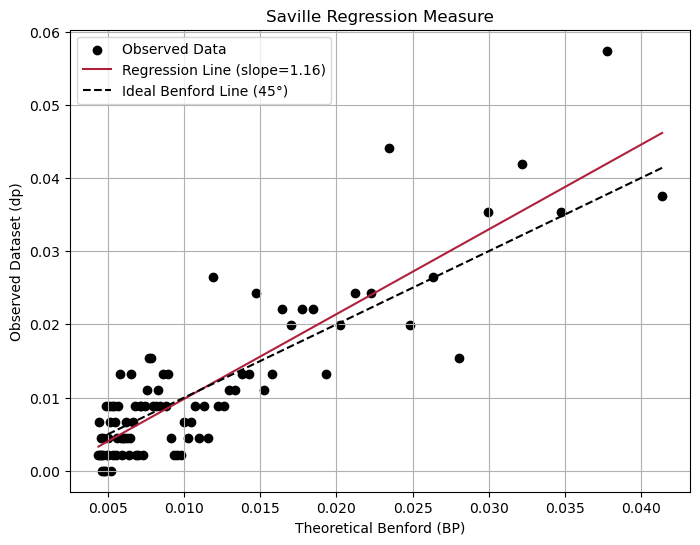

Slope (b1): 1.1574, Z-score: 2.2804, p-value: 0.0226
Intercept (b0): -0.0017, Z-score: -1.8452, p-value: 0.0650
Joint Test (b0=0 and b1=1), Z-score: 2.9334, p-value: 0.0034
Reject H0 at α=0.001: False
Reject H0 at α=0.01: True
Reject H0 at α=0.05: True


{'slope': 1.1574340706159743,
 'intercept': -0.001749267451288599,
 'z_slope': 2.280351749747041,
 'z_intercept': -1.845193007397153,
 'joint_z': 2.9333839396031576,
 'p_slope': 0.022586834855408133,
 'p_intercept': 0.06500946734257407,
 'p_joint': 0.0033528898409056485,
 'hypothesis_results': {0.001: False, 0.01: True, 0.05: True}}

In [411]:
result = saville_regression(list(Benford_theory_firsttwo_digits().values()), list(data_digit_probabilities_firsttwo(election_data_20['GENERAL RESULTS']).values()))
result

##### Kolmogorov-Smirnov test

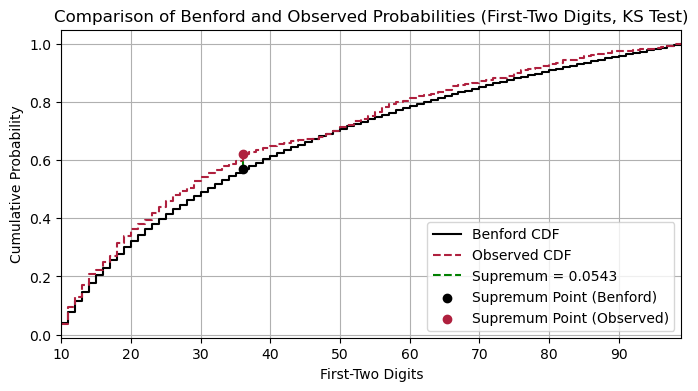

Supremum: 0.0543
First Digits of Supremum: 36
P-value (manual calculation): 0.1381

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=1:
Alpha level: 0.001000
Alpha level: 0.010000
Alpha level: 0.050000

Adjusted Alpha Levels (Bonferroni Correction) for num_tests=115:
Alpha level: 0.000009
Alpha level: 0.000087
Alpha level: 0.000435

Total observations (n): 453


In [412]:
# Compute Bonferroni-adjusted alpha levels for different num_tests
alpha_levels_results = {}
for num_tests in [1, 115]:
    alpha_levels_results[num_tests] = apply_bonferroni_correction(num_tests=num_tests)
    
# Compute cumulative proportions for Benford's law and observed data
benford_digits = list(Benford_theory_firsttwo_digits().keys())  
benford_probs = list(Benford_theory_firsttwo_digits().values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities_firsttwo(election_data_20['GENERAL RESULTS']).keys())
election_probs = list(data_digit_probabilities_firsttwo(election_data_20['GENERAL RESULTS']).values())
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the KS statistic manually
supremum, supremum_index = calculate_ks_manually(benford_cumulative, election_cumulative)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Calculate the theoretical p-value manually
n = twop  # Total observations
p_value_manual = manual_ks_p_value(supremum, n)

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
plt.step(range(10, 100), benford_cumulative, where="post", label="Benford CDF", color="black")
plt.step(range(10, 100), election_cumulative, where="post", label="Observed CDF", color="#af203e", linestyle="--")

# Highlight the supremum
plt.plot(
    [supremum_x, supremum_x],
    [supremum_y_benford, supremum_y_el],
    color="green",
    linestyle="--",
    label=f"Supremum = {supremum:.4f}"
)

# Add points for the supremum
plt.scatter([supremum_x], [supremum_y_benford], color="black", zorder=5, label="Supremum Point (Benford)")
plt.scatter([supremum_x], [supremum_y_el], color="#af203e", zorder=5, label="Supremum Point (Observed)")

# Customize the plot
plt.xlabel("First-Two Digits")
plt.ylabel("Cumulative Probability")
plt.title("Comparison of Benford and Observed Probabilities (First-Two Digits, KS Test)")
plt.legend()
plt.grid(True)
plt.xlim(10, 99)
plt.show()

# Print results
print(f"Supremum: {supremum:.4f}")
print(f"First Digits of Supremum: {supremum_x}")
print(f"P-value (manual calculation): {p_value_manual:.4f}\n")

for num_tests, adjusted_alpha_levels in alpha_levels_results.items():
    print(f"Adjusted Alpha Levels (Bonferroni Correction) for num_tests={num_tests}:")
    for alpha in adjusted_alpha_levels:
        print(f"Alpha level: {alpha:.6f}")
    print()

print(f"Total observations (n): {n}")


In [413]:
election_data_20_firsttwo_digit = pd.DataFrame()
election_data_20_firsttwo_digit['Digit'] = list(Benford_theory_firsttwo_digits().keys())
election_data_20_firsttwo_digit['Benford'] = [round(val, 3) for val in list(Benford_theory_firsttwo_digits().values())]
election_data_20_firsttwo_digit['Election data 2020'] = [round(val, 3) for val in list(data_digit_probabilities_firsttwo(election_data_20['GENERAL RESULTS']).values())]
election_data_20_firsttwo_digit['Difference'] = [round(val, 3) for val in (election_data_20_firsttwo_digit['Election data 2020'] - election_data_20_firsttwo_digit['Benford'])]
election_data_20_firsttwo_digit['Z test P-value'] = [round(val, 3) for val in list(p_value.values())]

election_data_20_firsttwo_digit

#rapresent in a LateX table only the 10 rows with the lowest Z test P-value
election_data_20_firsttwo_digit.nsmallest(10, 'Z test P-value').to_latex('election_data_20_firsttwo_digit.tex', float_format="%.3f")


#election_data_20_firsttwo_digit.to_latex('election_data_20_firsttwo_digit.tex', float_format="%.3f")

C:\Users\franc\AppData\Local\Temp\ipykernel_5012\2159139045.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  election_data_20_firsttwo_digit.nsmallest(10, 'Z test P-value').to_latex('election_data_20_firsttwo_digit.tex', float_format="%.3f")
